**Bank Churn Prediction**

**Big Data in Finance I, MSc Financial Technology 2024, Imperial College London**

# Table of Content

- [Required Packages](#Required-Packages)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  - [Original data definition](#Original-data-definition)
  - [Correlation Plot](#Correlation-Plot)
  - [Feature Distribution](#Feature-Distribution)
- [Data Preprocessing](#Data-Preprocessing)
  - [Feature Engineering](#Feature-Engineering)
  - [Train-Test Split](#Train-Test-Split)
  - [Normalisation of continuous variables](#Normalisation-of-continuous-variables)
  - [Over-sampling (SmoteNC)](#Over-sampling)
- [Predictive Modelling](#Predictive-Modelling)
  - [Parametric Models](#Parametric-Models)
    - [Logistic Regression](#Logistic-Regression)
    - [Discriminant Analysis](#Discriminant-Analysis)
  - [Non-parametric Models](#Non-parametric-Models)
    - [SVM](#SVM)
    - [Tree Based Model](#Tree-Based-Model)
      - [Classification Tree](#Classification-Tree)
      - [Random Forest Classifier](#Random-Forest-Classifier)
      - [Ada boost (Adaptive Boosting)](#Ada-boost-Adaptive-Boosting)
      - [XGBoost (eXtreme Gradient Boosting)](#XGBoost-eXtreme-Gradient-Boosting)
      - [CatBoost (Categorical Boosting) Classifier](#CatBoost-Catetgorical-Boosting-Classifier)
  - [Feature Importance Analysis](#Feature-Importance-Analysis)
- [Performance Evaluation](#Performance-Evaluation)
  - [Performance Data Collection](#Performance-Data-Collection)
  - [ROC-AUC Analysis](#ROC-AUC-Analysis)
  - [Accuracy Analysis](#Accuracy-Analysis)
  - [False Negative Analysis](#False-Negative-Analysis)
  - [Cost Saving Estimation](#Cost-Saving-Estimation)


# Required Packages

In [1]:
import shap
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
from collections import OrderedDict

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_objective

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
warnings.filterwarnings('ignore') # ignore warnings
random_state = 9 # set random state for reproducibility
np.int = int # to avoid error in BayesSearchCV caused by newer version of np.int 

# sns.set_context("paper")  # set seaborn plotting style
# SMOTENC error: if SMOTENC cannot handle more than 15 columns, install threadpoolctl using: 
# pip install -U threadpoolctl 

# Exploratory Data Analysis

In [3]:
# data source: https://www.kaggle.com/datasets/santoshd3/bank-customers/data

In [4]:
df_churn = pd.read_csv("Churn_Modelling.csv")
df_churn.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

## Original data definition
- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no)

In [224]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [225]:
df_churn.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [226]:
df_churn.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True)

## Correlation Plot

In [227]:
df_for_corr_plot = df_churn.copy()

label_encoder_gender = LabelEncoder()
label_encoder_geo = LabelEncoder()

df_for_corr_plot['Gender_Bi'] = label_encoder_gender.fit_transform(df_for_corr_plot['Gender']).astype('int64')
df_for_corr_plot = df_for_corr_plot.select_dtypes(include=['float64', 'int64', 'int32'])

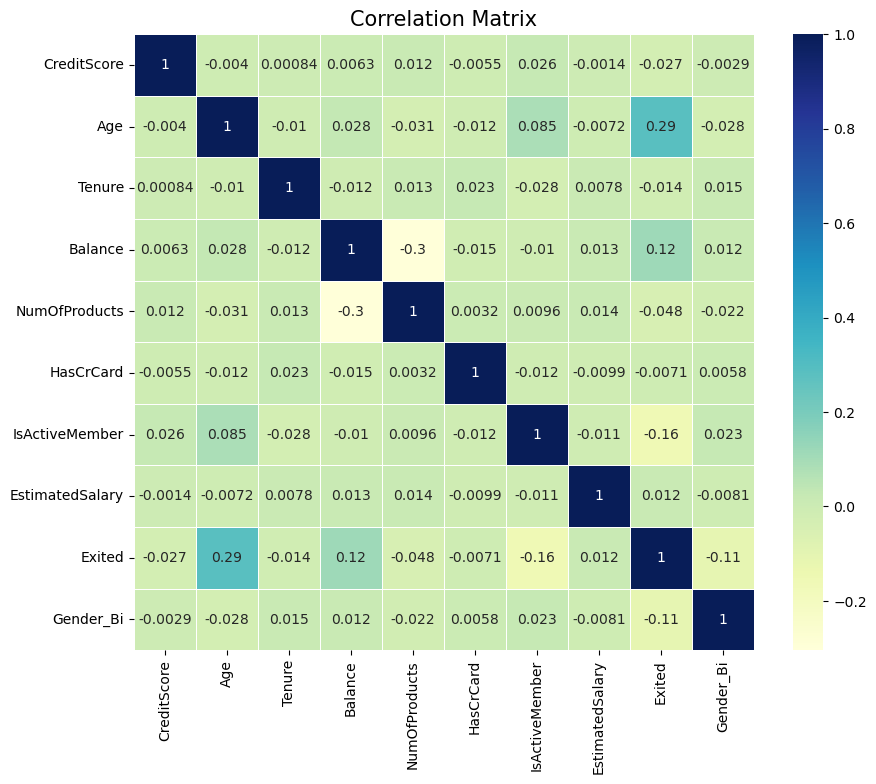

In [228]:
corr = df_for_corr_plot.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu', linewidths=0.5, linecolor='white', cbar=True)
# plt.xticks(rotation=45, ha="right")
plt.title('Correlation Matrix', fontsize=15)
plt.show()

## Feature Distribution

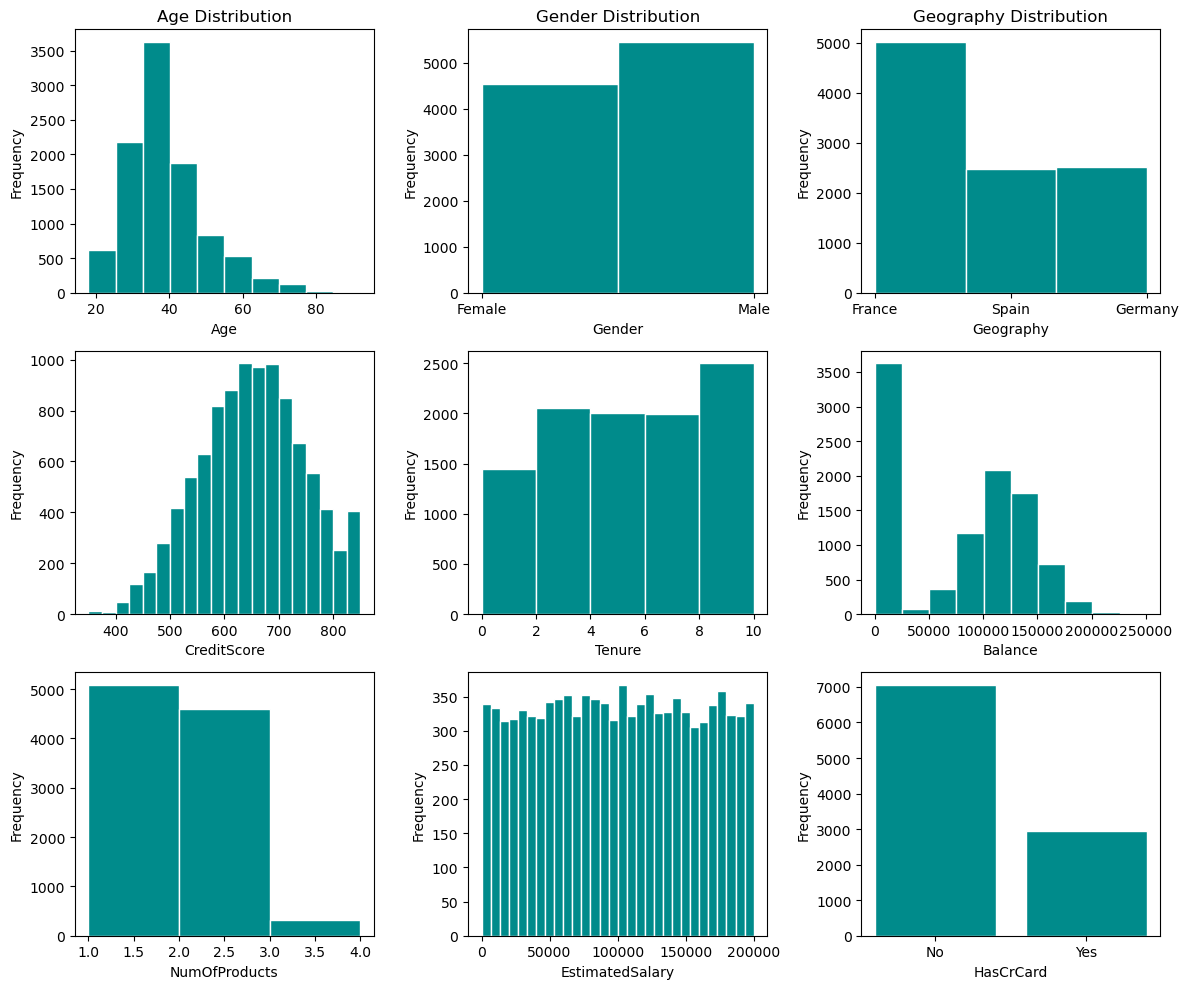

In [229]:
plt.figure(figsize=(12, 10))
color = "darkcyan"

plt.subplot(3, 3, 1)
plt.hist(df_churn["Age"], bins=10, edgecolor="white", color=color)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")

plt.subplot(3, 3, 2)
plt.hist(df_churn["Gender"], bins=2, edgecolor="white", color=color)
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.title("Gender Distribution")

plt.subplot(3, 3, 3)
plt.hist(df_churn["Geography"], bins=3, edgecolor="white", color=color)
plt.xlabel("Geography")
plt.ylabel("Frequency")
plt.title("Geography Distribution")

plt.subplot(3, 3, 4)
plt.hist(df_churn["CreditScore"], bins=20, edgecolor="white", color=color)
plt.xlabel("CreditScore")
plt.ylabel("Frequency")

plt.subplot(3, 3, 5)
plt.hist(df_churn["Tenure"], bins=5, edgecolor="white", color=color)
plt.xlabel("Tenure")
plt.ylabel("Frequency")

plt.subplot(3, 3, 6)
plt.hist(df_churn["Balance"], bins=10, edgecolor="white", color=color)
plt.xlabel("Balance")
plt.ylabel("Frequency")

plt.subplot(3, 3, 7)
plt.hist(df_churn["NumOfProducts"], bins=3, edgecolor="white", color=color)
plt.xlabel("NumOfProducts")
plt.ylabel("Frequency")

plt.subplot(3, 3, 8)
plt.hist(df_churn["EstimatedSalary"], bins=30, edgecolor="white", color=color)
plt.xlabel("EstimatedSalary")
plt.ylabel("Frequency")

plt.subplot(3, 3, 9)
plt.bar(
    df_churn["HasCrCard"].value_counts().index.astype(str),
    df_churn["HasCrCard"].value_counts().values,
    color=color,
    edgecolor="white",
)
plt.xlabel("HasCrCard")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["No", "Yes"])  # 0 = No, 1 = Yes for 'HasCrCard'
plt.tight_layout()
plt.show()

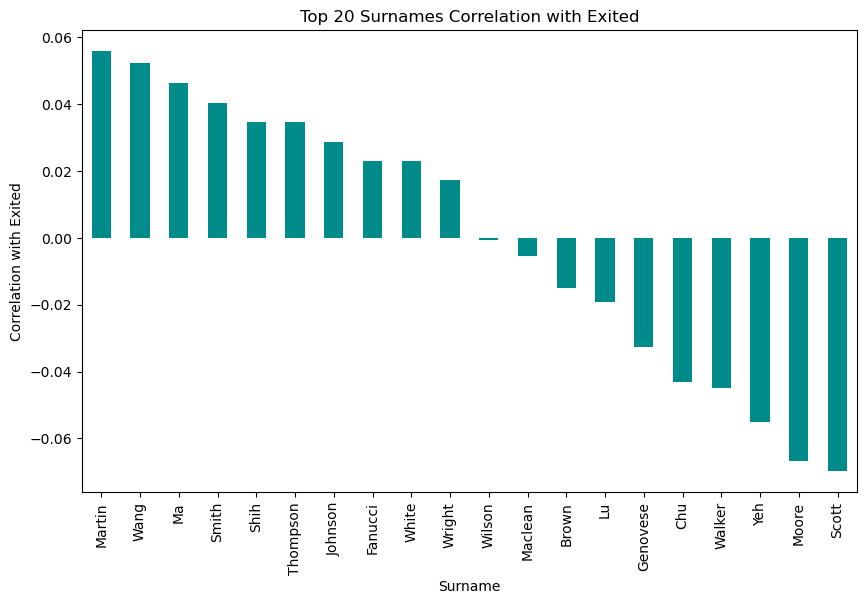

In [230]:
top_surnames = df_churn["Surname"].value_counts()[0:20]
top_surnames_df = df_churn[df_churn["Surname"].isin(top_surnames.index)]

top_surnames_df_oh = pd.get_dummies(top_surnames_df, columns=["Surname"], dtype=float)
top_surnames_df_oh = top_surnames_df_oh[
    ["Exited"] + list(top_surnames_df_oh.filter(regex="^Surname_").columns)
]
top_surnames_df_oh.columns = top_surnames_df_oh.columns.str.replace("Surname_", "")
correlation = top_surnames_df_oh.corr()["Exited"].sort_values(ascending=False)
correlation.drop("Exited", inplace=True)

correlation.plot(kind="bar", figsize=(10, 6), color=color)
plt.xlabel("Surname")
plt.ylabel("Correlation with Exited")
plt.title("Top 20 Surnames Correlation with Exited")
plt.show()

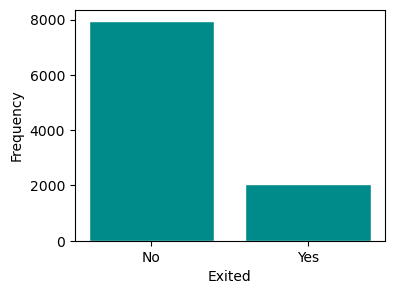

In [231]:
plt.figure(figsize=(4, 3))
plt.bar(
    df_churn["Exited"].value_counts().index.astype(str),
    df_churn["Exited"].value_counts().values,
    color=color,
    edgecolor="white",
)
plt.xlabel("Exited")
plt.ylabel("Frequency")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

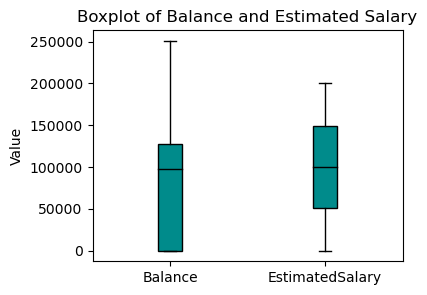

In [232]:
plt.figure(figsize=(4, 3))
color = "darkcyan"
plt.boxplot(
    df_churn[["Balance", "EstimatedSalary"]],
    labels=["Balance", "EstimatedSalary"],
    patch_artist=True,
    boxprops=dict(facecolor=color, color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black"),
)
plt.title("Boxplot of Balance and Estimated Salary")
plt.ylabel("Value")
plt.show()

Text(0.5, 1.0, 'Balance Distribution')

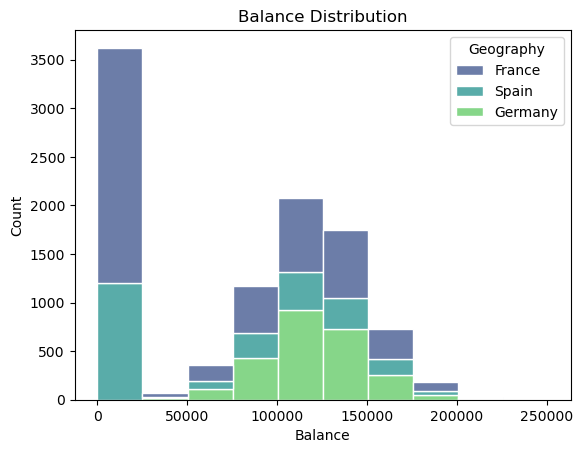

In [233]:
sns.histplot(
    data=df_churn,
    x="Balance",
    hue="Geography",
    bins=10,
    palette="viridis",
    edgecolor="white",
    multiple="stack",
)
plt.title("Balance Distribution")

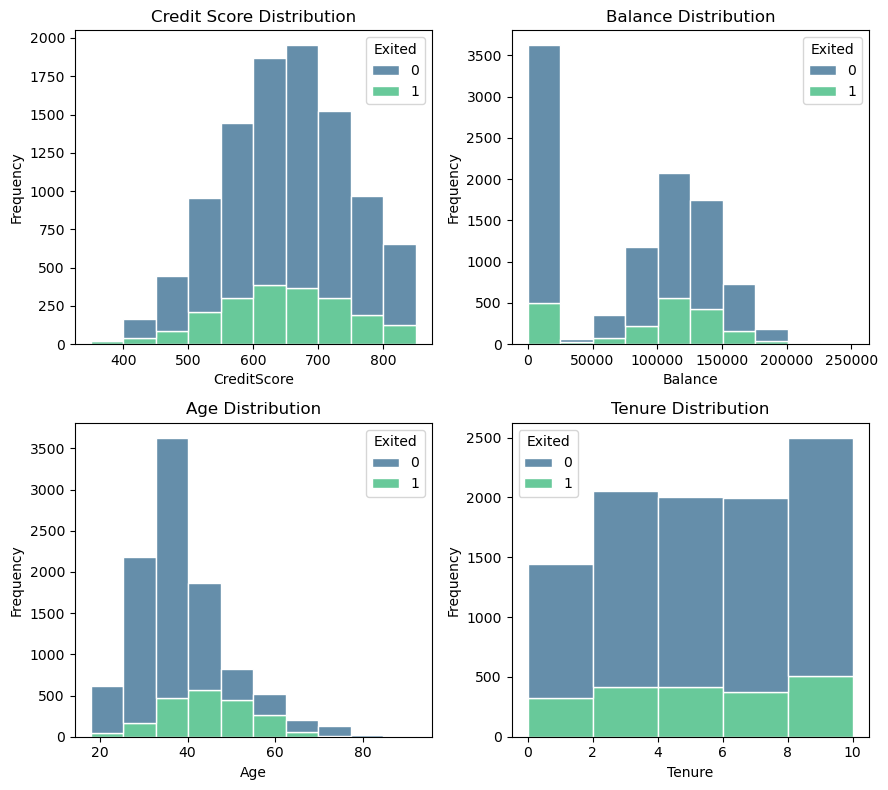

In [234]:
fig, axes = plt.subplots(2, 2, figsize=(9, 8))

sns.histplot(data=df_churn, x='CreditScore', hue='Exited', bins=10, ax=axes[0, 0], palette="viridis", edgecolor='white', multiple="stack")
axes[0, 0].set_title('Credit Score Distribution')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(data=df_churn, x='Balance', hue='Exited', bins=10, ax=axes[0, 1], palette="viridis", edgecolor='white', multiple="stack")
axes[0, 1].set_title('Balance Distribution')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(data=df_churn, x='Age', hue='Exited', bins=10, ax=axes[1, 0], palette="viridis", edgecolor='white', multiple="stack")
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(data=df_churn, x='Tenure', hue='Exited', bins=5, ax=axes[1, 1], palette="viridis", edgecolor='white', multiple="stack")
axes[1, 1].set_title('Tenure Distribution')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [235]:
X = df_churn.drop('Exited', axis=1)
y = df_churn['Exited']

## Feature Engineering

- create feature of zero balance customer
- create feature of active user with credit card
- create feature of active user with credit card and balance
- create feature of product utilisation rate per annum
- create features of vectorised surnames

In [236]:
label_encoder_gender = LabelEncoder()
label_encoder_geo = LabelEncoder()
X['Gender_Bi'] = label_encoder_gender.fit_transform(X['Gender']).astype('int64')
X['Geography_Label'] = label_encoder_geo.fit_transform(X['Geography']).astype('int64')
X

Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0      Hargrave          619    France  Female   42       2       0.00   
1          Hill          608     Spain  Female   41       1   83807.86   
2          Onio          502    France  Female   42       8  159660.80   
3          Boni          699    France  Female   39       1       0.00   
4      Mitchell          850     Spain  Female   43       2  125510.82   
...         ...          ...       ...     ...  ...     ...        ...   
9995   Obijiaku          771    France    Male   39       5       0.00   
9996  Johnstone          516    France    Male   35      10   57369.61   
9997        Liu          709    France  Female   36       7       0.00   
9998  Sabbatini          772   Germany    Male   42       3   75075.31   
9999     Walker          792    France  Female   28       4  130142.79   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Gender_Bi  \
0                 1          1               1        101348.88          0   
1                 1          0               1        112542.58          0   
2                 3          1               0        113931.57          0   
3                 2          0               0         93826.63          0   
4                 1          1               1         79084.10          0   
...             ...        ...             ...              ...        ...   
9995              2          1               0         96270.64          1   
9996              1          1               1        101699.77          1   
9997              1          0               1         42085.58          0   
9998              2          1               0         92888.52          1   
9999              1          1               0         38190.78          0   

      Geography_Label  
0                   0  
1                   2  
2                   0  
3                   0  
4                   2  
...               ...  
9995                0  
9996                0  
9997                0  
9998                1  
9999                0  

[10000 rows x 13 columns]

In [237]:
X['Balance_Zero'] = X['Balance'].apply(lambda x: 1 if x==0 else 0)
X['Active_CrCard'] = X['HasCrCard'] * X['IsActiveMember']
X['Active_CrCard_Balance'] = X['HasCrCard'] * X['IsActiveMember'] * X['Balance']
X['Utilisation_PA'] = (X['NumOfProducts'] / X['Tenure']).round(4)
X['Utilisation_PA'].replace([np.inf, -np.inf], 0, inplace=True)

In [238]:
X

Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0      Hargrave          619    France  Female   42       2       0.00   
1          Hill          608     Spain  Female   41       1   83807.86   
2          Onio          502    France  Female   42       8  159660.80   
3          Boni          699    France  Female   39       1       0.00   
4      Mitchell          850     Spain  Female   43       2  125510.82   
...         ...          ...       ...     ...  ...     ...        ...   
9995   Obijiaku          771    France    Male   39       5       0.00   
9996  Johnstone          516    France    Male   35      10   57369.61   
9997        Liu          709    France  Female   36       7       0.00   
9998  Sabbatini          772   Germany    Male   42       3   75075.31   
9999     Walker          792    France  Female   28       4  130142.79   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Gender_Bi  \
0                 1          1               1        101348.88          0   
1                 1          0               1        112542.58          0   
2                 3          1               0        113931.57          0   
3                 2          0               0         93826.63          0   
4                 1          1               1         79084.10          0   
...             ...        ...             ...              ...        ...   
9995              2          1               0         96270.64          1   
9996              1          1               1        101699.77          1   
9997              1          0               1         42085.58          0   
9998              2          1               0         92888.52          1   
9999              1          1               0         38190.78          0   

      Geography_Label  Balance_Zero  Active_CrCard  Active_CrCard_Balance  \
0                   0             1              1                   0.00   
1                   2             0              0                   0.00   
2                   0             0              0                   0.00   
3                   0             1              0                   0.00   
4                   2             0              1              125510.82   
...               ...           ...            ...                    ...   
9995                0             1              0                   0.00   
9996                0             0              1               57369.61   
9997                0             1              0                   0.00   
9998                1             0              0                   0.00   
9999                0             0              0                   0.00   

      Utilisation_PA  
0             0.5000  
1             1.0000  
2             0.3750  
3             2.0000  
4             0.5000  
...              ...  
9995          0.4000  
9996          0.1000  
9997          0.1429  
9998          0.6667  
9999          0.2500  

[10000 rows x 17 columns]

## Train-Test Split

In [239]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=random_state, test_size=0.3, shuffle=True, stratify=y)

In [240]:
# reserve raw data for Catboost since it uses sequential encoding to automatically handle categorical features
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
X_train_cat.drop(['Gender_Bi','Geography_Label'], axis=1)
X_test_cat.drop(['Gender_Bi','Geography_Label'], axis=1)
X_test_cat.head()

Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
2239  Pickering          493    France  Female   31       3       0.00   
5924      Riley          738    France  Female   39       1   94435.45   
9967   Pugliesi          623    France    Male   48       5  118469.38   
4876        Wei          657     Spain  Female   27       8       0.00   
9391    Herbert          846     Spain    Male   61       0       0.00   

      NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Gender_Bi  \
2239              1          1               1        176570.28          0   
5924              2          0               1        189430.86          0   
9967              1          1               1        158590.25          1   
4876              2          0               0          6468.24          0   
9391              2          1               1         96202.44          1   

      Geography_Label  Balance_Zero  Active_CrCard  Active_CrCard_Balance  \
2239                0             1              1                   0.00   
5924                0             0              0                   0.00   
9967                0             0              1              118469.38   
4876                2             1              0                   0.00   
9391                2             1              1                   0.00   

      Utilisation_PA  
2239          0.3333  
5924          2.0000  
9967          0.2000  
4876          0.2500  
9391          0.0000

In [241]:
X_train = X_train.drop(['Geography','Gender'], axis=1)
X_test = X_test.drop(['Geography','Gender'], axis=1)

Apply CountVectorizer to top 500 surname

In [242]:
surname_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                     strip_accents='unicode',
                                     max_features=500)
surname_vec_train = surname_vectorizer.fit_transform(X_train['Surname'])
surname_vec_test = surname_vectorizer.transform(X_test['Surname'])

surname_vec_train = surname_vec_train.todense()
surname_vec_test = surname_vec_test.todense()
surname_vec_train = pd.DataFrame(surname_vec_train, columns=surname_vectorizer.get_feature_names_out())
surname_vec_test = pd.DataFrame(surname_vec_test, columns=surname_vectorizer.get_feature_names_out())

X_train.drop('Surname', axis=1, inplace=True)
X_test.drop('Surname', axis=1, inplace=True)

## Normalisation of continuous variables

Prepare data for tree based models (no scaling)

In [243]:
# x train unscaled for tree models
X_train_trees = X_train.copy()
X_test_trees = X_test.copy()

# x train name vec for tree models
X_train_trees_namevec = pd.concat([X_train.reset_index(drop=True), surname_vec_train.reset_index(drop=True)], axis=1)
X_test_trees_namevec = pd.concat([X_test.reset_index(drop=True), surname_vec_test.reset_index(drop=True)], axis=1)

Prepare data for non-tree based models (requires scaling)


Minmax

In [244]:
columns_to_scale = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "NumOfProducts",
    "EstimatedSalary",
    "Active_CrCard_Balance",
    "Utilisation_PA",
]
columns_no_scale = [
    "HasCrCard",
    "IsActiveMember",
    "Gender_Bi",
    "Geography_Label",
    "Balance_Zero",
    "Active_CrCard",
]

In [245]:
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(
    X_train[columns_to_scale])
X_test_minmax = scaler_minmax.transform(
    X_test[columns_to_scale])

# x train minmax 
X_train_minmax = pd.DataFrame(X_train_minmax, columns=columns_to_scale)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=columns_to_scale)

# x train minmax with name vec
X_train_minmax_namevec = pd.concat([X_train_minmax.reset_index(drop=True), surname_vec_train.reset_index(drop=True)], axis=1)
X_test_minmax_namevec = pd.concat([X_test_minmax.reset_index(drop=True), surname_vec_test.reset_index(drop=True)], axis=1)

In [246]:
X_train_minmax = pd.concat([X_train_minmax, X_train[columns_no_scale].reset_index(drop=True)], axis=1)
X_test_minmax = pd.concat([X_test_minmax, X_test[columns_no_scale].reset_index(drop=True)], axis=1)
X_train_minmax_namevec = pd.concat([X_train_minmax_namevec, X_train[columns_no_scale].reset_index(drop=True)], axis=1)
X_test_minmax_namevec = pd.concat([X_test_minmax_namevec, X_test[columns_no_scale].reset_index(drop=True)], axis=1)

Standard Z

In [247]:
scaler_z = StandardScaler()
X_train_zscaled = scaler_z.fit_transform(
    X_train[columns_to_scale])
X_test_zscaled = scaler_z.transform(
    X_test[columns_to_scale])

# x train z scaled
X_train_zscaled = pd.DataFrame(X_train_zscaled, columns=columns_to_scale)
X_test_zscaled = pd.DataFrame(X_test_zscaled, columns=columns_to_scale)

# x train z scaled with name vec
X_train_zscaled_namevec = pd.concat([X_train_zscaled.reset_index(drop=True), surname_vec_train.reset_index(drop=True)], axis=1)
X_test_zscaled_namevec = pd.concat([X_test_zscaled.reset_index(drop=True), surname_vec_test.reset_index(drop=True)], axis=1)

In [248]:
X_train_zscaled = pd.concat([X_train_zscaled, X_train[columns_no_scale].reset_index(drop=True)], axis=1)
X_test_zscaled = pd.concat([X_test_zscaled, X_test[columns_no_scale].reset_index(drop=True)], axis=1)
X_train_zscaled_namevec = pd.concat([X_train_zscaled_namevec, X_train[columns_no_scale].reset_index(drop=True)], axis=1)
X_test_zscaled_namevec = pd.concat([X_test_zscaled_namevec, X_test[columns_no_scale].reset_index(drop=True)], axis=1)

## Over-sampling

In [249]:
y_train.value_counts()

Exited
0    5574
1    1426
Name: count, dtype: int64

In [250]:
# oversample for logistic, lda, qda, svm
binary_mask_X_train_zscale = (X_train_zscaled.dtypes == 'int64').values
smote_nc_X_train_zscale = SMOTENC(categorical_features = binary_mask_X_train_zscale, random_state=random_state)
X_train_zscaled_smotenc, y_train_smotenc_zscaled = smote_nc_X_train_zscale.fit_resample(X_train_zscaled, y_train)
y_train_smotenc_zscaled.value_counts()

Exited
0    5574
1    5574
Name: count, dtype: int64

In [251]:
# oversample for logistic, lda, qda, svm
binary_mask_X_train_minmax = (X_train_minmax.dtypes == 'int64').values
smote_nc_X_train_minmax = SMOTENC(categorical_features = binary_mask_X_train_minmax, random_state=random_state)
X_train_minmax_smotenc, y_train_smotenc_minmax = smote_nc_X_train_minmax.fit_resample(X_train_minmax, y_train)
y_train_smotenc_minmax.value_counts()

Exited
0    5574
1    5574
Name: count, dtype: int64

In [252]:
# oversample for trees 
binary_mask_X_train_trees = (X_train_trees.dtypes == 'int64').values | (X_train_trees.dtypes == 'object').values
smote_nc_X_train_trees = SMOTENC(categorical_features = binary_mask_X_train_trees, random_state=random_state)
X_train_trees_smotenc, y_train_smotenc_trees = smote_nc_X_train_trees.fit_resample(X_train_trees, y_train)
y_train_smotenc_trees.value_counts()

Exited
0    5574
1    5574
Name: count, dtype: int64

In [253]:
# oversample for catboost 
binary_mask_X_train_cat = (X_train_cat.dtypes == 'int64').values | (X_train_cat.dtypes == 'object').values
smote_nc_X_train_cat = SMOTENC(categorical_features = binary_mask_X_train_cat, random_state=random_state)
X_train_cat_smotenc, y_train_smotenc_cat = smote_nc_X_train_cat.fit_resample(X_train_cat, y_train)
y_train_smotenc_cat.value_counts()

Exited
0    5574
1    5574
Name: count, dtype: int64

In [254]:
# oversample for zcaled surname vec 
binary_mask_X_train_zscaled_namevec = (X_train_zscaled_namevec.dtypes == 'int64').values | (X_train_zscaled_namevec.dtypes == 'object').values
smote_nc_X_train_zscaled_namevec = SMOTENC(categorical_features = binary_mask_X_train_zscaled_namevec, random_state=random_state)
X_train_zscaled_namevec_smotenc, y_train_smotenc_zscaled_namevec = smote_nc_X_train_zscaled_namevec.fit_resample(X_train_zscaled_namevec, y_train)
y_train_smotenc_zscaled_namevec.value_counts()

Exited
0    5574
1    5574
Name: count, dtype: int64

In [255]:
if np.array_equal(y_train_smotenc_zscaled, y_train_smotenc_minmax) and np.array_equal(y_train_smotenc_minmax, y_train_smotenc_cat) and np.array_equal(y_train_smotenc_cat, y_train_smotenc_trees) and np.array_equal(y_train_smotenc_cat,y_train_smotenc_zscaled_namevec):
    y_train_smotenc = y_train_smotenc_minmax.copy()
    del y_train_smotenc_minmax, y_train_smotenc_zscaled, y_train_smotenc_cat, y_train_smotenc_trees
y_train_smotenc.value_counts()

Exited
0    5574
1    5574
Name: count, dtype: int64

### PCA

#### PCA Before SmoteNC

In [256]:
label_map = {0: 'Stay', 1: 'Churn'}  
labels = np.array([label_map[y] for y in y_train])

Explained variance ratio of the first 2 components scaled by standard scalar: [0.19372922 0.15766254]
Most important feature for the 1st component scaled by standard scalar: Balance
Most important feature for the 2nd component scaled by standard scalar: Tenure


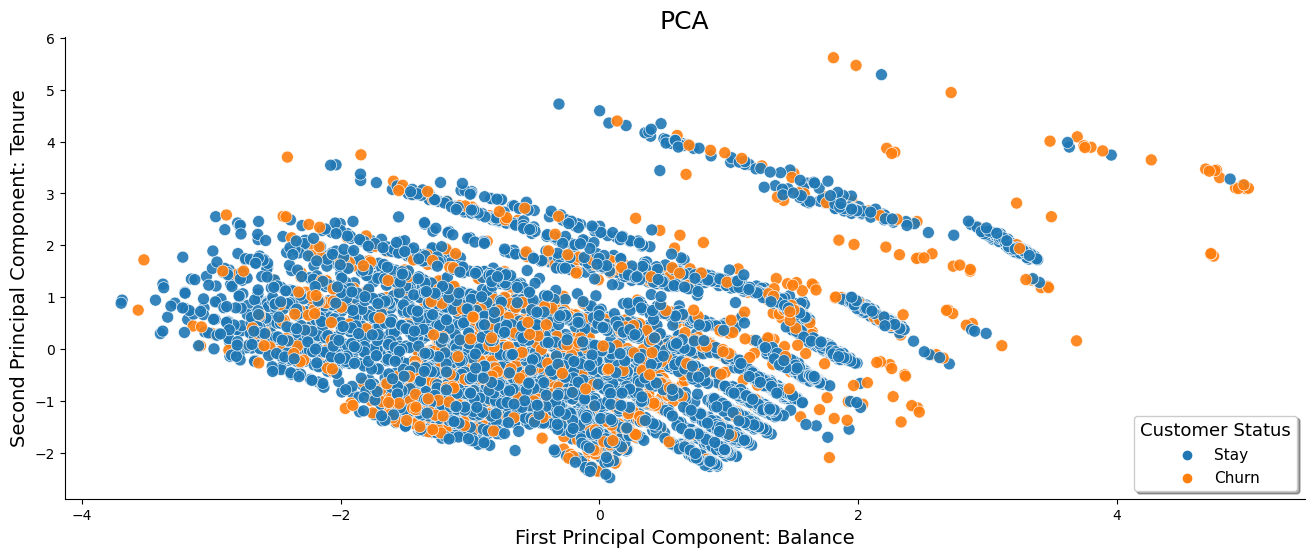

In [257]:
pca_zscaled = PCA(n_components=2)
X_pca_train_zscaled = pca_zscaled.fit_transform(X_train_zscaled)
explained_variance_zscaled = pca_zscaled.explained_variance_ratio_
components_zscaled = pca_zscaled.components_
most_important_feature_indices_zscaled = np.argmax(np.abs(components_zscaled), axis=1)
first_PC, second_PC = X_train_zscaled.columns[most_important_feature_indices_zscaled]
print(f"Explained variance ratio of the first 2 components scaled by standard scalar: {explained_variance_zscaled}")
print("Most important feature for the 1st component scaled by standard scalar:", first_PC)
print("Most important feature for the 2nd component scaled by standard scalar:", second_PC)

df_zscaled_pca = pd.DataFrame({
    'First Principal Component': X_pca_train_zscaled[:, 0],
    'Second Principal Component': X_pca_train_zscaled[:, 1],
    'Label': labels 
})
plt.figure(figsize=(16, 6))  
scatter = sns.scatterplot(data=df_zscaled_pca, x='First Principal Component', y='Second Principal Component', hue='Label', s=75,
                          palette="tab10", alpha=0.9, edgecolor='w', linewidth=0.5)

plt.title("PCA", fontsize=18)
plt.xlabel(f'First Principal Component: {first_PC}', fontsize=14)
plt.ylabel(f'Second Principal Component: {second_PC}', fontsize=14)

plt.legend(title='Customer Status', title_fontsize='13', fontsize='11', loc='lower right', frameon=True, shadow=True)

sns.despine()
plt.show()

#### PCA After SmoteNC

In [258]:
label_map = {0: 'Stay', 1: 'Churn'}  
labels_smotenc = np.array([label_map[y] for y in y_train_smotenc])

Explained variance ratio of the first 2 components scaled by standard scalar: [0.19372922 0.15766254]
Most important feature for the 1st component scaled by standard scalar: Balance
Most important feature for the 2nd component scaled by standard scalar: Tenure


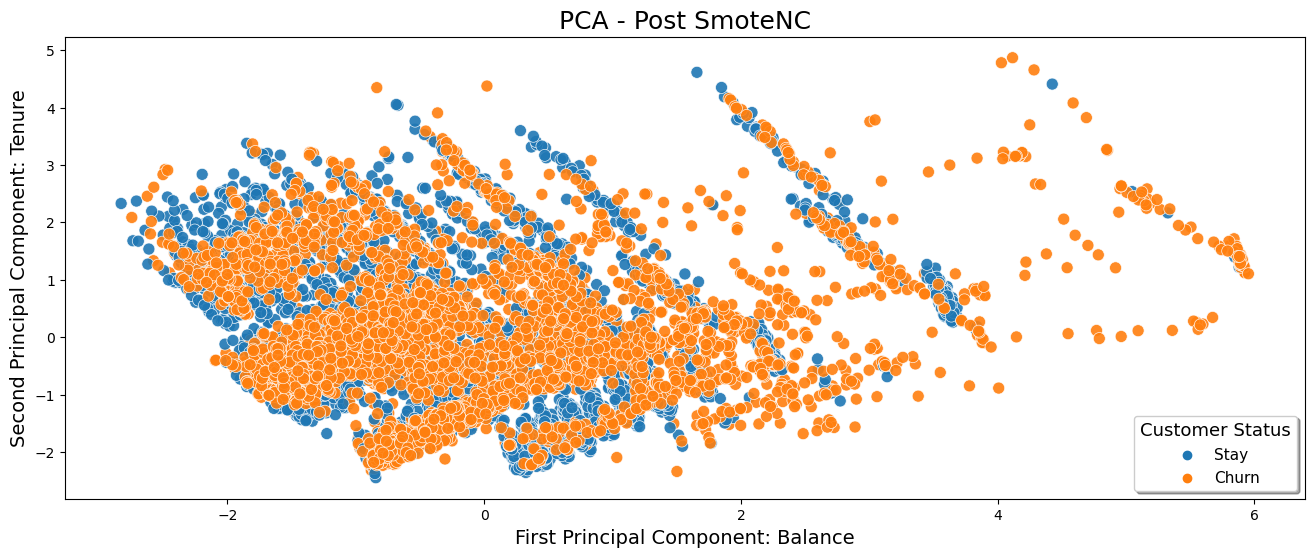

In [259]:
pca_zscaled_smotenc = PCA(n_components=2)
X_pca_train_zscaled_smotenc = pca_zscaled_smotenc.fit_transform(X_train_zscaled_smotenc)
explained_variance_zscaled = pca_zscaled.explained_variance_ratio_
components_zscaled = pca_zscaled.components_
most_important_feature_indices_zscaled = np.argmax(np.abs(components_zscaled), axis=1)
first_PC, second_PC = X_train_zscaled_smotenc.columns[most_important_feature_indices_zscaled]
print(f"Explained variance ratio of the first 2 components scaled by standard scalar: {explained_variance_zscaled}")
print("Most important feature for the 1st component scaled by standard scalar:", first_PC)
print("Most important feature for the 2nd component scaled by standard scalar:", second_PC)

df_zscaled_pca_smotenc = pd.DataFrame({
    'First Principal Component': X_pca_train_zscaled_smotenc[:, 0],
    'Second Principal Component': X_pca_train_zscaled_smotenc[:, 1],
    'Label': labels_smotenc 
})
plt.figure(figsize=(16, 6))  
scatter = sns.scatterplot(data=df_zscaled_pca_smotenc, x='First Principal Component', y='Second Principal Component', hue='Label', s=75,
                          palette="tab10", alpha=0.9, edgecolor='w', linewidth=0.5)

plt.title("PCA - Post SmoteNC", fontsize=18)
plt.xlabel(f'First Principal Component: {first_PC}', fontsize=14)
plt.ylabel(f'Second Principal Component: {second_PC}', fontsize=14)

plt.legend(title='Customer Status', title_fontsize='13', fontsize='11', loc='lower right', frameon=True, shadow=True)
plt.show()

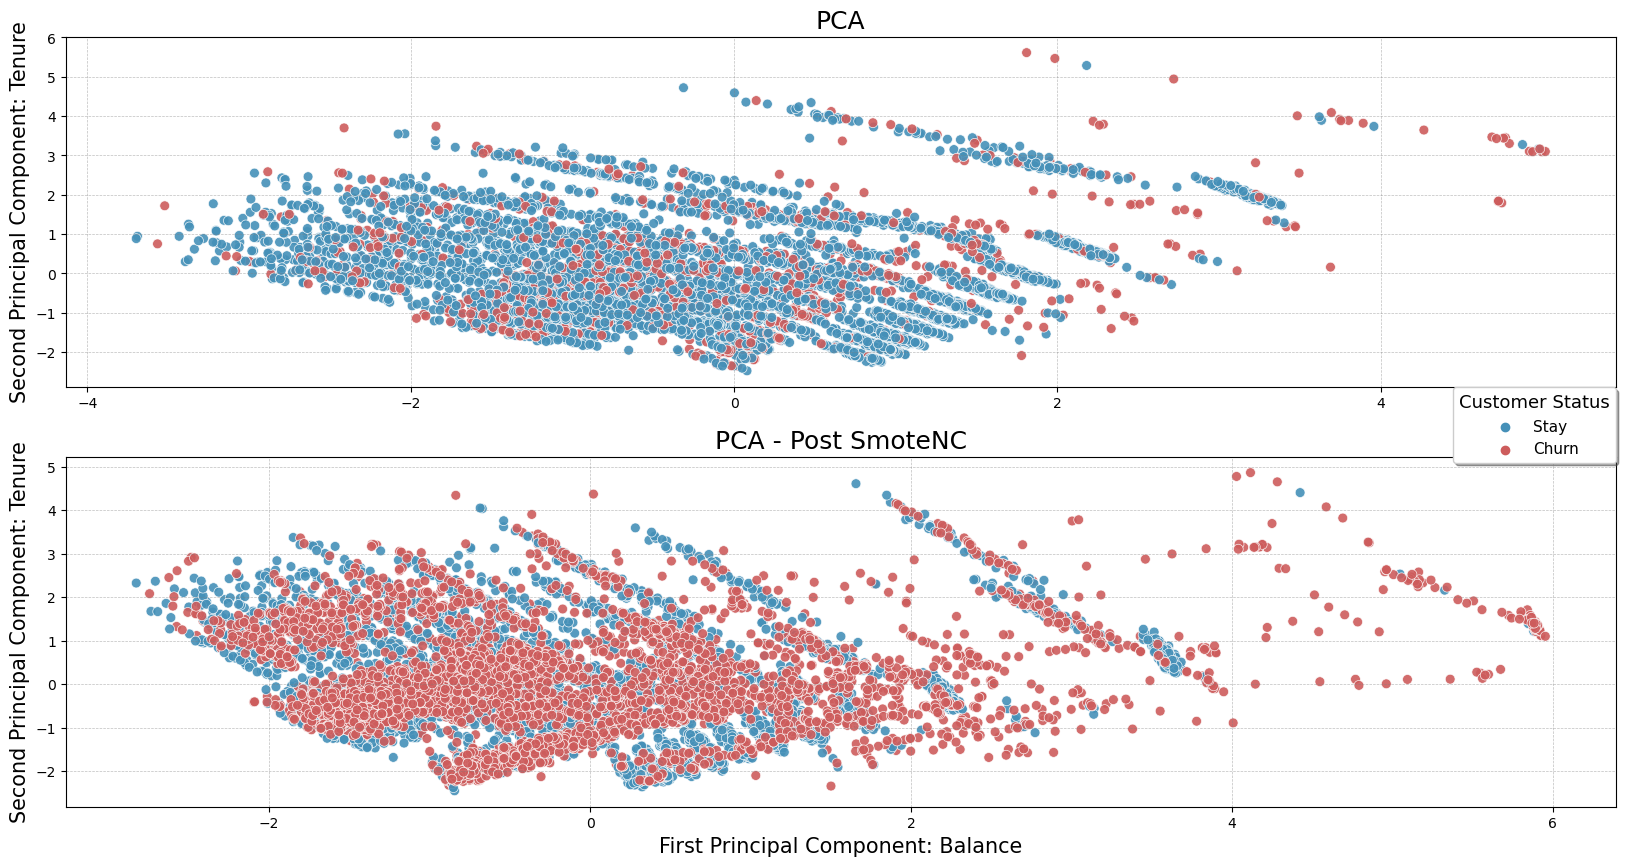

In [260]:
custom_palette_pca = {"Stay": "#4590B8", "Churn": "indianred"}
fig, axes = plt.subplots(2, 1, figsize=(20, 10))  
plt.subplots_adjust(hspace=0.2)  

sns.scatterplot(ax=axes[0], data=df_zscaled_pca, x='First Principal Component', y='Second Principal Component', hue='Label', s=50,
                palette=custom_palette_pca, alpha=0.9, edgecolor='w', linewidth=0.5, legend=False)
axes[0].set_title("PCA", fontsize=18)
axes[0].set_xlabel('')  
axes[0].set_ylabel(f'Second Principal Component: {second_PC}', fontsize=15)
axes[0].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5) 

sns.scatterplot(ax=axes[1], data=df_zscaled_pca_smotenc, x='First Principal Component', y='Second Principal Component', hue='Label', s=50,
                palette=custom_palette_pca, alpha=0.9, edgecolor='w', linewidth=0.5)
axes[1].set_title("PCA - Post SmoteNC", fontsize=18)
axes[1].set_xlabel(f'First Principal Component: {first_PC}', fontsize=15)
axes[1].set_ylabel(f'Second Principal Component: {second_PC}', fontsize=15)
axes[1].legend(title='Customer Status', title_fontsize='13', fontsize='11', loc='best', frameon=True, shadow=True, bbox_to_anchor=(1.005, 1.22))
axes[1].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.5) 

plt.show()


# Predictive Modelling 

- **Parametric Models**:
    - **Logistic Regression**: A linear model for classification with a fixed number of parameters determined by the feature space.
    - **Linear Discriminant Analysis (LDA)**: Assumes data is generated from a Gaussian distribution with parameters estimated from the training data.
    - **Quadratic Discriminant Analysis (QDA)**: Similar to LDA but allows each class to have its own covariance matrix, still assuming a parametric form of the distribution.
- **Non-parametric Models**:
    - **_Support Vector Machine (SVM)_**: SVMs are fundamentally linear classifiers but can model non-linear decision boundaries through the kernel trick. Despite having a fixed number of parameters related to the support vectors and kernel choice, their capacity to model complex relationships does not strictly fit the definition of parametric or non-parametric models.
    - **Classification Trees**: Does not assume any form for the data distribution and can adapt its shape based on the data it is trained on.
    - **Random Forest**: An ensemble of decision trees, inheriting the non-parametric nature of classification trees.
    - **AdaBoost (Adaptive Boosting)**: A boosting algorithm that combines multiple weak learners (often non-parametric) to create a strong classifier.
    - **XGBoost (Extreme Gradient Boosting)**: An efficient implementation of gradient boosting that does not assume a specific distribution of data.
    - **CatBoost**: A gradient boosting algorithm on decision trees, which does not require a specified form for the data distribution.


## Parametric Models

Since linear model is sensitive to multicollinearity, we will convert the categorical features to one-hot encoding and drop the first column to avoid multicollinearity.

In [41]:
X_train_zscaled_smotenc['Geography'] = label_encoder_geo.inverse_transform(X_train_zscaled_smotenc['Geography_Label'])
X_train_zscaled_smotenc = X_train_zscaled_smotenc.drop('Geography_Label', axis=1)
X_train_zscaled_smotenc = pd.get_dummies(X_train_zscaled_smotenc, columns=['Geography'], drop_first=True, dtype=int)

X_train_minmax_smotenc['Geography'] = label_encoder_geo.inverse_transform(X_train_minmax_smotenc['Geography_Label'])
X_train_minmax_smotenc = X_train_minmax_smotenc.drop('Geography_Label', axis=1)
X_train_minmax_smotenc = pd.get_dummies(X_train_minmax_smotenc, columns=['Geography'], drop_first=True, dtype=int)

In [42]:
X_train_zscaled['Geography'] = label_encoder_geo.inverse_transform(X_train_zscaled['Geography_Label'])
X_train_zscaled = X_train_zscaled.drop('Geography_Label', axis=1)
X_train_zscaled = pd.get_dummies(X_train_zscaled, columns=['Geography'], drop_first=True, dtype=int)

X_train_minmax['Geography'] = label_encoder_geo.inverse_transform(X_train_minmax['Geography_Label'])
X_train_minmax = X_train_minmax.drop('Geography_Label', axis=1)
X_train_minmax = pd.get_dummies(X_train_minmax, columns=['Geography'], drop_first=True, dtype=int)

In [43]:
X_test_zscaled['Geography'] = label_encoder_geo.inverse_transform(X_test_zscaled['Geography_Label'])
X_test_zscaled = X_test_zscaled.drop('Geography_Label', axis=1)
X_test_zscaled = pd.get_dummies(X_test_zscaled, columns=['Geography'], drop_first=True, dtype=int)

X_test_minmax['Geography'] = label_encoder_geo.inverse_transform(X_test_minmax['Geography_Label'])
X_test_minmax = X_test_minmax.drop('Geography_Label', axis=1)
X_test_minmax = pd.get_dummies(X_test_minmax, columns=['Geography'], drop_first=True, dtype=int)

### Logistic Regression

In [44]:
search_space_logistic = {
    "C": Real(1e-4, 1e4, prior="log-uniform"),
    "penalty": Categorical(["l2", "none"]),  
    "solver": Categorical(["newton-cg", "lbfgs", "sag", "saga"]),  
    "max_iter": Integer(100, 1000)
}
n_iter_logistic = 100

#### Logistic Regression - minmax 

In [45]:
logistic_bs_cv = BayesSearchCV(
    LogisticRegression(),
    search_space_logistic,
    n_iter=n_iter_logistic,
    cv=5,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
logistic_bs_cv.fit(X_train_minmax, y_train)
y_pred_logistic = logistic_bs_cv.predict(X_test_minmax)

cm_logistic= confusion_matrix(y_test, y_pred_logistic)
fpr_logistic_minmax, tpr_logistic_minmax, _ = roc_curve(y_test, logistic_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_logistic_minmax = roc_auc_score(y_test, logistic_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_logistic_minmax = accuracy_score(y_test, y_pred_logistic)

TN_logistic_minmax, FP_logistic_minmax, FN_logistic_minmax, TP_logistic_minmax = cm_logistic.ravel()
fnr_rr_logistic_minmax = FN_logistic_minmax / (FN_logistic_minmax + TP_logistic_minmax)
tnr_rr_logistic_minmax = TN_logistic_minmax / (TN_logistic_minmax + FP_logistic_minmax)

print("Prediction Accuracy:", accuracy_logistic_minmax)
print("Best parameters:", logistic_bs_cv.best_params_)

Prediction Accuracy: 0.807
Best parameters: OrderedDict([('C', 134.1086676129875), ('max_iter', 582), ('penalty', 'none'), ('solver', 'sag')])


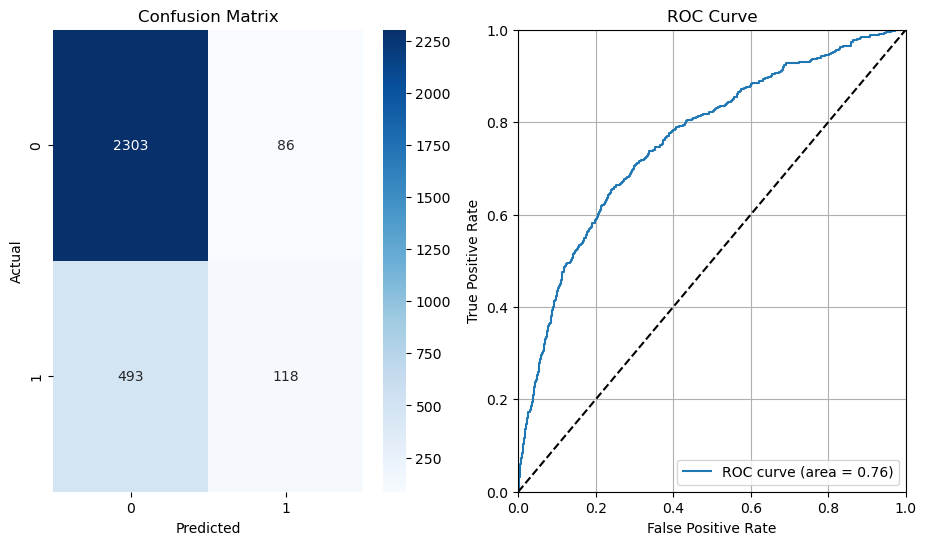

In [46]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_logistic_minmax, tpr_logistic_minmax, label=f'ROC curve (area = {auc_score_logistic_minmax:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Logistic Regression - zscald 

In [47]:
logistic_bs_cv = BayesSearchCV(
    LogisticRegression(),
    search_space_logistic,
    n_iter=n_iter_logistic,
    cv=5,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
logistic_bs_cv.fit(X_train_zscaled, y_train)
y_pred_logistic = logistic_bs_cv.predict(X_test_zscaled)

cm_logistic= confusion_matrix(y_test, y_pred_logistic)
fpr_logistic_zscaled, tpr_logistic_zscaled, _ = roc_curve(y_test, logistic_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_logistic_zscaled = roc_auc_score(y_test, logistic_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_logistic_zscaled = accuracy_score(y_test, y_pred_logistic)

TN_logistic_zscaled, FP_logistic_zscaled, FN_logistic_zscaled, TP_logistic_zscaled = cm_logistic.ravel()
fnr_rr_logistic_zscaled = FN_logistic_zscaled / (FN_logistic_zscaled + TP_logistic_zscaled)
tnr_rr_logistic_zscaled = TN_logistic_zscaled / (TN_logistic_zscaled + FP_logistic_zscaled)

print("Prediction Accuracy:", accuracy_logistic_zscaled)
print("Best parameters:", logistic_bs_cv.best_params_)

Prediction Accuracy: 0.8083333333333333
Best parameters: OrderedDict([('C', 0.021393520891429763), ('max_iter', 100), ('penalty', 'l2'), ('solver', 'lbfgs')])


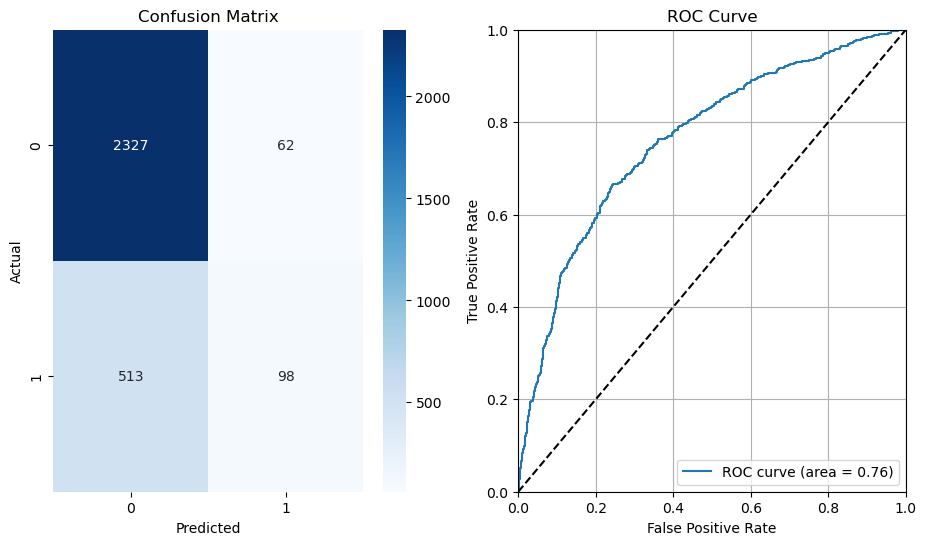

In [48]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_logistic_zscaled, tpr_logistic_zscaled, label=f'ROC curve (area = {auc_score_logistic_zscaled:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Logistic Regression - minmax - SmoteNC

In [49]:
logistic_bs_cv = BayesSearchCV(
    LogisticRegression(),
    search_space_logistic,
    n_iter=n_iter_logistic,
    cv=5,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
logistic_bs_cv.fit(X_train_minmax_smotenc, y_train_smotenc)
y_pred_logistic = logistic_bs_cv.predict(X_test_minmax)

cm_logistic= confusion_matrix(y_test, y_pred_logistic)
fpr_logistic_minmax_smotenc, tpr_logistic_minmax_smotenc, _ = roc_curve(y_test, logistic_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_logistic_minmax_smotenc = roc_auc_score(y_test, logistic_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_logistic_minmax_smotenc = accuracy_score(y_test, y_pred_logistic)
TN_logistic_minmax_smotenc, FP_logistic_minmax_smotenc, FN_logistic_minmax_smotenc, TP_logistic_minmax_smotenc = cm_logistic.ravel()
fnr_rr_logistic_minmax_smotenc = FN_logistic_minmax_smotenc / (FN_logistic_minmax_smotenc + TP_logistic_minmax_smotenc)
tnr_rr_logistic_minmax_smotenc = TN_logistic_minmax_smotenc / (TN_logistic_minmax_smotenc + FP_logistic_minmax_smotenc)
print("Prediction Accuracy:", accuracy_logistic_minmax_smotenc)
print("Best parameters:", logistic_bs_cv.best_params_)

Prediction Accuracy: 0.7293333333333333
Best parameters: OrderedDict([('C', 22.231562688424482), ('max_iter', 582), ('penalty', 'none'), ('solver', 'sag')])


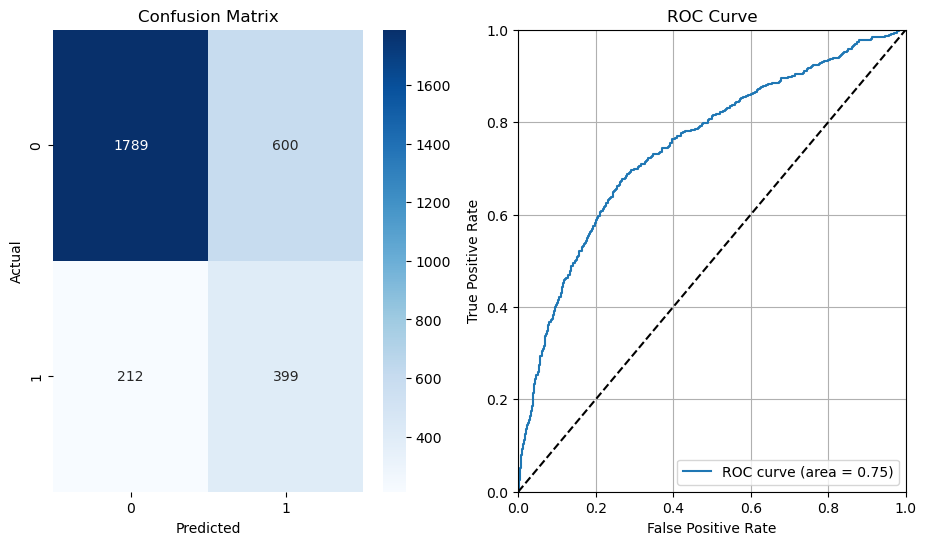

In [50]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_logistic_minmax_smotenc, tpr_logistic_minmax_smotenc, label=f'ROC curve (area = {auc_score_logistic_minmax_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Logistic Regression - zscaled - SmoteNC

In [51]:
logistic_zscaled_smote_bs_cv = BayesSearchCV(
    LogisticRegression(),
    search_space_logistic,
    n_iter=n_iter_logistic,
    cv=5,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
logistic_zscaled_smote_bs_cv.fit(X_train_zscaled_smotenc, y_train_smotenc)
y_pred_logistic = logistic_zscaled_smote_bs_cv.predict(X_test_zscaled)

cm_logistic= confusion_matrix(y_test, y_pred_logistic)
fpr_logistic_zscaled_smotenc, tpr_logistic_zscaled_smotenc, _ = roc_curve(y_test, logistic_zscaled_smote_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_logistic_zscaled_smotenc = roc_auc_score(y_test, logistic_zscaled_smote_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_logistic_zscaled_smotenc = accuracy_score(y_test, y_pred_logistic)
TN_logistic_zscaled_smotenc, FP_logistic_zscaled_smotenc, FN_logistic_zscaled_smotenc, TP_logistic_zscaled_smotenc = cm_logistic.ravel()
fnr_rr_logistic_zscaled_smotenc = FN_logistic_zscaled_smotenc / (FN_logistic_zscaled_smotenc + TP_logistic_zscaled_smotenc)
tnr_rr_logistic_zscaled_smotenc = TN_logistic_zscaled_smotenc / (TN_logistic_zscaled_smotenc + FP_logistic_zscaled_smotenc)
print("Prediction Accuracy:", accuracy_logistic_zscaled_smotenc)
print("Best parameters:", logistic_zscaled_smote_bs_cv.best_params_)

Prediction Accuracy: 0.7326666666666667
Best parameters: OrderedDict([('C', 0.0368533166660539), ('max_iter', 224), ('penalty', 'l2'), ('solver', 'lbfgs')])


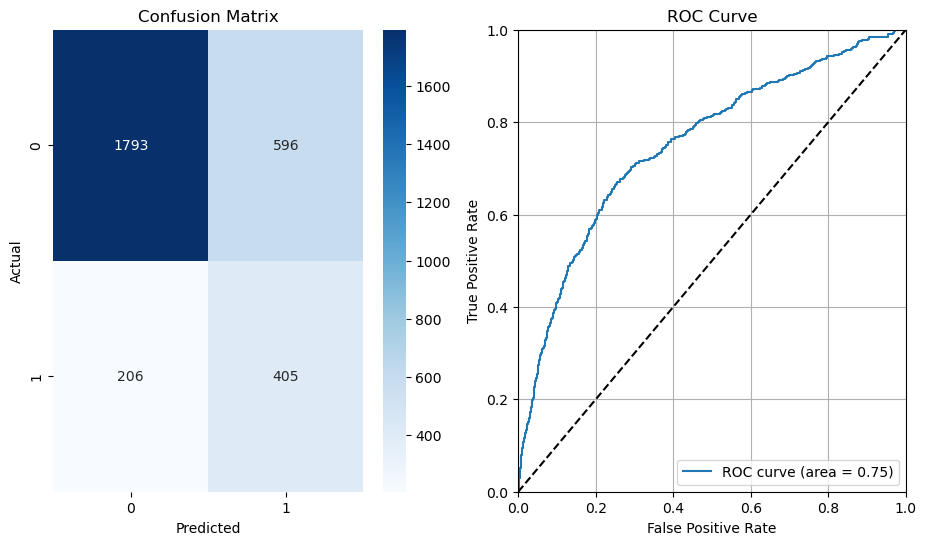

In [52]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_logistic_zscaled_smotenc, tpr_logistic_zscaled_smotenc, label=f'ROC curve (area = {auc_score_logistic_zscaled_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Based on outcomes from both the oversampled and the original datasets, the effectiveness of different scaling techniques showed no significant differences.

#### Logistic Regression of Surname Vec

Since we introduced regularisation in logistic regression, we can also append surname Vec document features matrix with 2000+ features to see the result.

##### Logistic Regression of Surname Vec - zscaled 

In [53]:
logistic_bs_cv = BayesSearchCV(
    LogisticRegression(),
    search_space_logistic,
    n_iter=n_iter_logistic,
    cv=5,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
logistic_bs_cv.fit(X_train_zscaled_namevec, y_train)
y_pred_logistic = logistic_bs_cv.predict(X_test_zscaled_namevec)
cm_logistic= confusion_matrix(y_test, y_pred_logistic)
fpr_logistic_zscaled_surname, tpr_logistic_zscaled_surname, _ = roc_curve(y_test, logistic_bs_cv.predict_proba(X_test_zscaled_namevec)[:, 1])
auc_score_logistic_zscaled_surname = roc_auc_score(y_test, logistic_bs_cv.predict_proba(X_test_zscaled_namevec)[:, 1])
accuracy_logistic_zscaled_surname = accuracy_score(y_test, y_pred_logistic)
TN_logistic_zscaled_surname, FP_logistic_zscaled_surname, FN_logistic_zscaled_surname, TP_logistic_zscaled_surname = cm_logistic.ravel()
fnr_rr_logistic_zscaled_surname = FN_logistic_zscaled_surname / (FN_logistic_zscaled_surname + TP_logistic_zscaled_surname)
tnr_rr_logistic_zscaled_surname = TN_logistic_zscaled_surname / (TN_logistic_zscaled_surname + FP_logistic_zscaled_surname)
print("Prediction Accuracy:", accuracy_logistic_zscaled_surname)
print("Best parameters:", logistic_bs_cv.best_params_)


Prediction Accuracy: 0.8033333333333333
Best parameters: OrderedDict([('C', 0.010094037800967926), ('max_iter', 262), ('penalty', 'l2'), ('solver', 'newton-cg')])


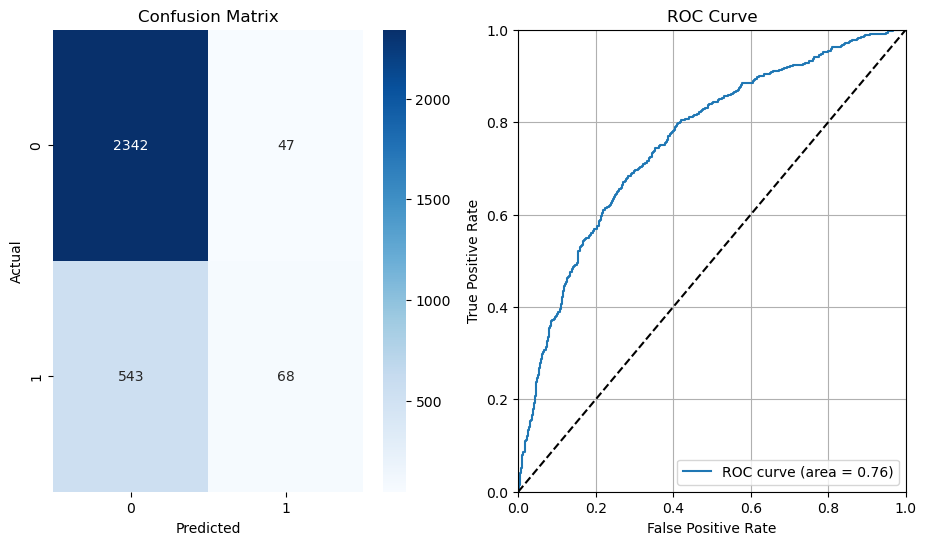

In [54]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_logistic_zscaled_surname, tpr_logistic_zscaled_surname, label=f'ROC curve (area = {auc_score_logistic_zscaled_surname:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##### Logistic Regression of Surname Vec - zscaled - SmoteNC

In [55]:
logistic_bs_cv = BayesSearchCV(
    LogisticRegression(),
    search_space_logistic,
    n_iter=n_iter_logistic,
    cv=5,
    random_state=random_state,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
)
logistic_bs_cv.fit(X_train_zscaled_namevec_smotenc, y_train_smotenc)
y_pred_logistic = logistic_bs_cv.predict(X_test_zscaled_namevec)
cm_logistic= confusion_matrix(y_test, y_pred_logistic)
fpr_logistic_zscaled_surname_smotenc, tpr_logistic_zscaled_surname_smotenc, _ = roc_curve(y_test, logistic_bs_cv.predict_proba(X_test_zscaled_namevec)[:, 1])
auc_score_logistic_zscaled_surname_smotenc = roc_auc_score(y_test, logistic_bs_cv.predict_proba(X_test_zscaled_namevec)[:, 1])
accuracy_logistic_zscaled_surname_smotenc = accuracy_score(y_test, y_pred_logistic)
TN_logistic_zscaled_surname_smotenc, FP_logistic_zscaled_surname_smotenc, FN_logistic_zscaled_surname_smotenc, TP_logistic_zscaled_surname_smotenc = cm_logistic.ravel()
fnr_rr_logistic_zscaled_surname_smotenc = FN_logistic_zscaled_surname_smotenc / (FN_logistic_zscaled_surname_smotenc + TP_logistic_zscaled_surname_smotenc)
tnr_rr_logistic_zscaled_surname_smotenc = TN_logistic_zscaled_surname_smotenc / (TN_logistic_zscaled_surname_smotenc + FP_logistic_zscaled_surname_smotenc)
print("Prediction Accuracy:", accuracy_logistic_zscaled_surname_smotenc)
print("Best parameters:", logistic_bs_cv.best_params_)


Prediction Accuracy: 0.682
Best parameters: OrderedDict([('C', 4.1842056808298445), ('max_iter', 609), ('penalty', 'l2'), ('solver', 'lbfgs')])


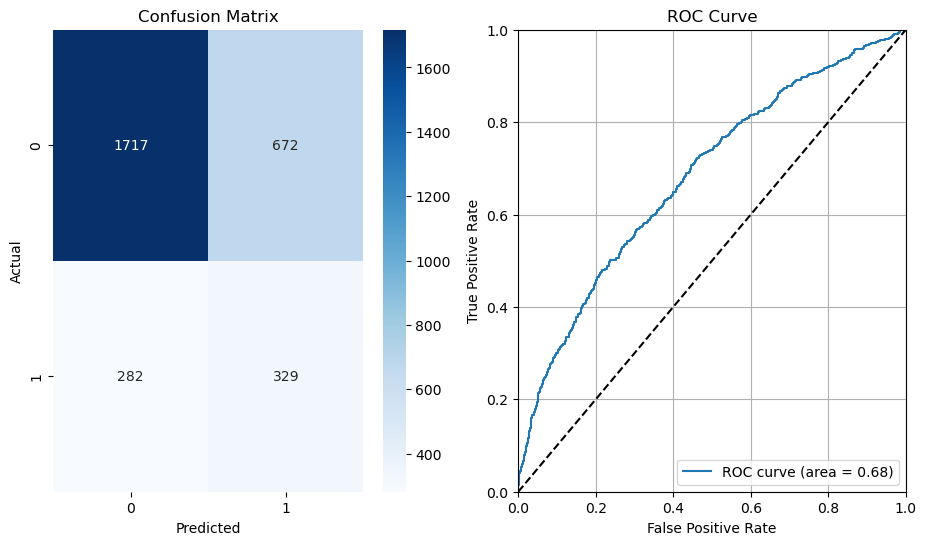

In [56]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_logistic, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_logistic_zscaled_surname_smotenc, tpr_logistic_zscaled_surname_smotenc, label=f'ROC curve (area = {auc_score_logistic_zscaled_surname_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Discriminant Analysis

In [57]:
search_spaces_lda = {'solver': Categorical(['svd', 'lsqr', 'eigen']),}
n_iter_ldaqda = 20 # since small search space, we can do less iterations

#### Linear Discriminant Analysis - minmax

In [58]:
lda_bs_cv = BayesSearchCV(LinearDiscriminantAnalysis(),
                          search_spaces_lda, 
                          n_iter=n_iter_ldaqda, 
                          cv=5, 
                          random_state=random_state, 
                          scoring="roc_auc",
                          n_jobs=-1,
                          verbose=0
                          )

lda_bs_cv.fit(X_train_minmax, y_train)
y_pred_lda = lda_bs_cv.predict(X_test_minmax)

fpr_lda_minmax, tpr_lda_minmax, _ = roc_curve(y_test, lda_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_lda_minmax = roc_auc_score(y_test, lda_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_lda_minmax = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)

TN_lda_minmax, FP_lda_minmax, FN_lda_minmax, TP_lda_minmax = cm_lda.ravel()
fnr_rr_lda_minmax = FN_lda_minmax / (FN_lda_minmax + TP_lda_minmax)
tnr_rr_lda_minmax = TN_lda_minmax / (TN_lda_minmax + FP_lda_minmax)

print("Prediction Accuracy for LDA:", accuracy_lda_minmax)
print("AUC Score for LDA:", auc_score_lda_minmax)

Prediction Accuracy for LDA: 0.8046666666666666
AUC Score for LDA: 0.761472899178518


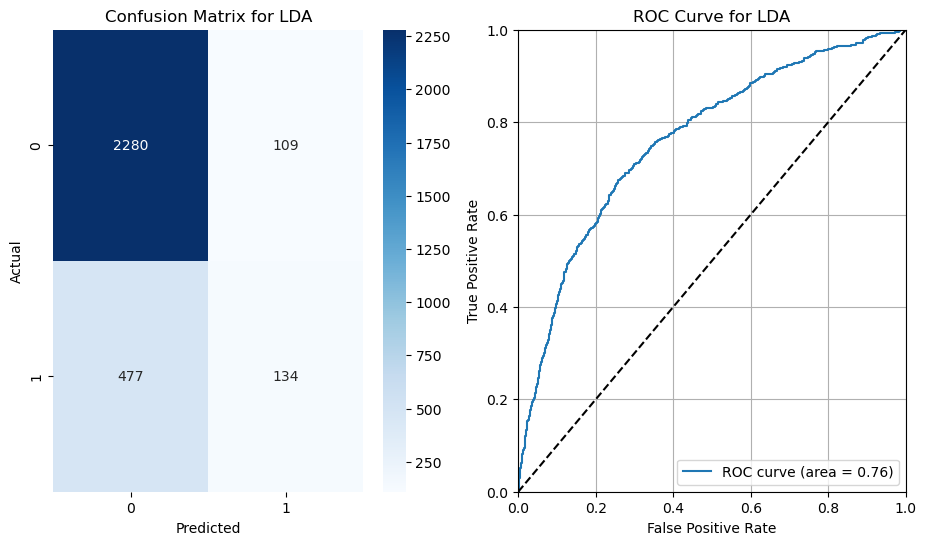

In [59]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_lda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_lda_minmax, tpr_lda_minmax, label=f'ROC curve (area = {auc_score_lda_minmax:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Linear Discriminant Analysis - zscaled

In [60]:
lda_bs_cv = BayesSearchCV(LinearDiscriminantAnalysis(),
                          search_spaces_lda, 
                          n_iter=n_iter_ldaqda, 
                          cv=5, 
                          random_state=random_state, 
                          scoring="roc_auc",
                          n_jobs=-1,
                          verbose=0
                          )
lda_bs_cv.fit(X_train_zscaled, y_train)
y_pred_lda_zscaled = lda_bs_cv.predict(X_test_zscaled)

fpr_lda_zscaled, tpr_lda_zscaled, _ = roc_curve(y_test, lda_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_lda_zscaled = roc_auc_score(y_test, lda_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_lda_zscaled = accuracy_score(y_test, y_pred_lda_zscaled)
cm_lda = confusion_matrix(y_test, y_pred_lda_zscaled)

TN_lda_zscaled, FP_lda_zscaled, FN_lda_zscaled, TP_lda_zscaled = cm_lda.ravel()
fnr_rr_lda_zscaled = FN_lda_zscaled / (FN_lda_zscaled + TP_lda_zscaled)
tnr_rr_lda_zscaled = TN_lda_zscaled / (TN_lda_zscaled + FP_lda_zscaled)

print("Prediction Accuracy for LDA:", accuracy_lda_zscaled)
print("AUC Score for LDA:", auc_score_lda_zscaled)

Prediction Accuracy for LDA: 0.8046666666666666
AUC Score for LDA: 0.761472899178518


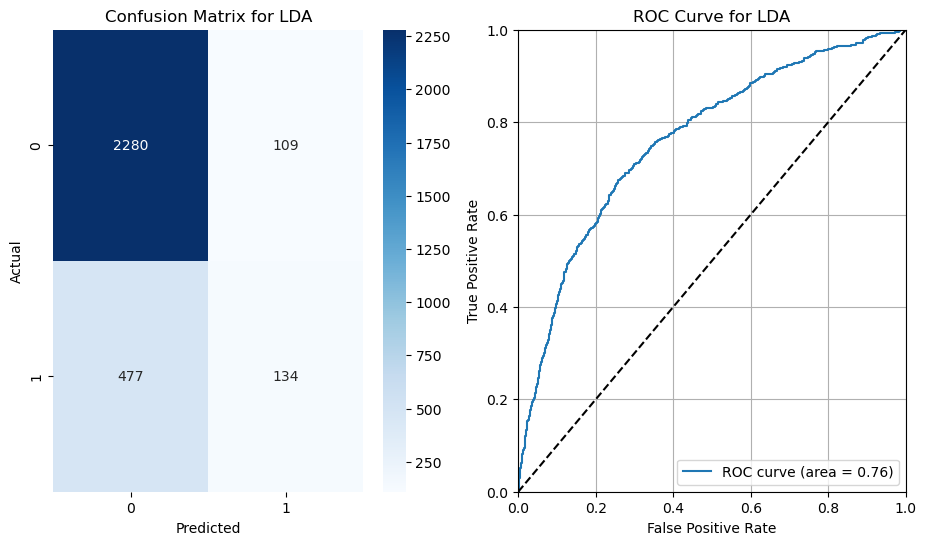

In [61]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_lda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve for LDA
plt.subplot(1, 2, 2)
plt.plot(fpr_lda_zscaled, tpr_lda_zscaled, label=f'ROC curve (area = {auc_score_lda_zscaled:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Linear Discriminant Analysis - minmax - SmoteNC

In [62]:
lda_bs_cv = BayesSearchCV(LinearDiscriminantAnalysis(),
                          search_spaces_lda, 
                          n_iter=n_iter_ldaqda, 
                          cv=5, 
                          random_state=random_state, 
                          scoring="roc_auc",
                          n_jobs=-1,
                          verbose=0
                          )
lda_bs_cv.fit(X_train_minmax_smotenc, y_train_smotenc)
y_pred_lda = lda_bs_cv.predict(X_test_minmax)

fpr_lda_minmax_smotenc, tpr_lda_minmax_smotenc, _ = roc_curve(y_test, lda_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_lda_minmax_smotenc = roc_auc_score(y_test, lda_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_lda_minmax_smotenc = accuracy_score(y_test, y_pred_lda)
cm_lda = confusion_matrix(y_test, y_pred_lda)

TN_lda_minmax_smotenc, FP_lda_minmax_smotenc, FN_lda_minmax_smotenc, TP_lda_minmax_smotenc = cm_lda.ravel()
fnr_rr_lda_minmax_smotenc = FN_lda_minmax_smotenc / (FN_lda_minmax_smotenc + TP_lda_minmax_smotenc)
tnr_rr_lda_minmax_smotenc = TN_lda_minmax_smotenc / (TN_lda_minmax_smotenc + FP_lda_minmax_smotenc)

print("Prediction Accuracy for LDA:", accuracy_lda_minmax_smotenc)
print("AUC Score for LDA:", auc_score_lda_minmax_smotenc)

Prediction Accuracy for LDA: 0.727
AUC Score for LDA: 0.7469087381540735


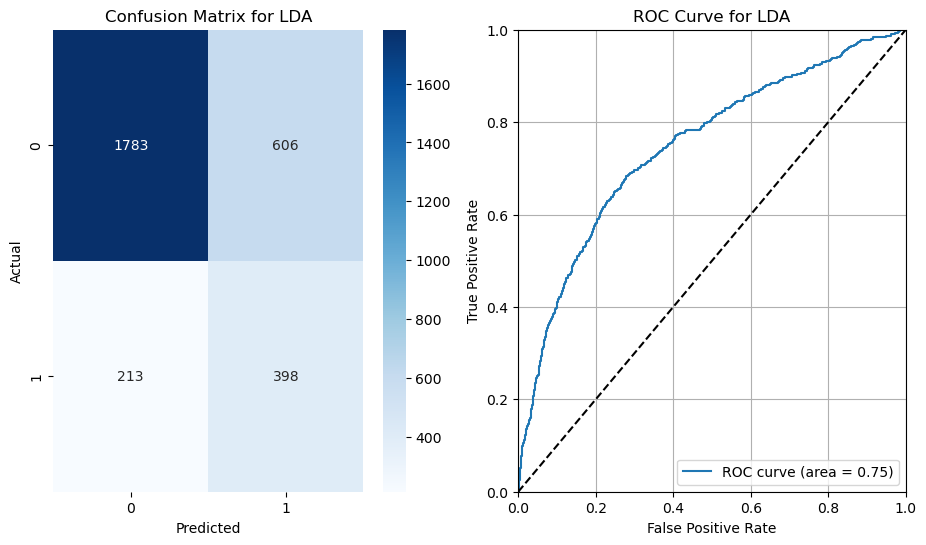

In [63]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_lda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_lda_minmax_smotenc, tpr_lda_minmax_smotenc, label=f'ROC curve (area = {auc_score_lda_minmax_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Linear Discriminant Analysis - zscaled - SmoteNC

In [64]:
lda_bs_cv = BayesSearchCV(LinearDiscriminantAnalysis(),
                          search_spaces_lda, 
                          n_iter=n_iter_ldaqda,
                          cv=5, 
                          random_state=random_state, 
                          scoring="roc_auc",
                          n_jobs=-1,
                          verbose=0
                          )
lda_bs_cv.fit(X_train_zscaled_smotenc, y_train_smotenc)
y_pred_lda_zscaled_smotenc = lda_bs_cv.predict(X_test_zscaled)

fpr_lda_zscaled_smotenc, tpr_lda_zscaled_smotenc, _ = roc_curve(y_test, lda_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_lda_zscaled_smotenc = roc_auc_score(y_test, lda_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_lda_zscaled_smotenc = accuracy_score(y_test, y_pred_lda_zscaled_smotenc)
cm_lda = confusion_matrix(y_test, y_pred_lda_zscaled_smotenc)

TN_lda_zscaled_smotenc, FP_lda_zscaled_smotenc, FN_lda_zscaled_smotenc, TP_lda_zscaled_smotenc = cm_lda.ravel()
fnr_rr_lda_zscaled_smotenc = FN_lda_zscaled_smotenc / (FN_lda_zscaled_smotenc + TP_lda_zscaled_smotenc)
tnr_rr_lda_zscaled_smotenc = TN_lda_zscaled_smotenc / (TN_lda_zscaled_smotenc + FP_lda_zscaled_smotenc)

print("Prediction Accuracy for LDA:", accuracy_lda_zscaled_smotenc)
print("AUC Score for LDA:", auc_score_lda_zscaled_smotenc)


Prediction Accuracy for LDA: 0.7283333333333334
AUC Score for LDA: 0.748576228061101


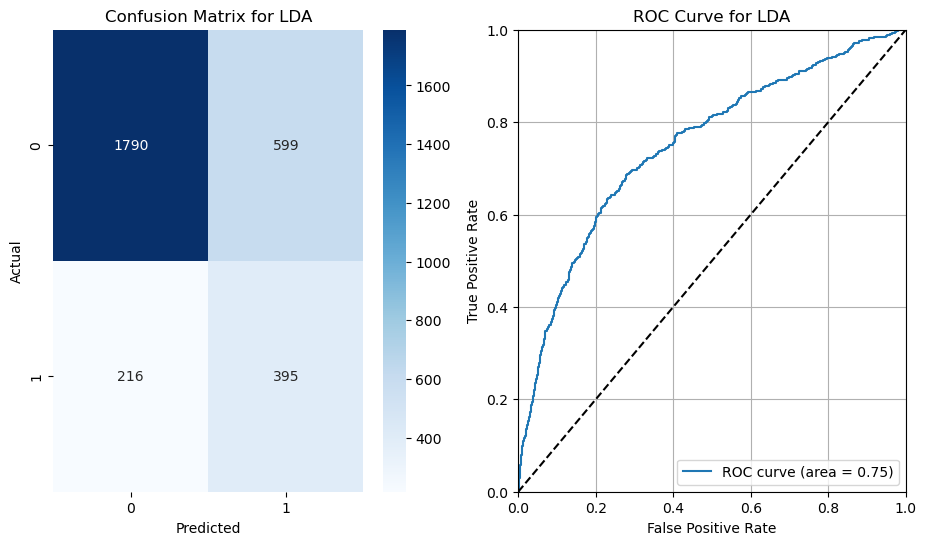

In [65]:

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_lda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for LDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# ROC Curve for LDA
plt.subplot(1, 2, 2)
plt.plot(fpr_lda_zscaled_smotenc, tpr_lda_zscaled_smotenc, label=f'ROC curve (area = {auc_score_lda_zscaled_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Quadratic Discriminant Analysis - minmax

In [66]:
search_space_qda = {"reg_param": Real(0, 1, prior='uniform')} 
n_iter_ldaqda = 20 # since small search space, we can do less iterations

In [67]:
qda_minmax_bs_cv = BayesSearchCV(QuadraticDiscriminantAnalysis(), search_space_qda, 
                          n_iter=n_iter_ldaqda, cv=5, random_state=random_state, scoring='roc_auc', n_jobs=-1)
qda_minmax_bs_cv.fit(X_train_minmax, y_train)
y_pred_qda_minmax = qda_minmax_bs_cv.predict(X_test_minmax)

fpr_qda_minmax, tpr_qda_minmax, _ = roc_curve(y_test, qda_minmax_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_qda_minmax = roc_auc_score(y_test, qda_minmax_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_qda_minmax = accuracy_score(y_test, y_pred_qda_minmax)
cm_qda = confusion_matrix(y_test, y_pred_qda_minmax)

TN_qda_minmax, FP_qda_minmax, FN_qda_minmax, TP_qda_minmax = cm_qda.ravel()
fnr_rr_qda_minmax = FN_qda_minmax / (FN_qda_minmax + TP_qda_minmax)
tnr_rr_qda_minmax = TN_qda_minmax / (TN_qda_minmax + FP_qda_minmax)

print("Prediction Accuracy for QDA:", accuracy_qda_minmax)
print("AUC Score for QDA:", auc_score_qda_minmax)



Prediction Accuracy for QDA: 0.8126666666666666
AUC Score for QDA: 0.7881849365511184


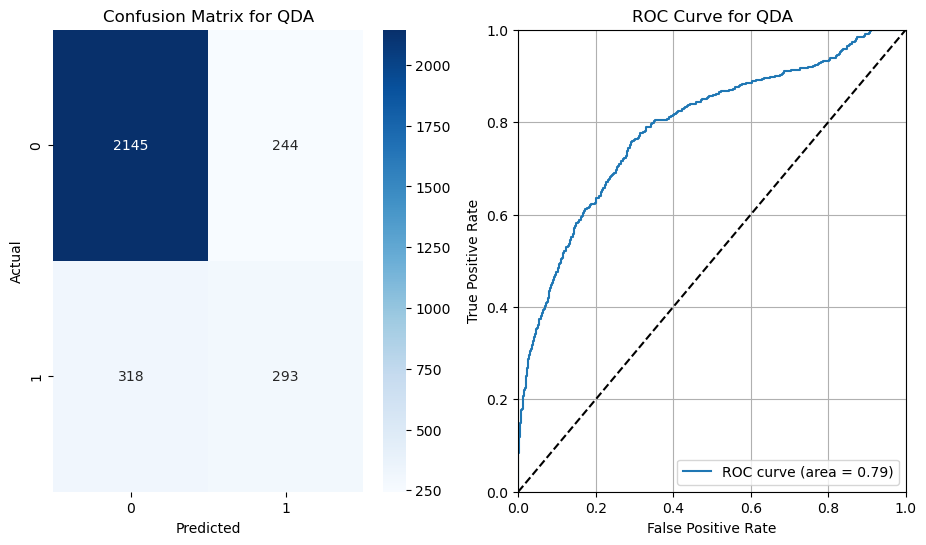

In [68]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_qda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for QDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_qda_minmax, tpr_qda_minmax, label=f'ROC curve (area = {auc_score_qda_minmax:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for QDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Quadratic Discriminant Analysis - zscaled

In [69]:
qda_zcaled_bs_cv = BayesSearchCV(QuadraticDiscriminantAnalysis(), search_space_qda, 
                          n_iter=n_iter_ldaqda, cv=5, random_state=random_state, scoring='roc_auc', n_jobs=-1)
qda_zcaled_bs_cv.fit(X_train_zscaled, y_train)
y_pred_qda_zscaled = qda_zcaled_bs_cv.predict(X_test_zscaled)

fpr_qda_zscaled, tpr_qda_zscaled, _ = roc_curve(y_test, qda_zcaled_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_qda_zscaled = roc_auc_score(y_test, qda_zcaled_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_qda_zscaled = accuracy_score(y_test, y_pred_qda_zscaled)
cm_qda = confusion_matrix(y_test, y_pred_qda_zscaled)

TN_qda_zscaled, FP_qda_zscaled, FN_qda_zscaled, TP_qda_zscaled = cm_qda.ravel()
fnr_rr_qda_zscaled = FN_qda_zscaled / (FN_qda_zscaled + TP_qda_zscaled)
tnr_rr_qda_zscaled = TN_qda_zscaled / (TN_qda_zscaled + FP_qda_zscaled)


print("Prediction Accuracy for QDA:", accuracy_qda_zscaled)
print("AUC Score for QDA:", auc_score_qda_zscaled)


Prediction Accuracy for QDA: 0.8366666666666667
AUC Score for QDA: 0.8150840013455014


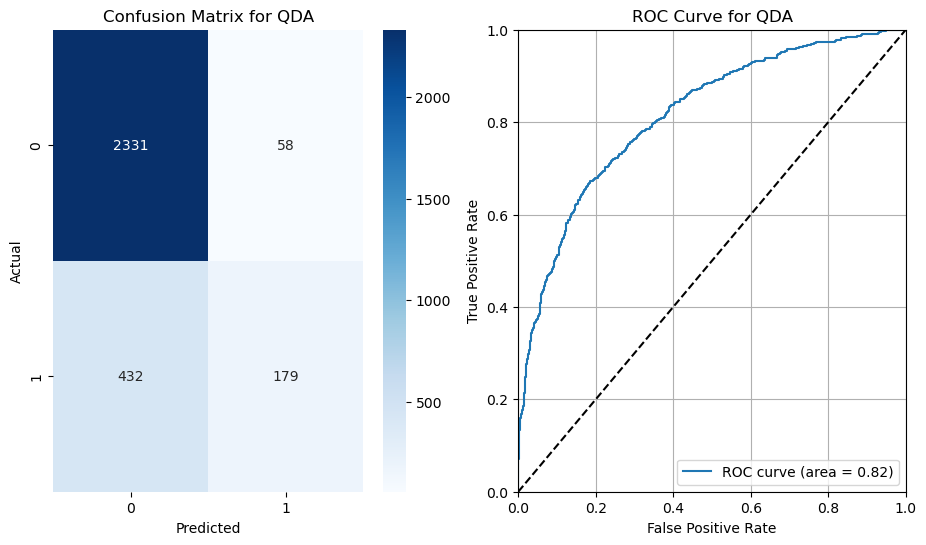

In [70]:

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_qda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for QDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_qda_zscaled, tpr_qda_zscaled, label=f'ROC curve (area = {auc_score_qda_zscaled:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for QDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Quadratic Discriminant Analysis - minmax - SmoteNC

In [71]:
qda_minmax_smotenc_bs_cv = BayesSearchCV(QuadraticDiscriminantAnalysis(), search_space_qda, 
                          n_iter=n_iter_ldaqda, cv=5, random_state=random_state, scoring='roc_auc', n_jobs=-1, verbose=0)
qda_minmax_smotenc_bs_cv.fit(X_train_minmax_smotenc, y_train_smotenc)
y_pred_qda_minmax_smotenc = qda_minmax_smotenc_bs_cv.predict(X_test_minmax)

fpr_qda_minmax_smotenc, tpr_qda_minmax_smotenc, _ = roc_curve(y_test, qda_minmax_smotenc_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_qda_minmax_smotenc = roc_auc_score(y_test, qda_minmax_smotenc_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_qda_minmax_smotenc = accuracy_score(y_test, y_pred_qda_minmax_smotenc)
cm_qda_smotenc = confusion_matrix(y_test, y_pred_qda_minmax_smotenc)

TN_qda_minmax_smotenc, FP_qda_minmax_smotenc, FN_qda_minmax_smotenc, TP_qda_minmax_smotenc = cm_qda_smotenc.ravel()
fnr_rr_qda_minmax_smotenc = FN_qda_minmax_smotenc / (FN_qda_minmax_smotenc + TP_qda_minmax_smotenc)
tnr_rr_qda_minmax_smotenc = TN_qda_minmax_smotenc / (TN_qda_minmax_smotenc + FP_qda_minmax_smotenc)

print("Prediction Accuracy for QDA:", accuracy_qda_minmax_smotenc)
print("AUC Score for QDA:", auc_score_qda_minmax_smotenc)


Prediction Accuracy for QDA: 0.7066666666666667
AUC Score for QDA: 0.7471608483783079


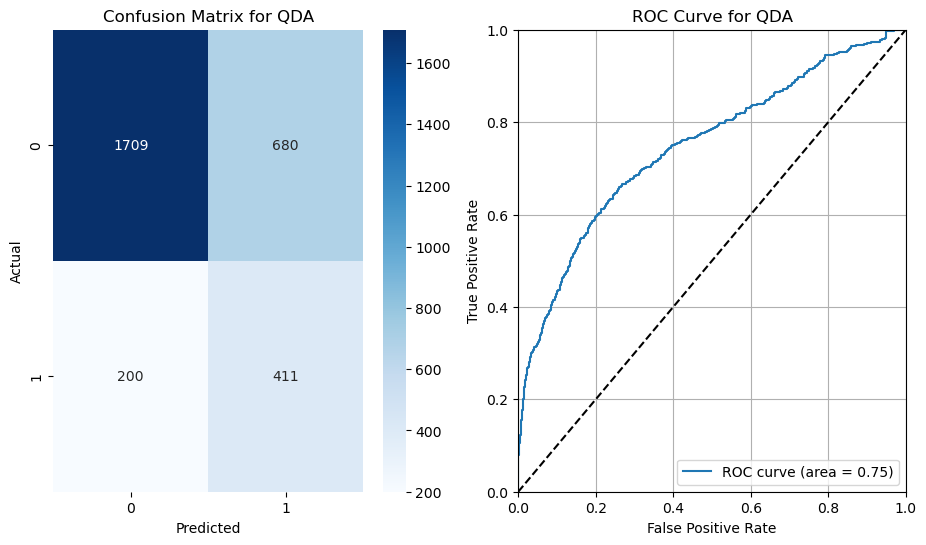

In [72]:

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_qda_smotenc, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for QDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_qda_minmax_smotenc, tpr_qda_minmax_smotenc, label=f'ROC curve (area = {auc_score_qda_minmax_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for QDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Quadratic Discriminant Analysis - zscaled - SmoteNC

In [73]:
qda_zscaled_smotenc_bs_cv = BayesSearchCV(QuadraticDiscriminantAnalysis(), search_space_qda, 
                          n_iter=n_iter_ldaqda, cv=5, random_state=random_state, scoring='roc_auc', n_jobs=-1)
qda_zscaled_smotenc_bs_cv.fit(X_train_zscaled_smotenc, y_train_smotenc)
y_pred_qda_zscaled_smotenc = qda_zscaled_smotenc_bs_cv.predict(X_test_zscaled)

fpr_qda_zscaled_smotenc, tpr_qda_zscaled_smotenc, _ = roc_curve(y_test, qda_zscaled_smotenc_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_qda_zscaled_smotenc = roc_auc_score(y_test, qda_zscaled_smotenc_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_qda_zscaled_smotenc = accuracy_score(y_test, y_pred_qda_zscaled_smotenc)
cm_qda = confusion_matrix(y_test, y_pred_qda_zscaled_smotenc)

TN_qda_zscaled_smotenc, FP_qda_zscaled_smotenc, FN_qda_zscaled_smotenc, TP_qda_zscaled_smotenc = cm_qda.ravel()
fnr_rr_qda_zscaled_smotenc = FN_qda_zscaled_smotenc / (FN_qda_zscaled_smotenc + TP_qda_zscaled_smotenc)
tnr_rr_qda_zscaled_smotenc = TN_qda_zscaled_smotenc / (TN_qda_zscaled_smotenc + FP_qda_zscaled_smotenc)

print("Prediction Accuracy for QDA:", accuracy_qda_zscaled_smotenc)
print("AUC Score for QDA:", auc_score_qda_zscaled_smotenc)


Prediction Accuracy for QDA: 0.742
AUC Score for QDA: 0.8043508195980076


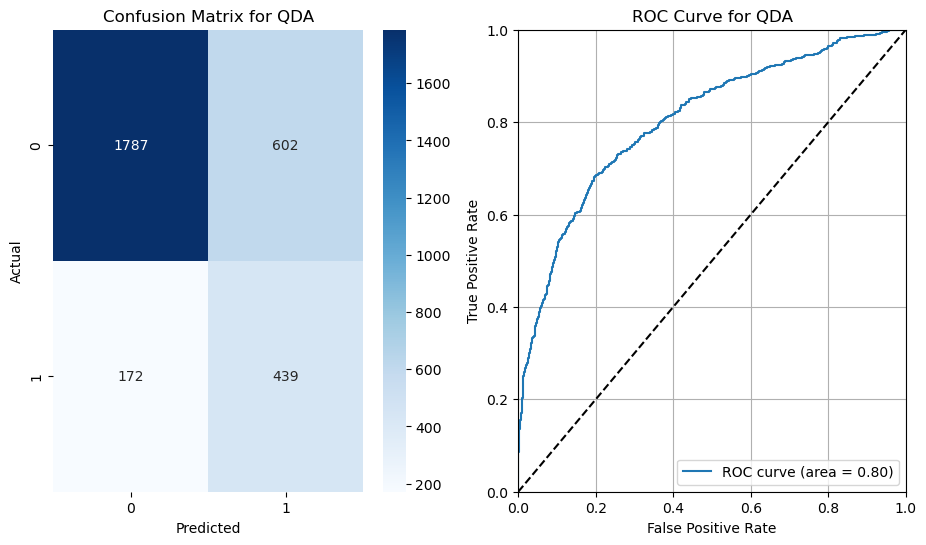

In [74]:

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_qda, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for QDA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_qda_zscaled_smotenc, tpr_qda_zscaled_smotenc, label=f'ROC curve (area = {auc_score_qda_zscaled_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for QDA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Non-parametric Models

### SVM

In [75]:
search_space_svm = {
    'C': Real(1e-2, 1e+3, prior='log-uniform'),  
    'kernel': Categorical(['poly', 'rbf']),      
    'gamma': Categorical(['scale', 'auto']),     
    'degree': Integer(2, 4) }
n_iter_svm = 25 # balance computation time and performance

#### SVM - minmax 

In [76]:
svm_bs_cv = BayesSearchCV(SVC(probability=True), search_space_svm, 
                          n_iter=n_iter_svm, cv=5, random_state=random_state, scoring="roc_auc", n_jobs=-1, 
                          verbose=0)
svm_bs_cv.fit(X_train_minmax, y_train)

y_pred_svm = svm_bs_cv.predict(X_test_minmax)
cm_svm = confusion_matrix(y_test, y_pred_svm)
fpr_svm_minmax, tpr_svm_minmax, _ = roc_curve(y_test, svm_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_svm_minmax = roc_auc_score(y_test, svm_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_svm_minmax = accuracy_score(y_test, y_pred_svm)

TN_svm_minmax, FP_svm_minmax, FN_svm_minmax, TP_svm_minmax = cm_svm.ravel()
fnr_rr_svm_minmax = FN_svm_minmax / (FN_svm_minmax + TP_svm_minmax)
tnr_rr_svm_minmax = TN_svm_minmax / (TN_svm_minmax + FP_svm_minmax)

print("Prediction Accuracy:", accuracy_svm_minmax)
print("Best parameters:", svm_bs_cv.best_params_)


Prediction Accuracy: 0.8523333333333334
Best parameters: OrderedDict([('C', 1000.0), ('degree', 2), ('gamma', 'scale'), ('kernel', 'poly')])


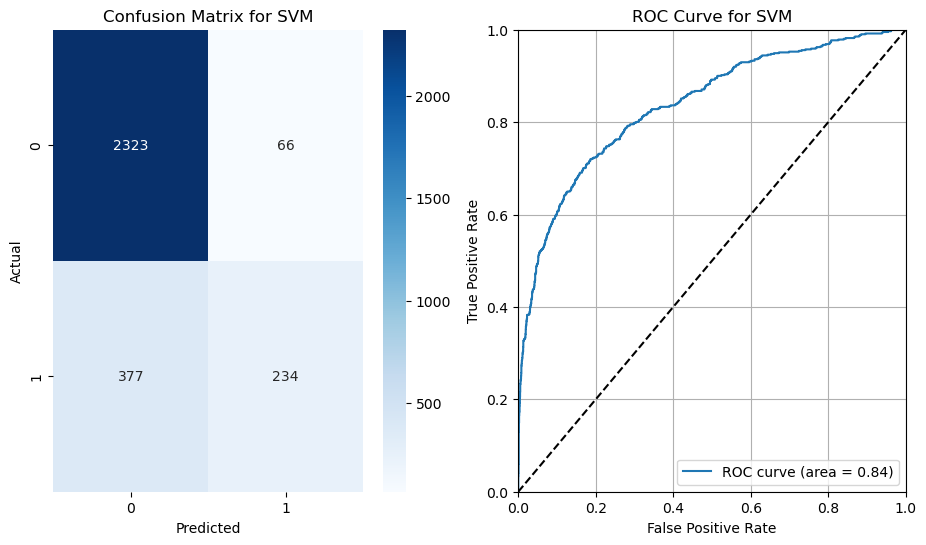

In [77]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_svm_minmax, tpr_svm_minmax, label=f'ROC curve (area = {auc_score_svm_minmax:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### SVM - zscaled

In [78]:
svm_bs_cv = BayesSearchCV(SVC(probability=True), search_space_svm, 
                          n_iter=n_iter_svm, cv=5, random_state=random_state, scoring="roc_auc", n_jobs=-1, 
                          verbose=0)
svm_bs_cv.fit(X_train_zscaled, y_train)

y_pred_svm = svm_bs_cv.predict(X_test_zscaled)
cm_svm = confusion_matrix(y_test, y_pred_svm)
fpr_svm_zscaled, tpr_svm_zscaled, _ = roc_curve(y_test, svm_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_svm_zscaled = roc_auc_score(y_test, svm_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_svm_zscaled = accuracy_score(y_test, y_pred_svm)

TN_svm_zscaled, FP_svm_zscaled, FN_svm_zscaled, TP_svm_zscaled = cm_svm.ravel()
fnr_rr_svm_zscaled = FN_svm_zscaled / (FN_svm_zscaled + TP_svm_zscaled)
tnr_rr_svm_zscaled = TN_svm_zscaled / (TN_svm_zscaled + FP_svm_zscaled)

print("Prediction Accuracy:", accuracy_svm_zscaled)
print("Best parameters:", svm_bs_cv.best_params_)

Prediction Accuracy: 0.857
Best parameters: OrderedDict([('C', 0.8523431138590406), ('degree', 4), ('gamma', 'auto'), ('kernel', 'rbf')])


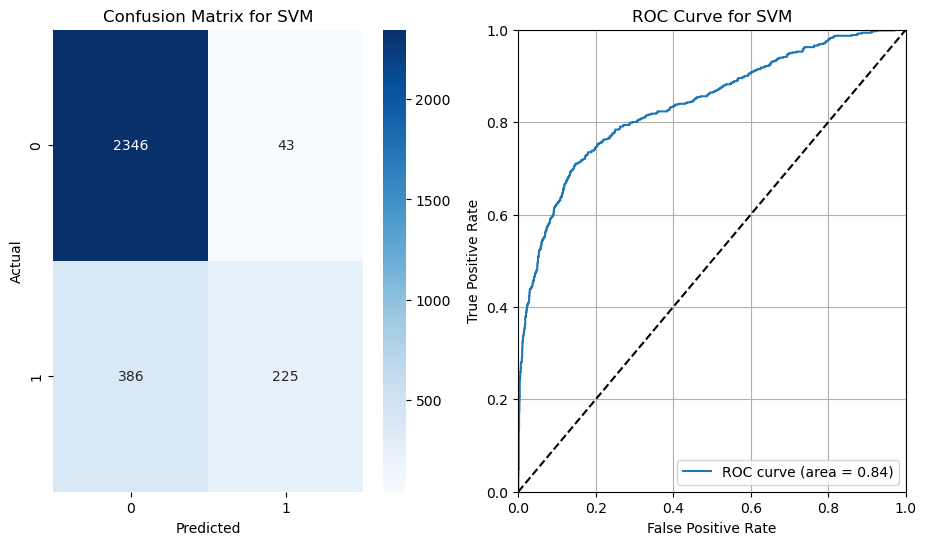

In [79]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_svm_zscaled, tpr_svm_zscaled, label=f'ROC curve (area = {auc_score_svm_zscaled:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### SVM - minmax - SmoteNC

In [80]:
svm_bs_cv = BayesSearchCV(SVC(probability=True), search_space_svm, 
                          n_iter=n_iter_svm, cv=5, random_state=random_state, scoring="roc_auc", n_jobs=-1, 
                          verbose=0)
svm_bs_cv.fit(X_train_minmax_smotenc, y_train_smotenc)

y_pred_svm = svm_bs_cv.predict(X_test_minmax)
cm_svm = confusion_matrix(y_test, y_pred_svm)
fpr_svm_minmax_smotenc, tpr_svm_minmax_smotenc, _ = roc_curve(y_test, svm_bs_cv.predict_proba(X_test_minmax)[:, 1])
auc_score_svm_minmax_smotenc = roc_auc_score(y_test, svm_bs_cv.predict_proba(X_test_minmax)[:, 1])
accuracy_svm_minmax_smotenc = accuracy_score(y_test, y_pred_svm)

TN_svm_minmax_smotenc, FP_svm_minmax_smotenc, FN_svm_minmax_smotenc, TP_svm_minmax_smotenc = cm_svm.ravel()
fnr_rr_svm_minmax_smotenc = FN_svm_minmax_smotenc / (FN_svm_minmax_smotenc + TP_svm_minmax_smotenc)
tnr_rr_svm_minmax_smotenc = TN_svm_minmax_smotenc / (TN_svm_minmax_smotenc + FP_svm_minmax_smotenc)

print("Prediction Accuracy:", accuracy_svm_minmax_smotenc)
print("Best parameters:", svm_bs_cv.best_params_)

Prediction Accuracy: 0.8016666666666666
Best parameters: OrderedDict([('C', 60.56898165286246), ('degree', 4), ('gamma', 'scale'), ('kernel', 'rbf')])


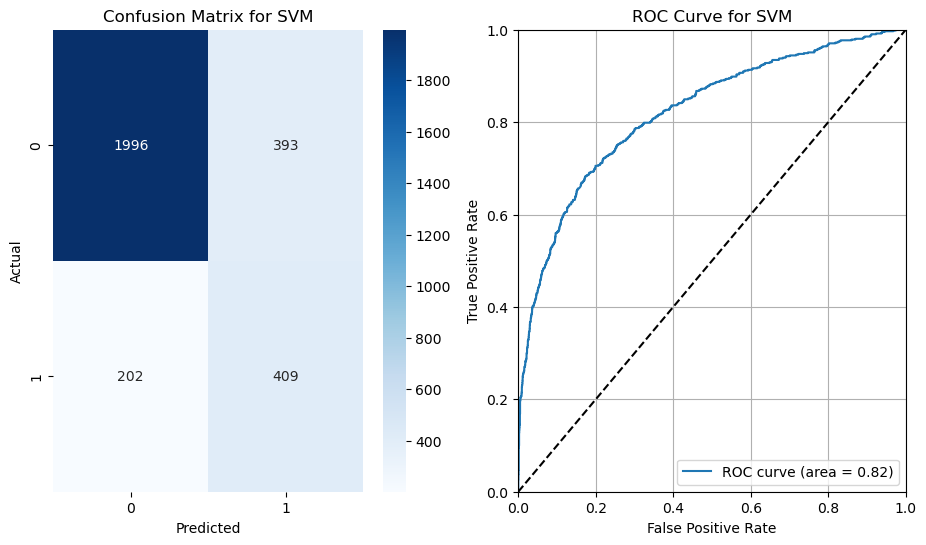

In [81]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_svm_minmax_smotenc, tpr_svm_minmax_smotenc, label=f'ROC curve (area = {auc_score_svm_minmax_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### SVM - zscaled - SmoteNC

In [82]:
svm_bs_cv = BayesSearchCV(SVC(probability=True), search_space_svm, 
                          n_iter=n_iter_svm, cv=5, random_state=random_state, scoring="roc_auc", n_jobs=-1, 
                          verbose=0)
svm_bs_cv.fit(X_train_zscaled_smotenc, y_train_smotenc)

y_pred_svm = svm_bs_cv.predict(X_test_zscaled)
cm_svm = confusion_matrix(y_test, y_pred_svm)
fpr_svm_zscaled_smotenc, tpr_svm_zscaled_smotenc, _ = roc_curve(y_test, svm_bs_cv.predict_proba(X_test_zscaled)[:, 1])
auc_score_svm_zscaled_smotenc = roc_auc_score(y_test, svm_bs_cv.predict_proba(X_test_zscaled)[:, 1])
accuracy_svm_zscaled_smotenc = accuracy_score(y_test, y_pred_svm)

TN_svm_zscaled_smotenc, FP_svm_zscaled_smotenc, FN_svm_zscaled_smotenc, TP_svm_zscaled_smotenc = cm_svm.ravel()
fnr_rr_svm_zscaled_smotenc = FN_svm_zscaled_smotenc / (FN_svm_zscaled_smotenc + TP_svm_zscaled_smotenc)
tnr_rr_svm_zscaled_smotenc = TN_svm_zscaled_smotenc / (TN_svm_zscaled_smotenc + FP_svm_zscaled_smotenc)

print("Prediction Accuracy:", accuracy_svm_zscaled_smotenc)
print("Best parameters:", svm_bs_cv.best_params_)

Prediction Accuracy: 0.8016666666666666
Best parameters: OrderedDict([('C', 82.67586283079879), ('degree', 4), ('gamma', 'scale'), ('kernel', 'rbf')])


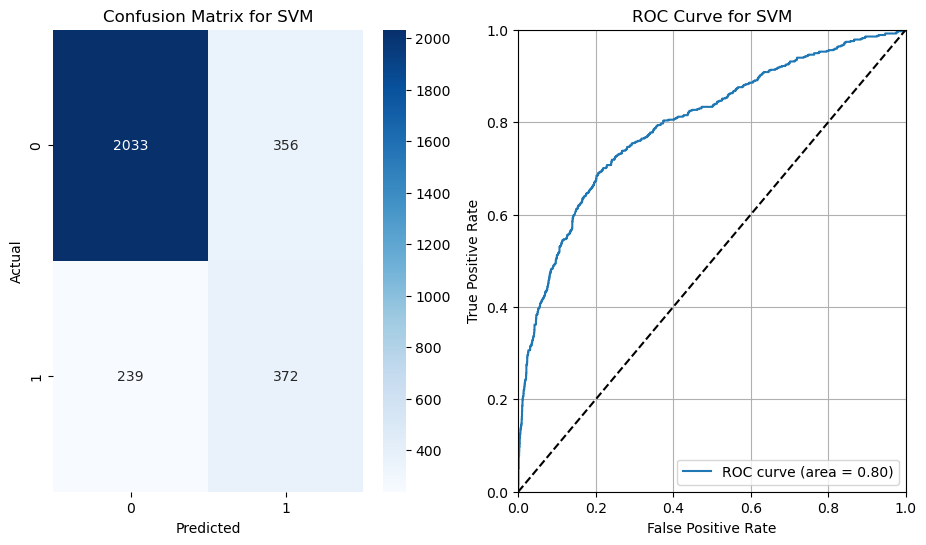

In [83]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_svm_zscaled_smotenc, tpr_svm_zscaled_smotenc, label=f'ROC curve (area = {auc_score_svm_zscaled_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Tree Based Model

#### Classification Tree

In [84]:
search_space_tree = {
    'max_depth': Integer(3, 30),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2']
}
n_iter_tree = 75

##### Classification Tree 

In [85]:
tree_clf = DecisionTreeClassifier(random_state=random_state)

tree_clf_bs_cv = BayesSearchCV(tree_clf, search_space_tree, n_iter=n_iter_tree, scoring='roc_auc', n_jobs=-1, cv=5, random_state=random_state)
tree_clf_bs_cv.fit(X_train_trees, y_train)

best_tree_clf = tree_clf_bs_cv.best_estimator_
y_pred_tree = best_tree_clf.predict(X_test_trees)

accuracy_tree = accuracy_score(y_test, y_pred_tree)
fpr_tree, tpr_tree, _ = roc_curve(y_test, best_tree_clf.predict_proba(X_test_trees)[:, 1])
auc_score_tree = roc_auc_score(y_test, best_tree_clf.predict_proba(X_test_trees)[:, 1])
cm_tree = confusion_matrix(y_test, y_pred_tree)

TN_tree, FP_tree, FN_tree, TP_tree = cm_tree.ravel()
fnr_rr_tree = FN_tree / (FN_tree + TP_tree)
tnr_rr_tree = TN_tree / (TN_tree + FP_tree)

print("Best parameters found: ", tree_clf_bs_cv.best_params_)
print("Prediction Accuracy for Decision Tree:", accuracy_tree)
print("AUC Score for Decision Tree:", auc_score_tree)




Best parameters found:  OrderedDict([('criterion', 'entropy'), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 100)])
Prediction Accuracy for Decision Tree: 0.8403333333333334
AUC Score for Decision Tree: 0.8158728734194299


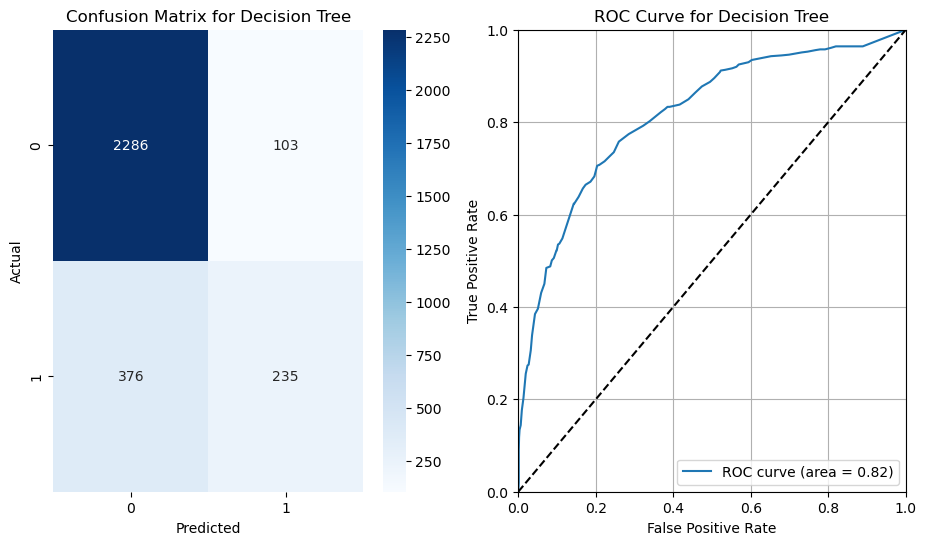

In [86]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_tree, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_tree, tpr_tree, label=f'ROC curve (area = {auc_score_tree:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

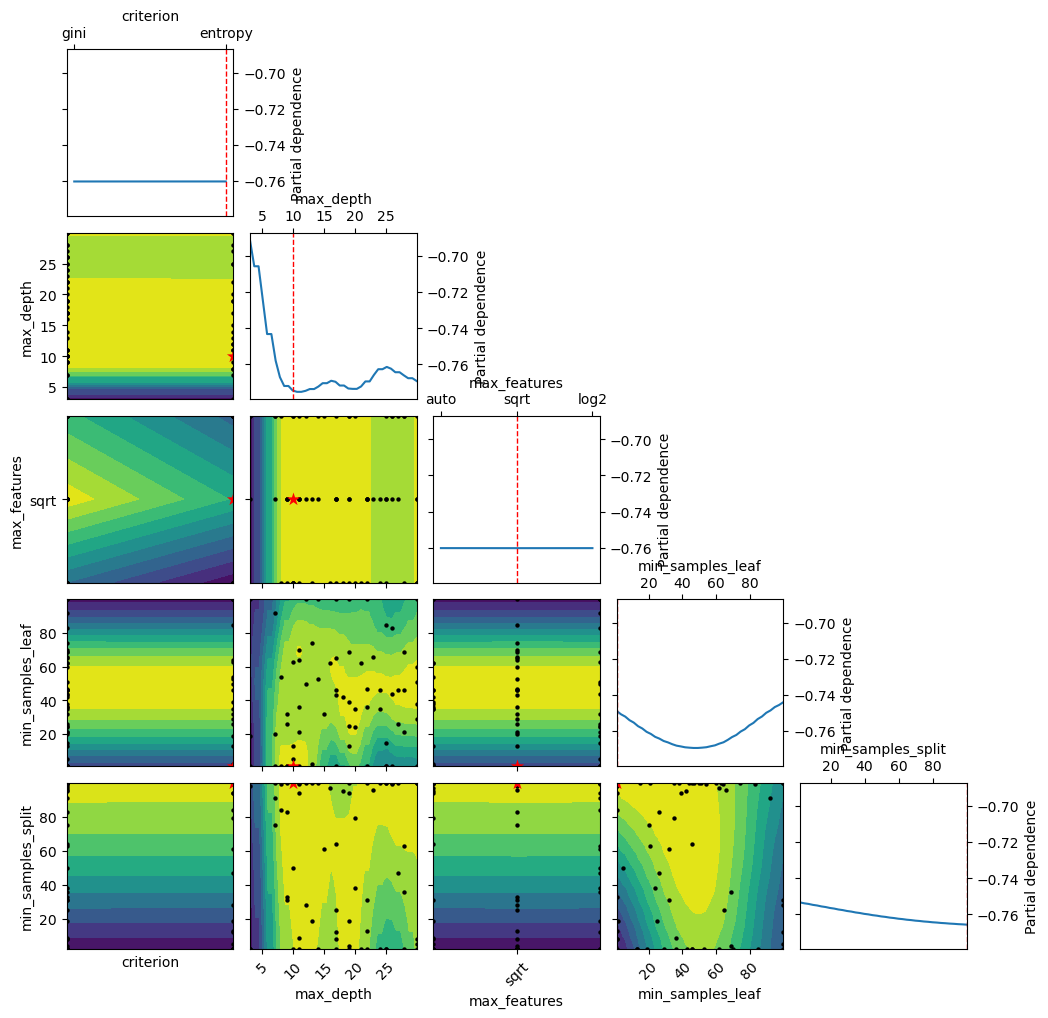

In [87]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    tree_clf_bs_cv.optimizer_results_[0],
    dimensions=list(tree_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### Classification Tree - SmoteNC

In [88]:
tree_clf = DecisionTreeClassifier(random_state=random_state)

tree_clf_bs_cv = BayesSearchCV(tree_clf, search_space_tree, n_iter=n_iter_tree, scoring='roc_auc', n_jobs=-1, cv=5, random_state=random_state)
tree_clf_bs_cv.fit(X_train_trees_smotenc, y_train_smotenc)

best_tree_clf_smotenc = tree_clf_bs_cv.best_estimator_
y_pred_tree_smotenc = best_tree_clf_smotenc.predict(X_test_trees)

accuracy_tree_smotenc = accuracy_score(y_test, y_pred_tree_smotenc)
fpr_tree_smotenc, tpr_tree_smotenc, _ = roc_curve(y_test, best_tree_clf_smotenc.predict_proba(X_test_trees)[:, 1])
auc_score_tree_smotenc = roc_auc_score(y_test, best_tree_clf_smotenc.predict_proba(X_test_trees)[:, 1])
cm_tree_smotenc = confusion_matrix(y_test, y_pred_tree_smotenc)

TN_tree_smotenc, FP_tree_smotenc, FN_tree_smotenc, TP_tree_smotenc = cm_tree_smotenc.ravel()
fnr_rr_tree_smotenc = FN_tree_smotenc / (FN_tree_smotenc + TP_tree_smotenc)
tnr_rr_tree_smotenc = TN_tree_smotenc / (TN_tree_smotenc + FP_tree_smotenc)

print("Best parameters found: ", tree_clf_bs_cv.best_params_)
print("Prediction Accuracy for Decision Tree:", accuracy_tree_smotenc)
print("AUC Score for Decision Tree:", auc_score_tree_smotenc)



Best parameters found:  OrderedDict([('criterion', 'entropy'), ('max_depth', 13), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 28)])
Prediction Accuracy for Decision Tree: 0.759
AUC Score for Decision Tree: 0.7873114568340025


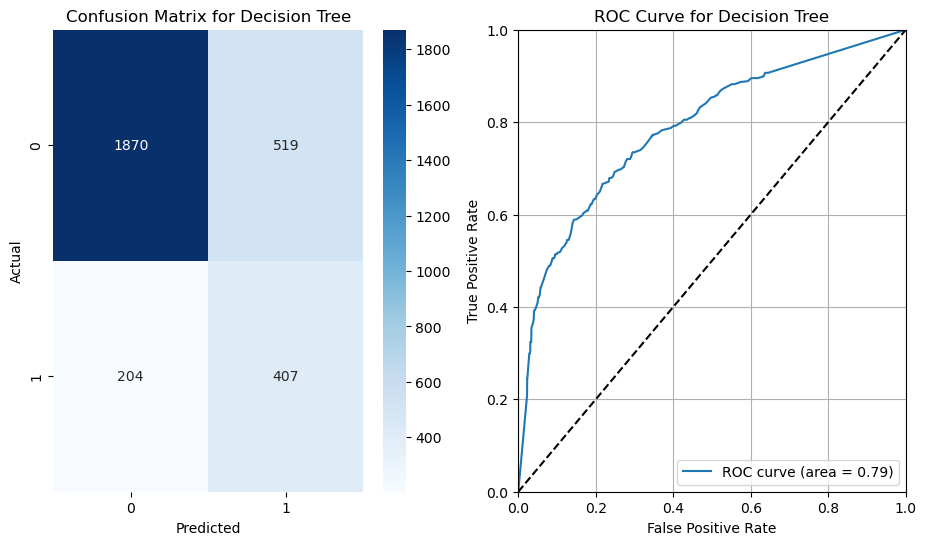

In [89]:

plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_tree_smotenc, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_tree_smotenc, tpr_tree_smotenc, label=f'ROC curve (area = {auc_score_tree_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

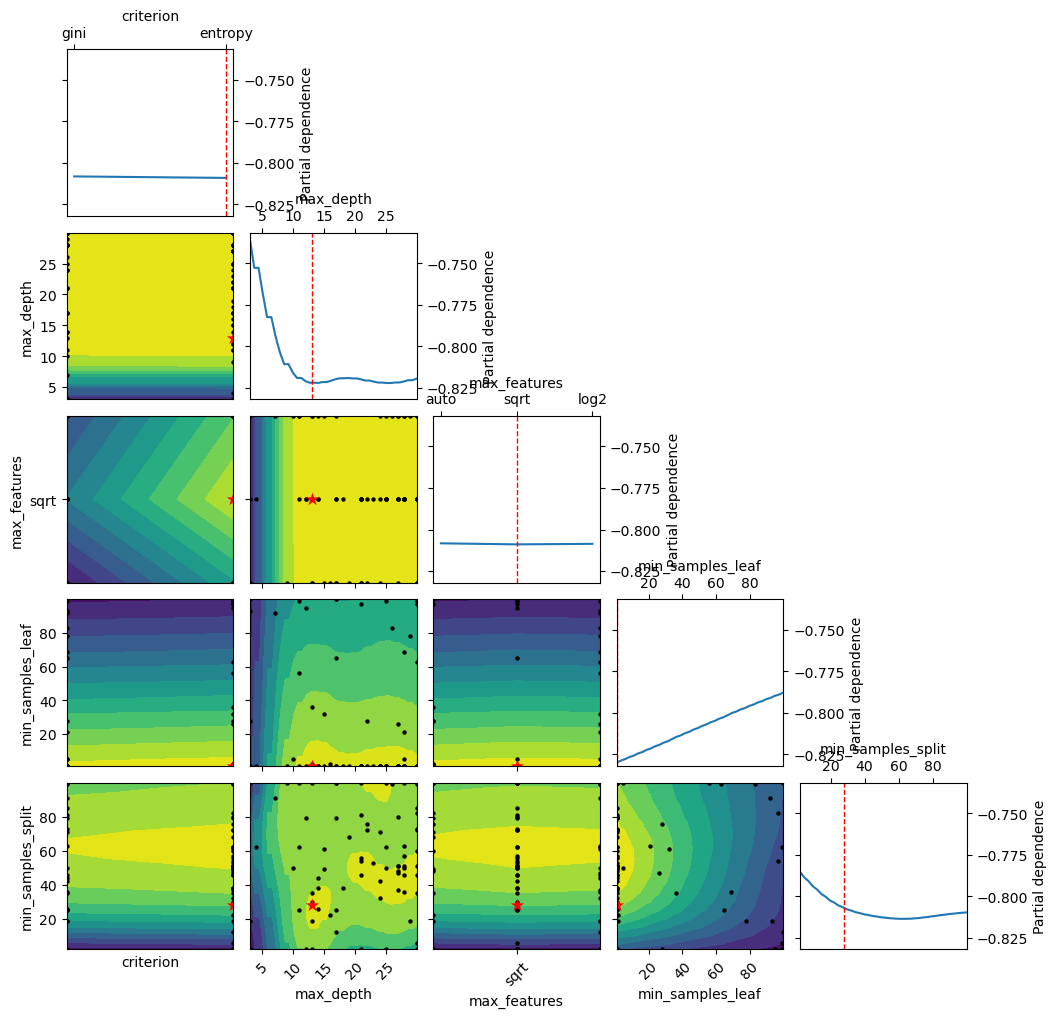

In [90]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    tree_clf_bs_cv.optimizer_results_[0],
    dimensions=list(tree_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

#### Random Forest Classifier

In [91]:
search_space_rf = {
    'n_estimators': Integer(100, 1000), 
    'max_depth': Integer(3, 30),  
    'min_samples_split': Integer(2, 100),  
    'min_samples_leaf': Integer(1, 100),  
    'criterion': ['gini', 'entropy'],  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False]  
}
n_iter_rf = 75

##### Random Forest Classifier

In [92]:
rf = RandomForestClassifier(random_state=random_state)

rf_bs_cv = BayesSearchCV(rf, search_space_rf, n_iter=n_iter_rf, scoring='roc_auc', n_jobs=-1, cv=5, random_state=random_state)
rf_bs_cv.fit(X_train_trees, y_train)

best_rf = rf_bs_cv.best_estimator_
y_pred_rf = best_rf.predict(X_test_trees)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test_trees)[:, 1])
auc_score_rf = roc_auc_score(y_test, best_rf.predict_proba(X_test_trees)[:, 1])
cm_rf = confusion_matrix(y_test, y_pred_rf)

TN_rf, FP_rf, FN_rf, TP_rf = cm_rf.ravel()
fnr_rr_rf = FN_rf / (FN_rf + TP_rf)
tnr_rr_rf = TN_rf / (TN_rf + FP_rf)

print("Best parameters found for Random Forest: ", rf_bs_cv.best_params_)
print("Prediction Accuracy for Random Forest:", accuracy_rf)
print("AUC Score for Random Forest:", auc_score_rf)


Best parameters found for Random Forest:  OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 22), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 66), ('n_estimators', 168)])
Prediction Accuracy for Random Forest: 0.8603333333333333
AUC Score for Random Forest: 0.8625718394249695


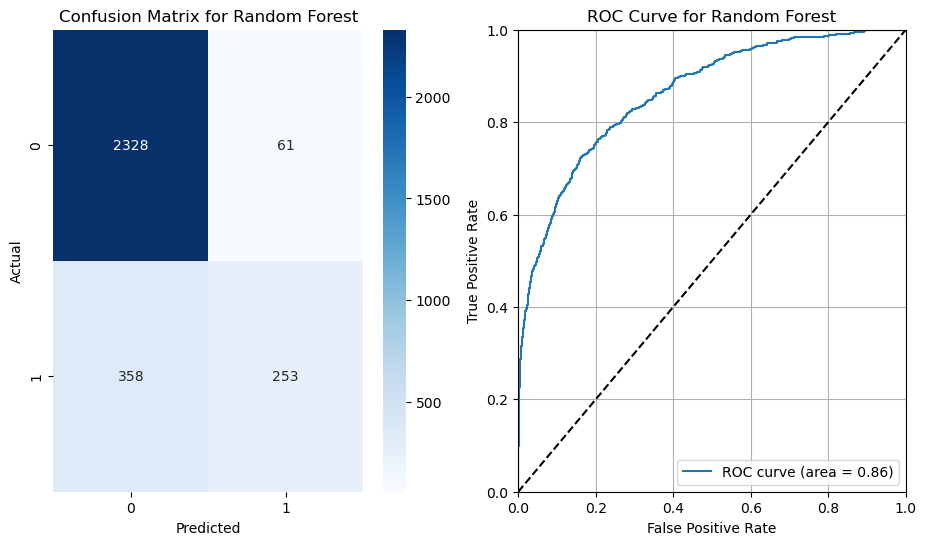

In [93]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_rf, tpr_rf, label=f'ROC curve (area = {auc_score_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

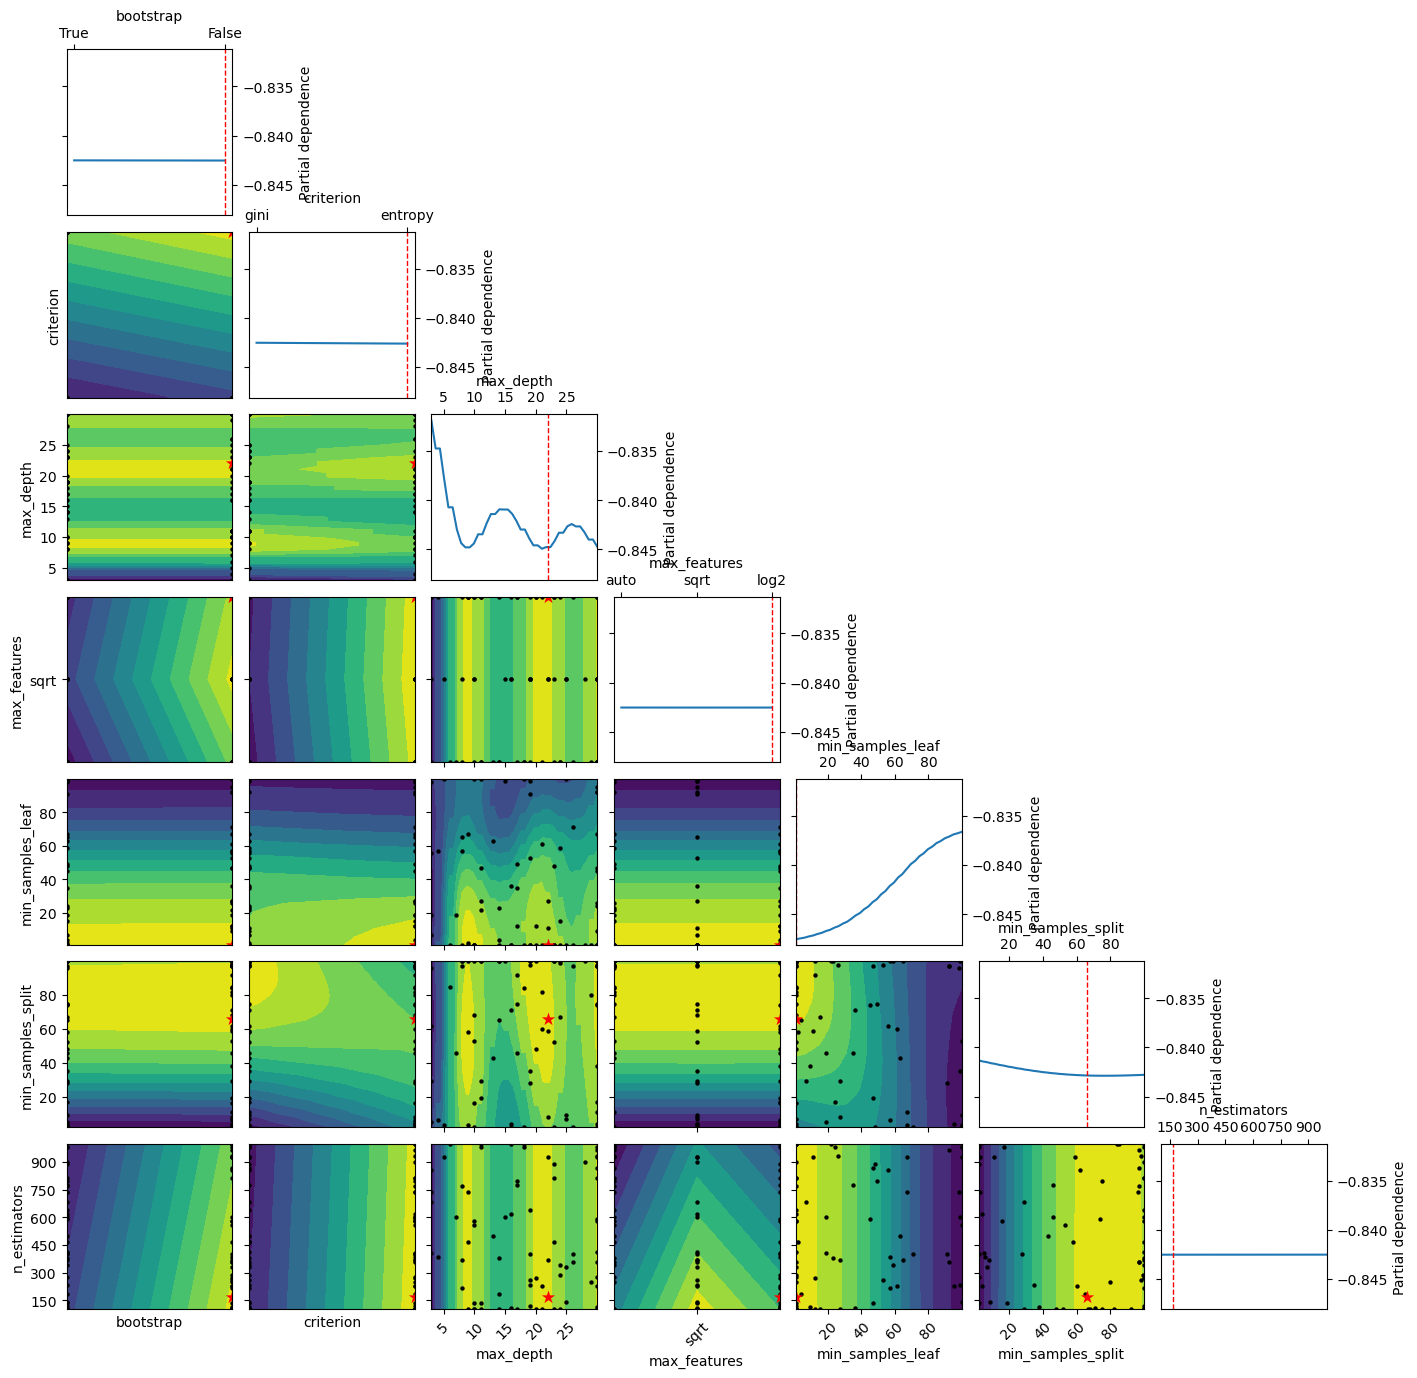

In [94]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    rf_bs_cv.optimizer_results_[0],
    dimensions=list(rf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### Random Forest Classifier - SmoteNC

In [95]:
rf = RandomForestClassifier(random_state=random_state)

rf_smotenc_bs_cv = BayesSearchCV(rf, search_space_rf, n_iter=n_iter_rf, scoring='roc_auc', n_jobs=-1, verbose=0 ,cv=5, random_state=random_state)
rf_smotenc_bs_cv.fit(X_train_trees_smotenc, y_train_smotenc)

best_rf_smotenc = rf_smotenc_bs_cv.best_estimator_
y_pred_rf_smotenc = best_rf_smotenc.predict(X_test_trees)

accuracy_rf_smotenc = accuracy_score(y_test, y_pred_rf_smotenc)
fpr_rf_smotenc, tpr_rf_smotenc, _ = roc_curve(y_test, best_rf_smotenc.predict_proba(X_test_trees)[:, 1])
auc_score_rf_smotenc = roc_auc_score(y_test, best_rf_smotenc.predict_proba(X_test_trees)[:, 1])
cm_rf_smotenc = confusion_matrix(y_test, y_pred_rf_smotenc)

TN_rf_smotenc, FP_rf_smotenc, FN_rf_smotenc, TP_rf_smotenc = cm_rf_smotenc.ravel()
fnr_rr_rf_smotenc = FN_rf_smotenc / (FN_rf_smotenc + TP_rf_smotenc)
tnr_rr_rf_smotenc = TN_rf_smotenc / (TN_rf_smotenc + FP_rf_smotenc)

print("Best parameters found for Random Forest: ", rf_smotenc_bs_cv.best_params_)
print("Prediction Accuracy for Random Forest:", accuracy_rf_smotenc)
print("AUC Score for Random Forest:", auc_score_rf_smotenc)

Best parameters found for Random Forest:  OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 26), ('max_features', 'auto'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 1000)])
Prediction Accuracy for Random Forest: 0.8436666666666667
AUC Score for Random Forest: 0.8492106826226862


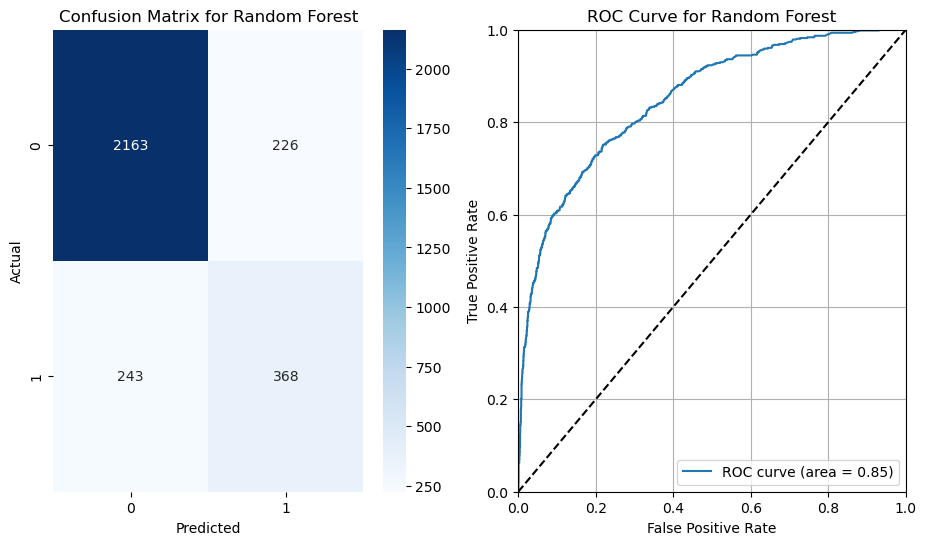

In [96]:
plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_rf_smotenc, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_rf_smotenc, tpr_rf_smotenc, label=f'ROC curve (area = {auc_score_rf_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Ada boost (Adaptive Boosting)

##### Ada boost (Adaptive Boosting)

In [97]:
search_space_ada = {"n_estimators": (100, 550), "learning_rate": (0.01, 2.0)}
n_iter_ada = 75 # balance computation time and performance

In [98]:
ada_clf_bs_cv = BayesSearchCV(
    AdaBoostClassifier(random_state=random_state),
    search_space_ada,
    n_iter=n_iter_ada,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=random_state
)

ada_clf_bs_cv.fit(X_train_trees, y_train)

best_ada_clf = ada_clf_bs_cv.best_estimator_
y_pred_ada = best_ada_clf.predict(X_test_trees)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
fpr_ada, tpr_ada, _ = roc_curve(y_test, best_ada_clf.predict_proba(X_test_trees)[:, 1])
auc_score_ada = roc_auc_score(y_test, best_ada_clf.predict_proba(X_test_trees)[:, 1])
cm_ada = confusion_matrix(y_test, y_pred_ada)

TN_ada, FP_ada, FN_ada, TP_ada = cm_ada.ravel()
fnr_rr_ada = FN_ada / (FN_ada + TP_ada)
tnr_rr_ada = TN_ada / (TN_ada + FP_ada)

print("Best parameters found for AdaBoost: ", ada_clf_bs_cv.best_params_)
print("Prediction Accuracy for AdaBoost:", accuracy_ada)
print("AUC Score for AdaBoost:", auc_score_ada)


Best parameters found for AdaBoost:  OrderedDict([('learning_rate', 0.19783289854217448), ('n_estimators', 100)])
Prediction Accuracy for AdaBoost: 0.856
AUC Score for AdaBoost: 0.8525569662919039


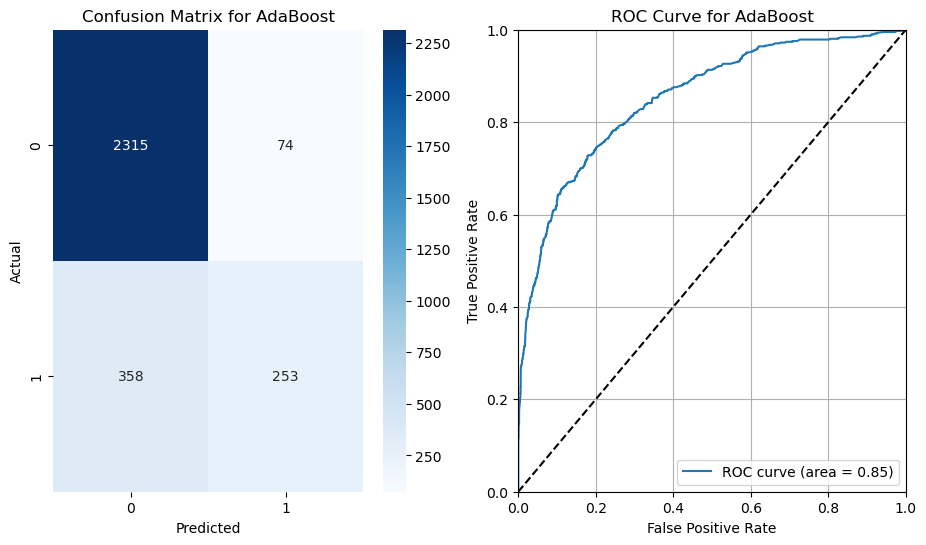

In [99]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_ada, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for AdaBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_ada, tpr_ada, label=f'ROC curve (area = {auc_score_ada:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

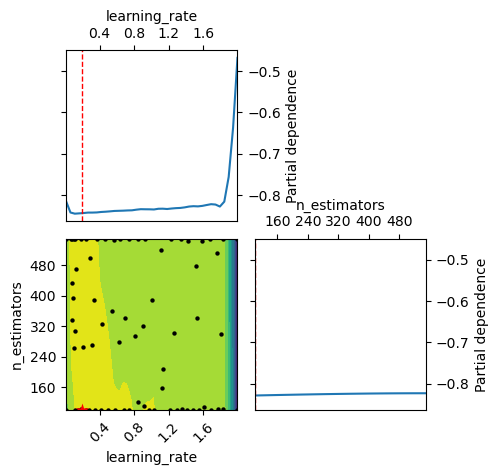

In [100]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    ada_clf_bs_cv.optimizer_results_[0],
    dimensions=list(ada_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### Ada boost (Adaptive Boosting) - SmoteNC


In [101]:
ada_smotenc_clf_bs_cv = BayesSearchCV(
    AdaBoostClassifier(random_state=random_state),
    search_space_ada,
    n_iter=n_iter_ada,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=random_state
)

ada_smotenc_clf_bs_cv.fit(X_train_trees_smotenc, y_train_smotenc)

best_ada_smotenc_clf = ada_smotenc_clf_bs_cv.best_estimator_
y_pred_ada_smotenc = best_ada_smotenc_clf.predict(X_test_trees)

accuracy_ada_smotenc = accuracy_score(y_test, y_pred_ada_smotenc)
fpr_ada_smotenc, tpr_ada_smotenc, _ = roc_curve(y_test, best_ada_smotenc_clf.predict_proba(X_test_trees)[:, 1])
auc_score_ada_smotenc = roc_auc_score(y_test, best_ada_smotenc_clf.predict_proba(X_test_trees)[:, 1])
cm_ada_smotenc = confusion_matrix(y_test, y_pred_ada_smotenc)

TN_ada_smotenc, FP_ada_smotenc, FN_ada_smotenc, TP_ada_smotenc = cm_ada_smotenc.ravel()
fnr_rr_ada_smotenc = FN_ada_smotenc / (FN_ada_smotenc + TP_ada_smotenc)
tnr_rr_ada_smotenc = TN_ada_smotenc / (TN_ada_smotenc + FP_ada_smotenc)

print("Best parameters found for AdaBoost: ", ada_smotenc_clf_bs_cv.best_params_)
print("Prediction Accuracy for AdaBoost:", accuracy_ada_smotenc)
print("AUC Score for AdaBoost:", auc_score_ada_smotenc)


Best parameters found for AdaBoost:  OrderedDict([('learning_rate', 1.589307804326254), ('n_estimators', 550)])
Prediction Accuracy for AdaBoost: 0.824
AUC Score for AdaBoost: 0.8335127106713187


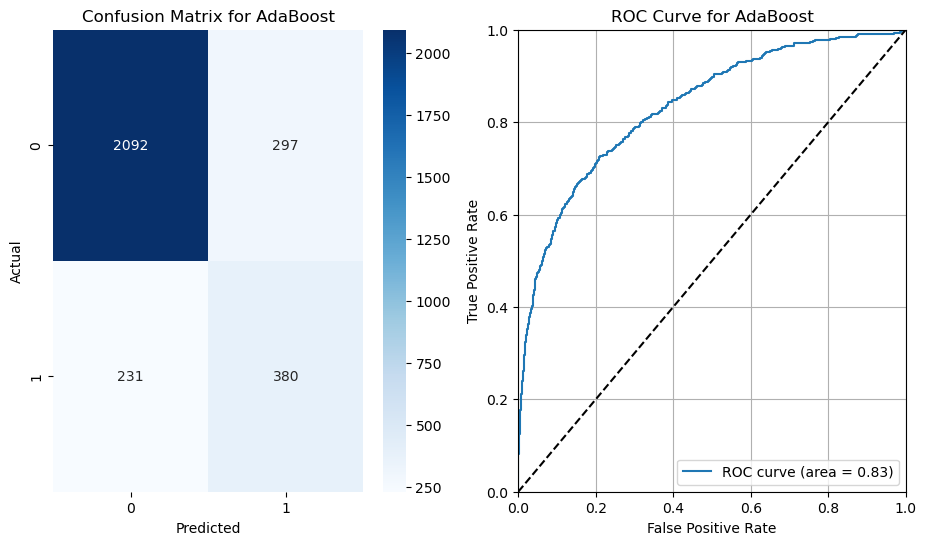

In [102]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_ada_smotenc, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for AdaBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_ada_smotenc, tpr_ada_smotenc, label=f'ROC curve (area = {auc_score_ada_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

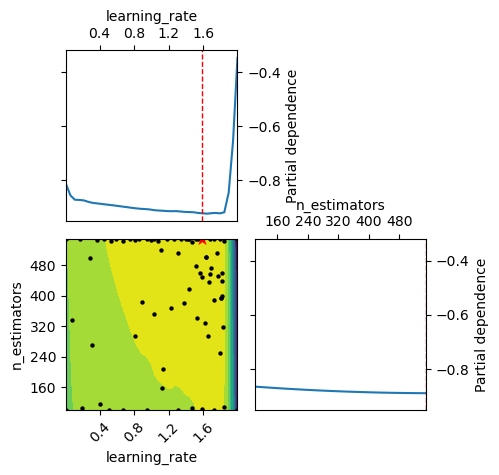

In [103]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    ada_smotenc_clf_bs_cv.optimizer_results_[0],
    dimensions=list(ada_smotenc_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

#### XGBoost (eXtreme Gradient Boosting)

In [104]:
search_space_xgb = {
    'subsample': (0.5, 1.0),  
    'learning_rate': (0.01, 0.3),  
    'max_depth': (3, 30),  
    'n_estimators': (100, 700), 
    'colsample_bytree': (0.1, 0.8),
    'gamma': (0, 15),  
    'min_child_weight': (1, 10), 
    'reg_alpha': (0, 1),  
    'reg_lambda': (1, 5), 
    'scale_pos_weight': (1, 10), 
}

n_iter_xgb = 100 # balance computation time and performance

##### XGBoost (eXtreme Gradient Boosting)

In [105]:
xgb_clf_bs_cv = BayesSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=random_state),
    search_space_xgb,
    n_iter=n_iter_xgb,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=random_state
)

xgb_clf_bs_cv.fit(X_train_trees, y_train)

best_xgb_clf = xgb_clf_bs_cv.best_estimator_
y_pred_xgb = best_xgb_clf.predict(X_test_trees)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_clf.predict_proba(X_test_trees)[:, 1])
auc_score_xgb = roc_auc_score(y_test, best_xgb_clf.predict_proba(X_test_trees)[:, 1])
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
fnr_rr_xgb = FN_xgb / (FN_xgb + TP_xgb)
tnr_rr_xgb = TN_xgb / (TN_xgb + FP_xgb)

print("Best parameters found for XGBoost: ", xgb_clf_bs_cv.best_params_)
print("Prediction Accuracy for XGBoost:", accuracy_xgb)
print("AUC Score for XGBoost:", auc_score_xgb)



Best parameters found for XGBoost:  OrderedDict([('colsample_bytree', 0.40314891996960256), ('gamma', 5), ('learning_rate', 0.19112376209290538), ('max_depth', 30), ('min_child_weight', 1), ('n_estimators', 579), ('reg_alpha', 0), ('reg_lambda', 2), ('scale_pos_weight', 1), ('subsample', 1.0)])
Prediction Accuracy for XGBoost: 0.8633333333333333
AUC Score for XGBoost: 0.8740168215066464


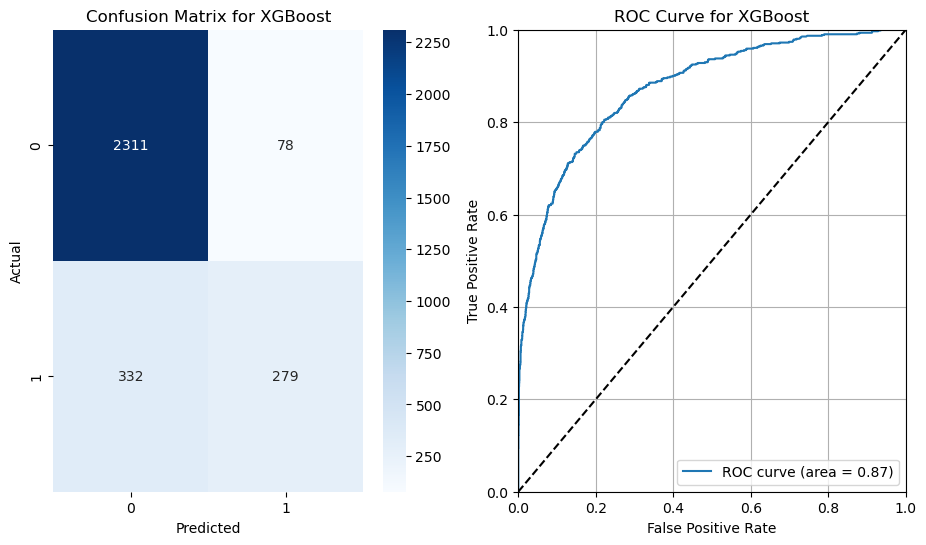

In [106]:
plt.figure(figsize=(11, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_xgb, tpr_xgb, label=f'ROC curve (area = {auc_score_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

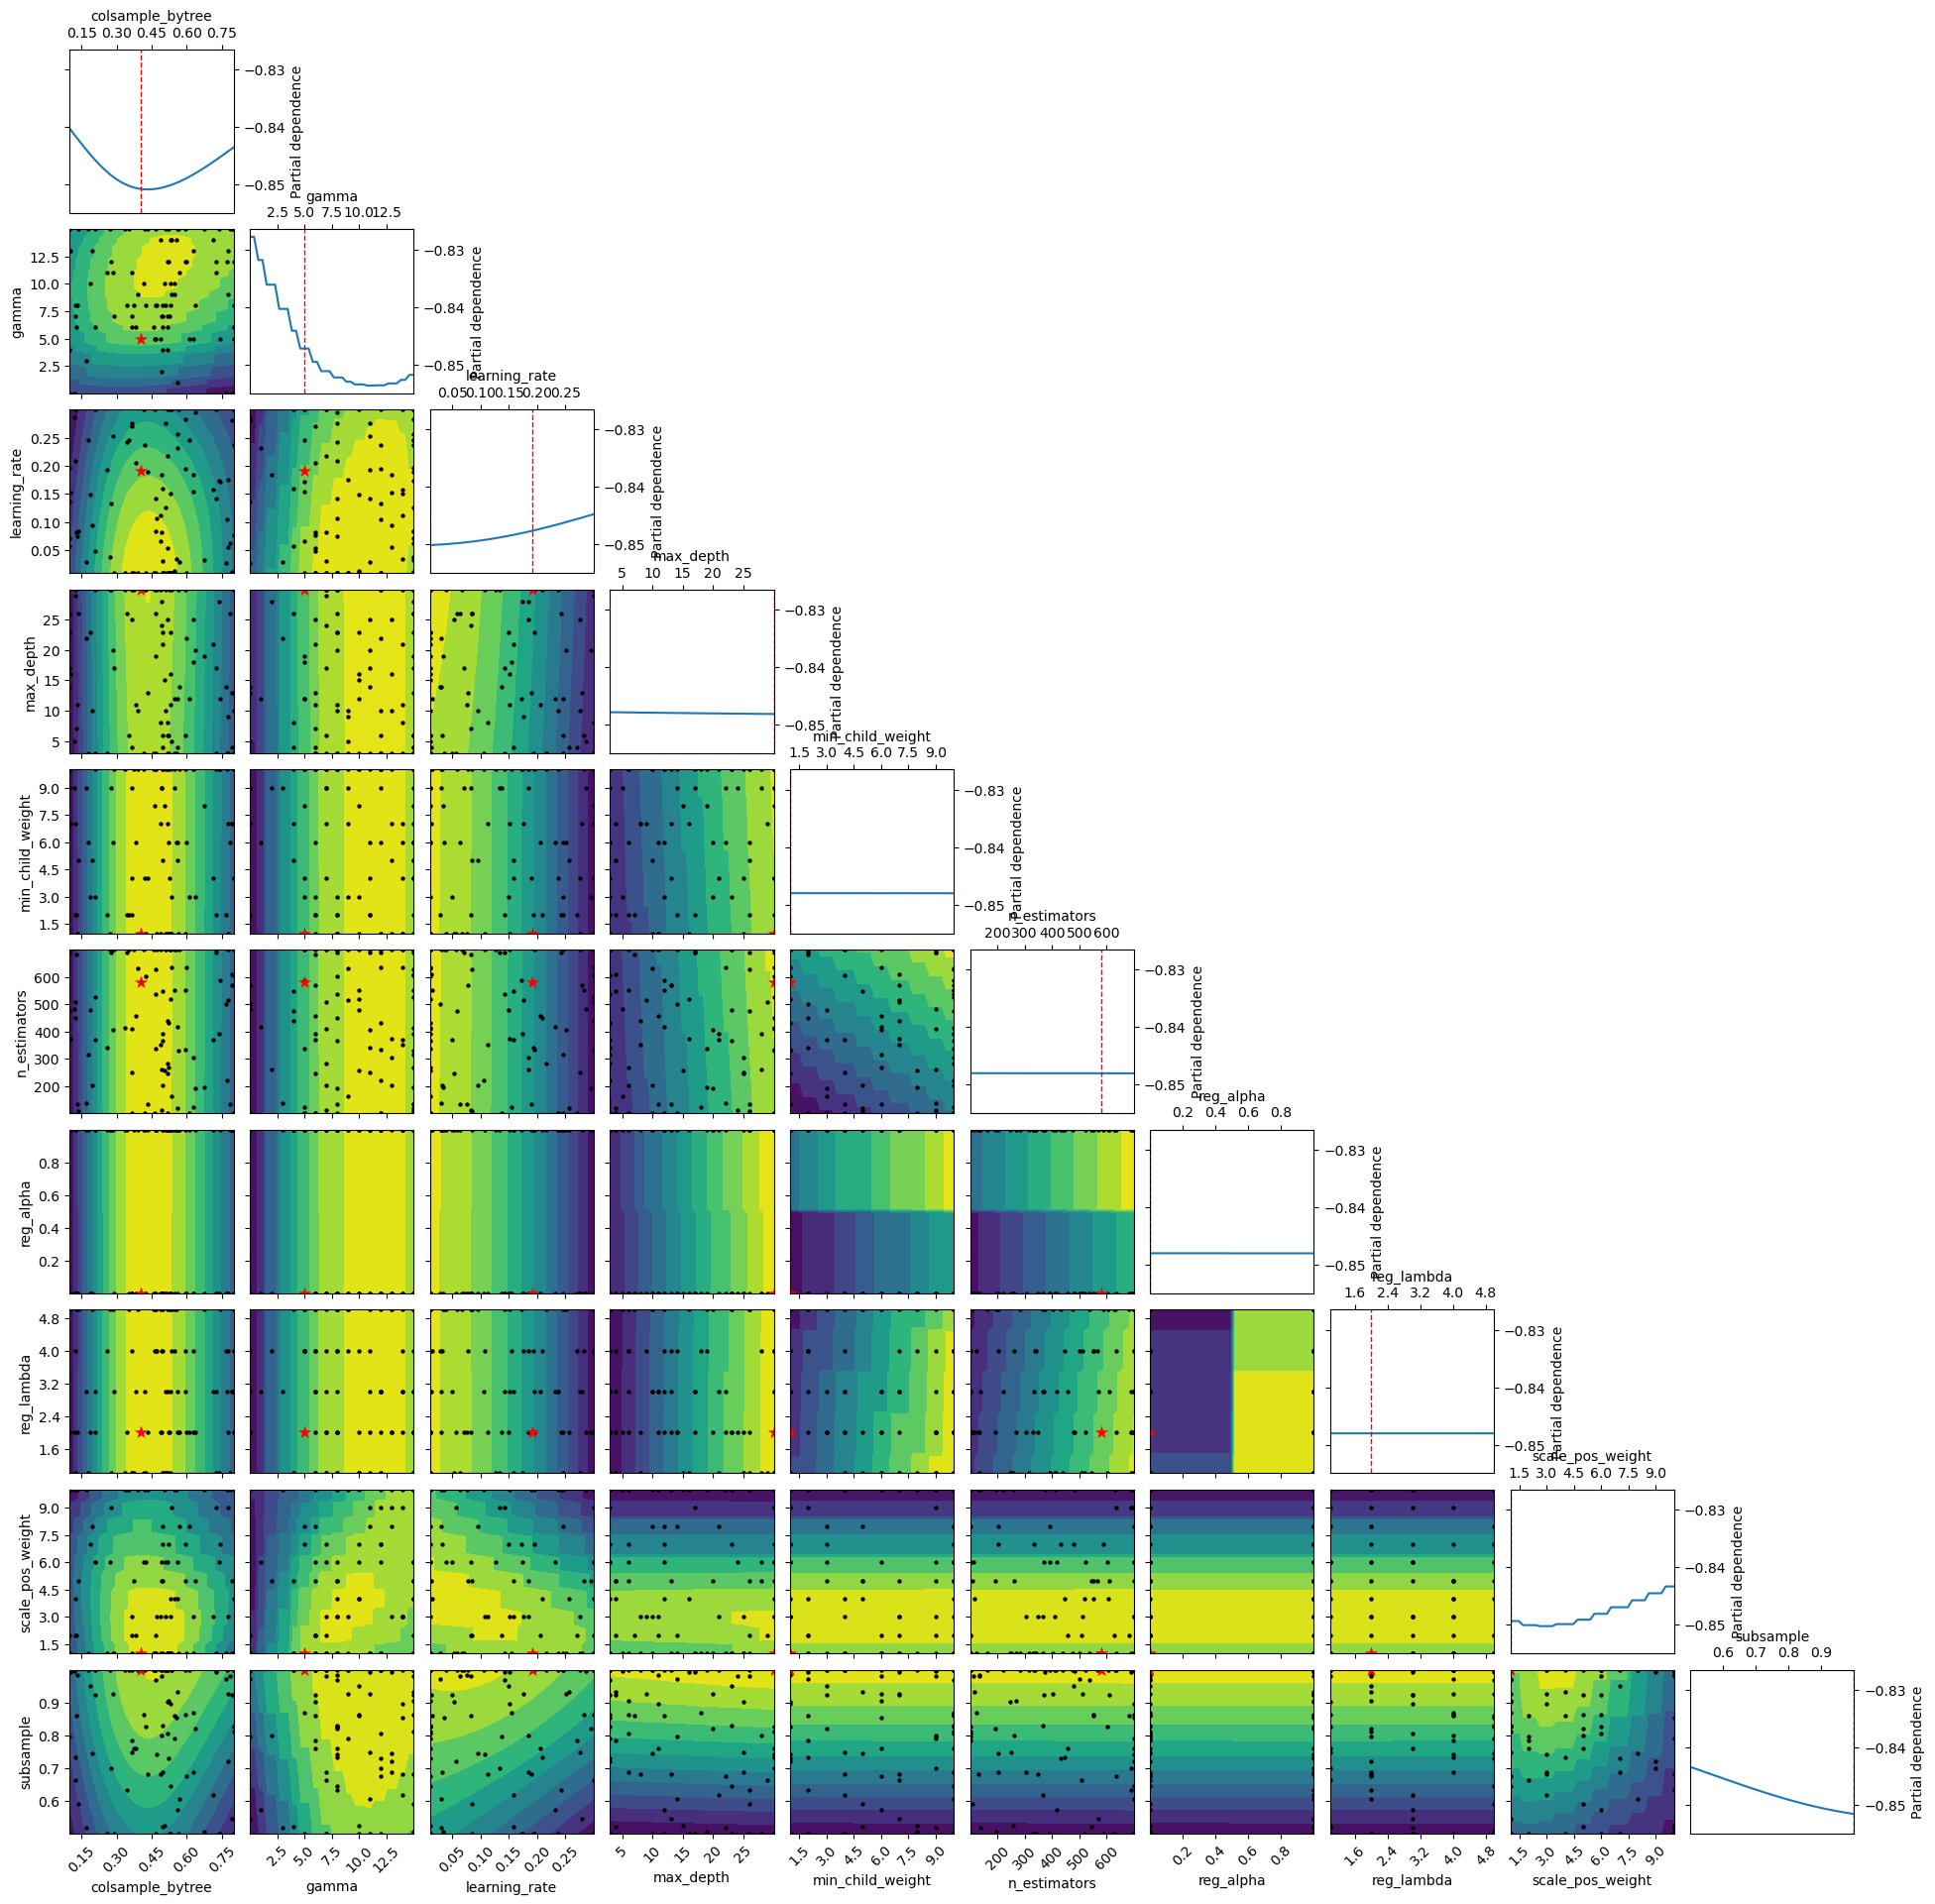

In [107]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    xgb_clf_bs_cv.optimizer_results_[0],
    dimensions=list(xgb_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### XGBoost (eXtreme Gradient Boosting) - SmoteNC

In [108]:
xgb_smotenc_clf_bs_cv = BayesSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=random_state),
    search_space_xgb,
    n_iter=n_iter_xgb,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=random_state
)

xgb_smotenc_clf_bs_cv.fit(X_train_trees_smotenc, y_train_smotenc)

best_xgb_smotenc_clf = xgb_smotenc_clf_bs_cv.best_estimator_
y_pred_xgb_smotenc = best_xgb_smotenc_clf.predict(X_test_trees)

accuracy_xgb_smotenc = accuracy_score(y_test, y_pred_xgb_smotenc)
fpr_xgb_smotenc, tpr_xgb_smotenc, _ = roc_curve(y_test, best_xgb_smotenc_clf.predict_proba(X_test_trees)[:, 1])
auc_score_xgb_smotenc = roc_auc_score(y_test, best_xgb_smotenc_clf.predict_proba(X_test_trees)[:, 1])
cm_xgb_smotenc = confusion_matrix(y_test, y_pred_xgb_smotenc)

TN_xgb_smotenc, FP_xgb_smotenc, FN_xgb_smotenc, TP_xgb_smotenc = cm_xgb_smotenc.ravel()
fnr_rr_xgb_smotenc = FN_xgb_smotenc / (FN_xgb_smotenc + TP_xgb_smotenc)
tnr_rr_xgb_smotenc = TN_xgb_smotenc / (TN_xgb_smotenc + FP_xgb_smotenc)

print("Best parameters found for XGBoost: ", xgb_smotenc_clf_bs_cv.best_params_)
print("Prediction Accuracy for XGBoost:", accuracy_xgb_smotenc)
print("AUC Score for XGBoost:", auc_score_xgb_smotenc)

Best parameters found for XGBoost:  OrderedDict([('colsample_bytree', 0.40231025932344344), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 26), ('min_child_weight', 1), ('n_estimators', 700), ('reg_alpha', 1), ('reg_lambda', 1), ('scale_pos_weight', 10), ('subsample', 1.0)])
Prediction Accuracy for XGBoost: 0.749
AUC Score for XGBoost: 0.8462257797776087


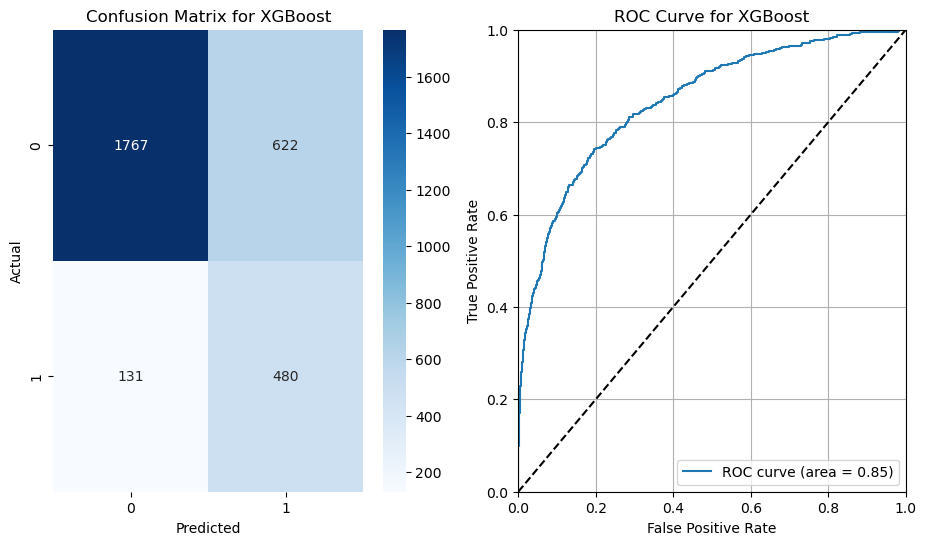

In [109]:
plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_xgb_smotenc, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.plot(fpr_xgb_smotenc, tpr_xgb_smotenc, label=f'ROC curve (area = {auc_score_xgb_smotenc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

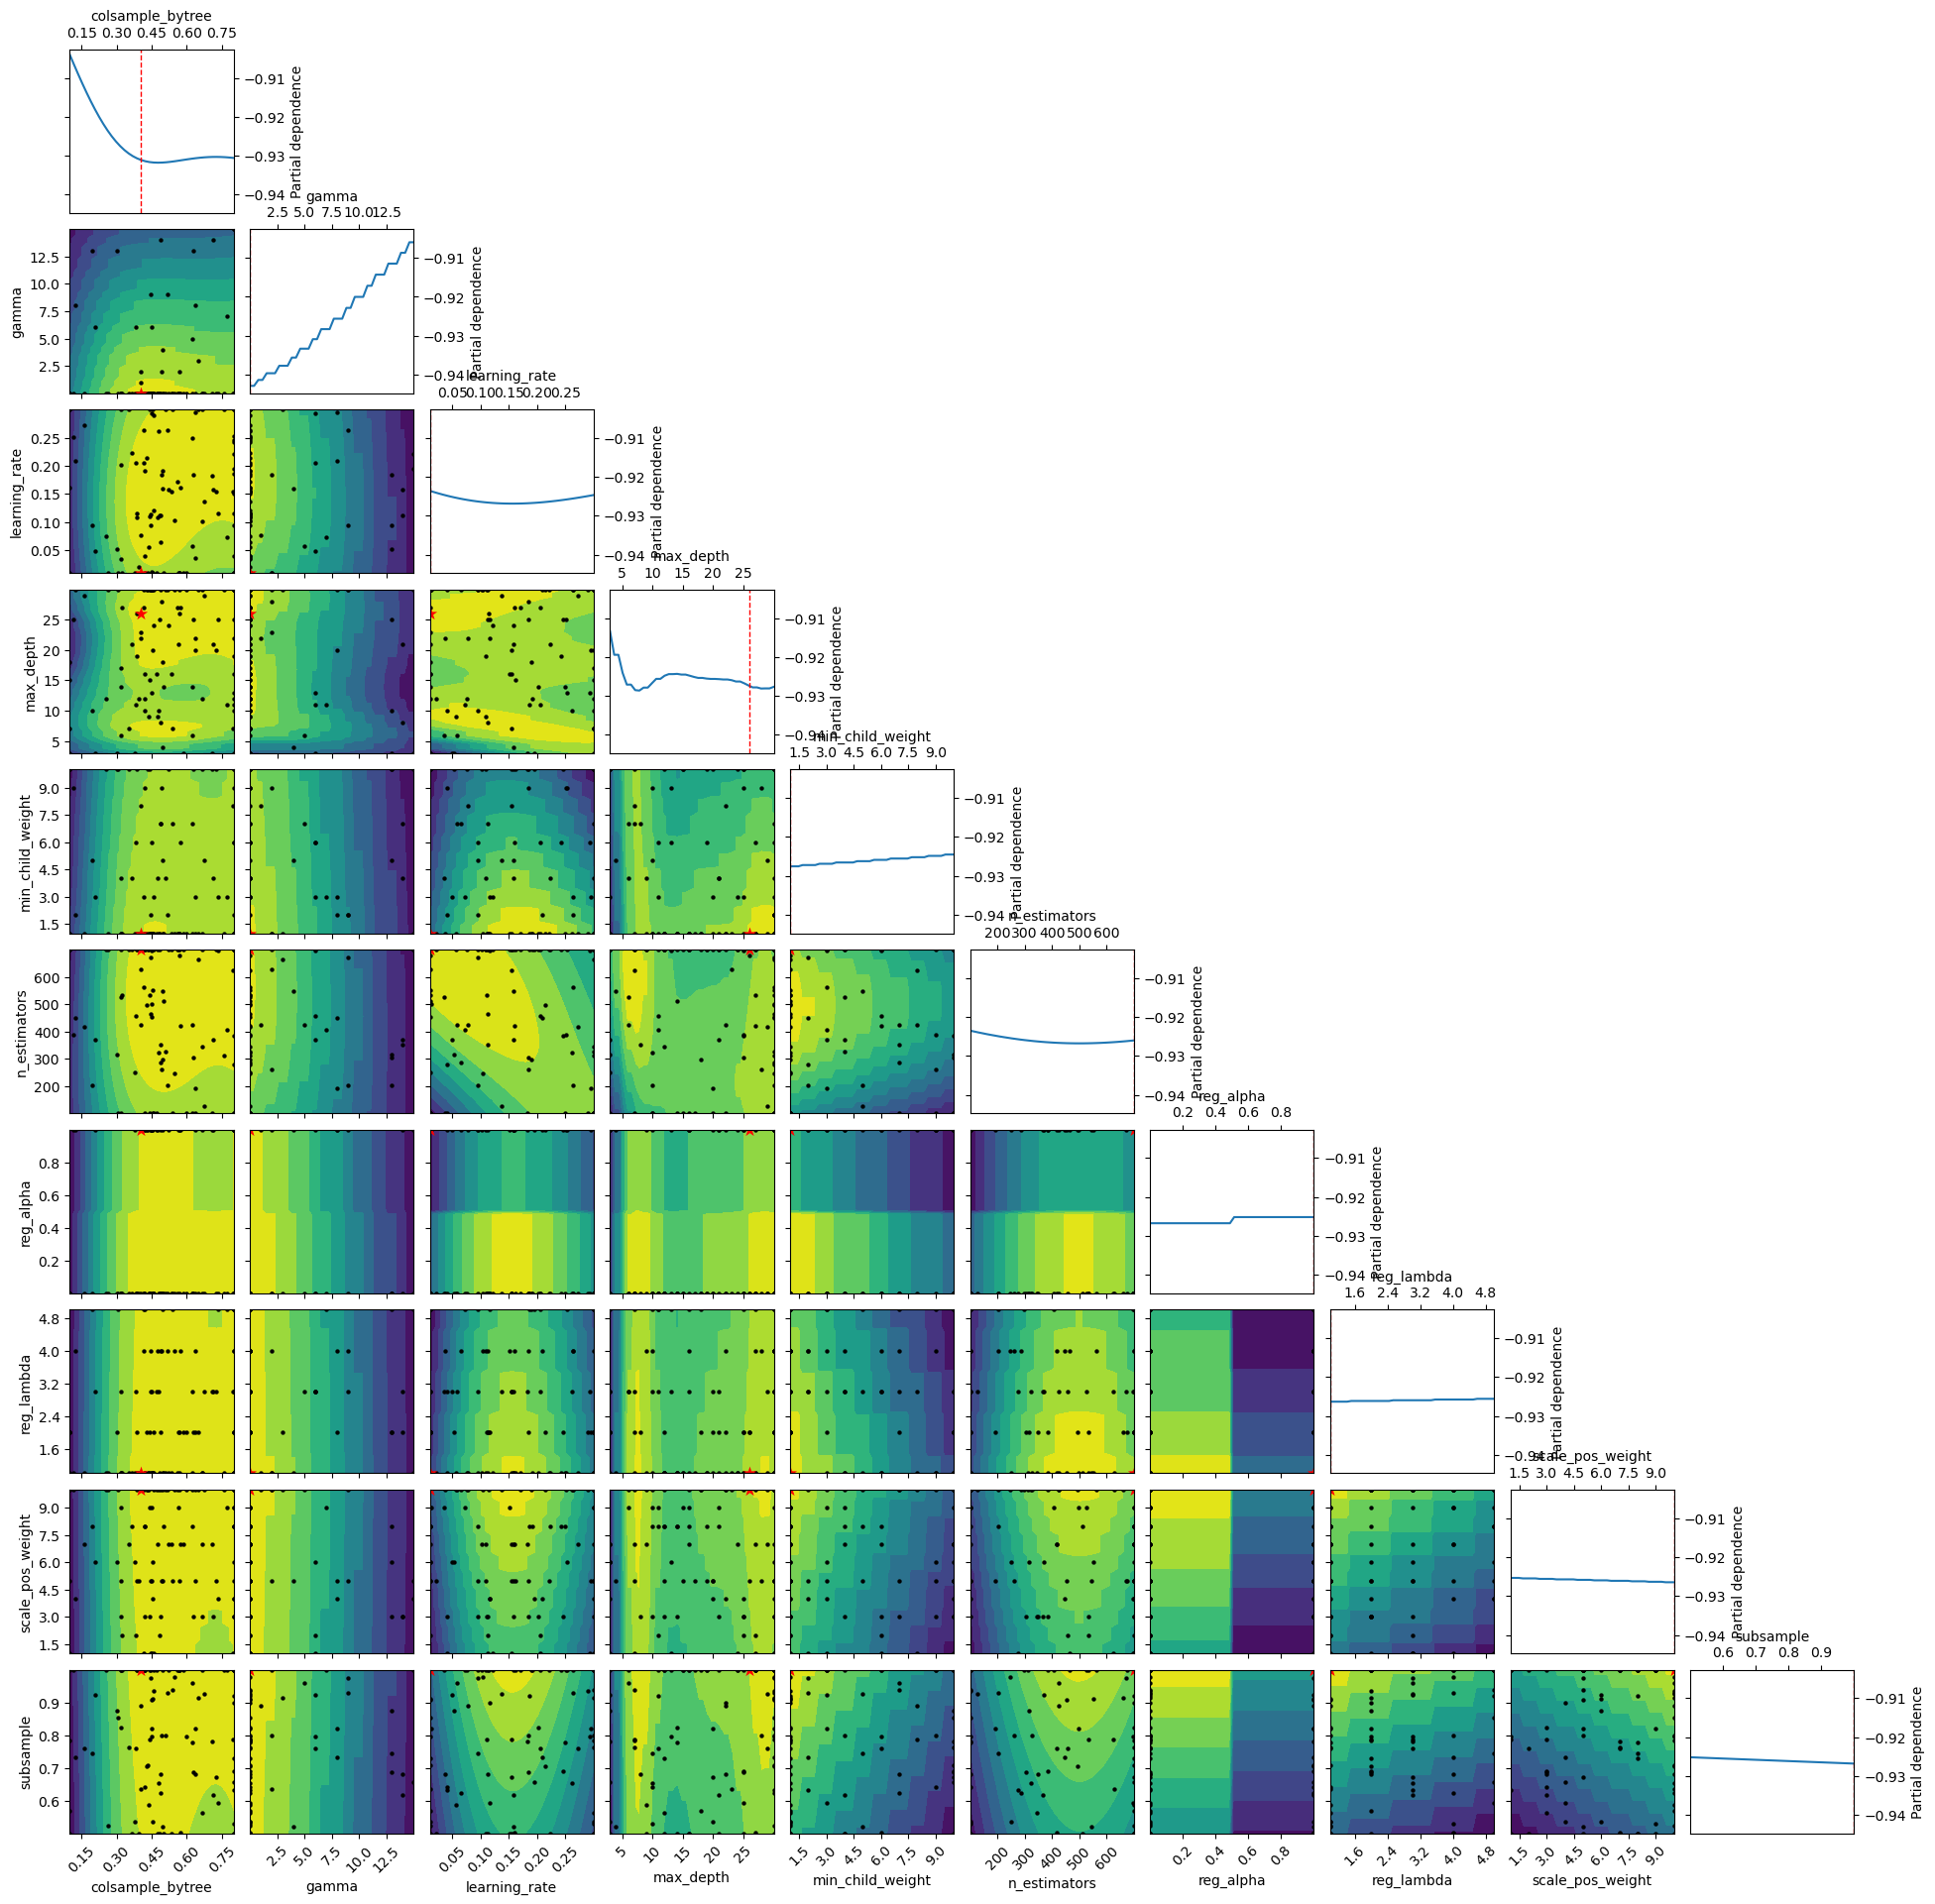

In [110]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    xgb_smotenc_clf_bs_cv.optimizer_results_[0],
    dimensions=list(xgb_smotenc_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

#### CatBoost (Catetgorical Boosting) Classifier

- Since Catboost use sequential encoding and automatically handle categorical features, we don't need to use one-hot encoding
- **Note: CatBoostClassifier is computationally expensive to train and time consuming.
One of our devices support Nvidia CUDA, which the model was originally trained on.
For assignment grading and reproducibility purposes, we have disabled the GPU option. If your device supports Nvidia CUDA. Please replace CatBoostClassifier by the following code**


```python
cat_clf = CatBoostClassifier(
    cat_features=cat_features,
    random_state=random_state,
    task_type="GPU", # <--- if use GPU, add this line
    devices="0:1", # <--- if use GPU, adjust this line per your device
    verbose=0,
)


In [111]:
search_spaces_cat = {
    "iterations": Integer(100, 1500),
    "learning_rate": Real(0.01, 0.5, "log-uniform"),
    "depth": Integer(1, 10),
    "l2_leaf_reg": Real(1e-20, 1e3, "log-uniform"),
    "border_count": Integer(1, 300),
    "bagging_temperature": Real(0, 1, "uniform"),
    "auto_class_weights": Categorical(['None', 'Balanced', 'SqrtBalanced']),
}
n_iter_cat = 75 # balance computation time and performance, also need to > 15 to see objective function plot

X_train_cat_namedrop = X_train_cat.drop("Surname", axis=1)
X_train_cat_smotenc_namedrop = X_train_cat_smotenc.drop("Surname", axis=1)
X_test_cat_namedrop = X_test_cat.drop("Surname", axis=1)


##### CatBoost (Catetgorical Boosting) Classifier

In [112]:
cat_features = [
    X_train_cat_namedrop.columns.get_loc(col)
    for col in X_train_cat_namedrop.columns
    if X_train_cat_namedrop[col].dtype == "object"
]

cat_clf = CatBoostClassifier(
    cat_features=cat_features,
    random_state=random_state,
    verbose=0,
)

cat_clf_bs_cv = BayesSearchCV(
    estimator=cat_clf,
    search_spaces=search_spaces_cat,
    n_iter=n_iter_cat,  
    cv=5,  
    n_jobs=-1,  
    scoring="roc_auc",
    verbose=0,
)

cat_clf_bs_cv.fit(X_train_cat_namedrop, y_train)
print("Best parameters:", cat_clf_bs_cv.best_params_)

y_pred_cat = cat_clf_bs_cv.predict(X_test_cat_namedrop)
accuracy_cat = accuracy_score(y_test, y_pred_cat.astype(int))
fpr_cat, tpr_cat, _ = roc_curve(y_test, cat_clf_bs_cv.predict_proba(X_test_cat_namedrop)[:, 1])
auc_score_cat = roc_auc_score(y_test, cat_clf_bs_cv.predict_proba(X_test_cat_namedrop)[:, 1])
cm_cat = confusion_matrix(y_test, y_pred_cat.astype(int))

TN_cat, FP_cat, FN_cat, TP_cat = cm_cat.ravel()
fnr_rr_cat = FN_cat / (FN_cat + TP_cat)
tnr_rr_cat = TN_cat / (TN_cat + FP_cat)

print("Prediction Accuracy for CatBoost:", accuracy_cat)
print("AUC Score for CatBoost:", auc_score_cat)


Best parameters: OrderedDict([('auto_class_weights', 'None'), ('bagging_temperature', 0.017328740790449694), ('border_count', 264), ('depth', 4), ('iterations', 793), ('l2_leaf_reg', 1.5508085899560534e-17), ('learning_rate', 0.01)])
Prediction Accuracy for CatBoost: 0.8623333333333333
AUC Score for CatBoost: 0.8762207307223028


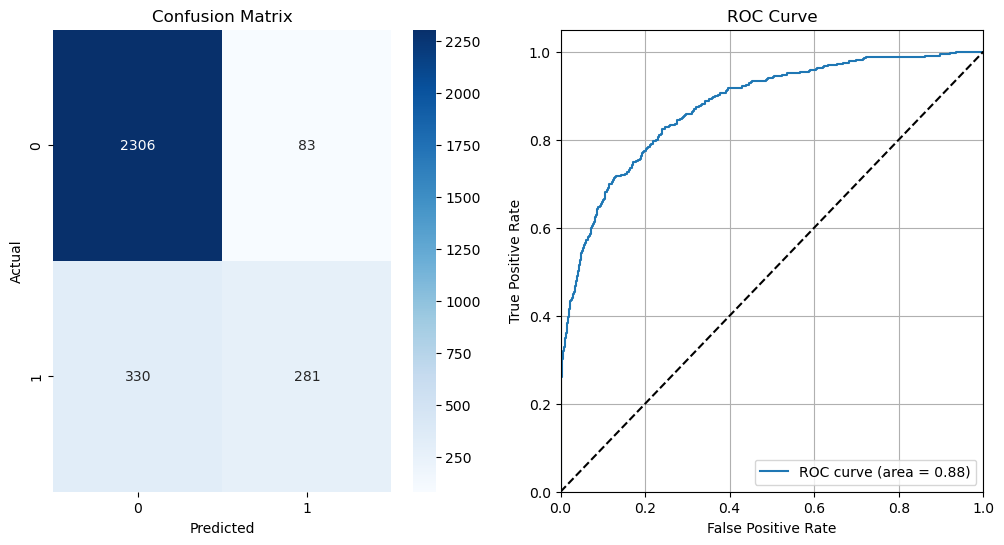

In [113]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_cat, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
plt.plot(fpr_cat, tpr_cat, label=f"ROC curve (area = {auc_score_cat:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

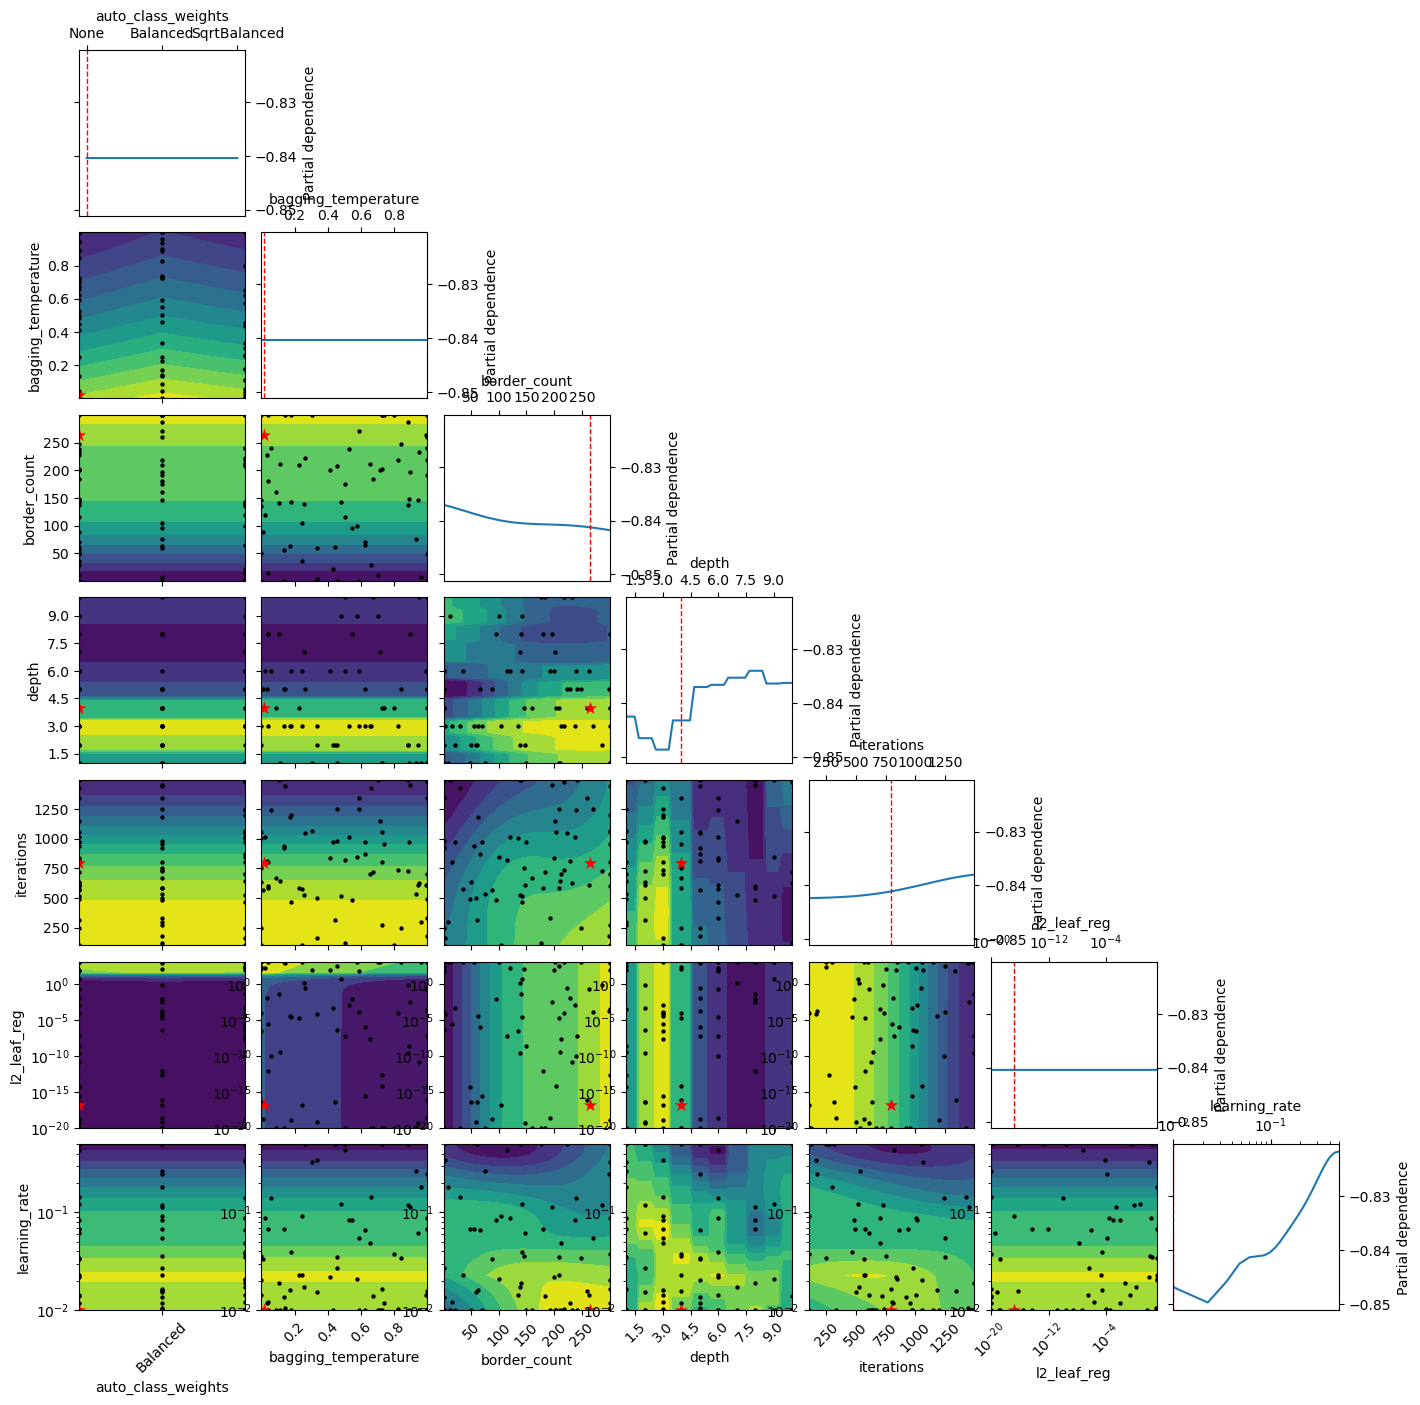

In [114]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    cat_clf_bs_cv.optimizer_results_[0],
    dimensions=list(cat_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### CatBoost (Catetgorical Boosting) Classifier - SmoteNC

In [115]:
cat_smotenc_features = [
    X_train_cat_smotenc_namedrop.columns.get_loc(col)
    for col in X_train_cat_smotenc_namedrop.columns
    if X_train_cat_smotenc_namedrop[col].dtype == "object"
]

cat_clf = CatBoostClassifier(
    cat_features=cat_smotenc_features,
    random_state=random_state,
    verbose=0,
)

cat_smotenc_clf_bs_cv = BayesSearchCV(
    estimator=cat_clf,
    search_spaces=search_spaces_cat,
    n_iter=n_iter_cat,  
    cv=5,  
    n_jobs=-1,  
    scoring="roc_auc",
    verbose=0,
)

cat_smotenc_clf_bs_cv.fit(X_train_cat_smotenc_namedrop, y_train_smotenc)
print("Best parameters:", cat_smotenc_clf_bs_cv.best_params_)

y_pred_cat_smotenc = cat_smotenc_clf_bs_cv.predict(X_test_cat_namedrop)
accuracy_cat_smotenc = accuracy_score(y_test, y_pred_cat_smotenc.astype(int))
fpr_cat_smotenc, tpr_cat_smotenc, _ = roc_curve(y_test, cat_smotenc_clf_bs_cv.predict_proba(X_test_cat_namedrop)[:, 1])
auc_score_cat_smotenc = roc_auc_score(y_test, cat_smotenc_clf_bs_cv.predict_proba(X_test_cat_namedrop)[:, 1])
cm_cat_smotenc = confusion_matrix(y_test, y_pred_cat_smotenc.astype(int))

TN_cat_smotenc, FP_cat_smotenc, FN_cat_smotenc, TP_cat_smotenc = cm_cat_smotenc.ravel()
fnr_rr_cat_smotenc = FN_cat_smotenc / (FN_cat_smotenc + TP_cat_smotenc)
tnr_rr_cat_smotenc = TN_cat_smotenc / (TN_cat_smotenc + FP_cat_smotenc)

print("Prediction Accuracy for CatBoost:", accuracy_cat_smotenc)
print("AUC Score for CatBoost:", auc_score_cat_smotenc)


Best parameters: OrderedDict([('auto_class_weights', 'None'), ('bagging_temperature', 0.1361815676406816), ('border_count', 143), ('depth', 7), ('iterations', 1379), ('l2_leaf_reg', 2.5894872452532644e-17), ('learning_rate', 0.01986260408997067)])
Prediction Accuracy for CatBoost: 0.8523333333333334
AUC Score for CatBoost: 0.8518962045764857


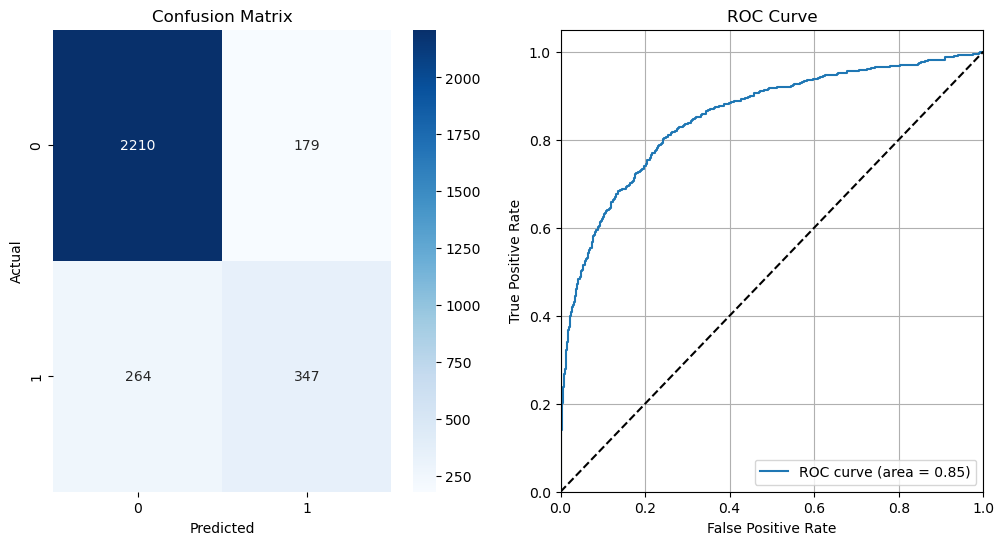

In [116]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_cat_smotenc, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
plt.plot(fpr_cat_smotenc, tpr_cat_smotenc, label=f"ROC curve (area = {auc_score_cat_smotenc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

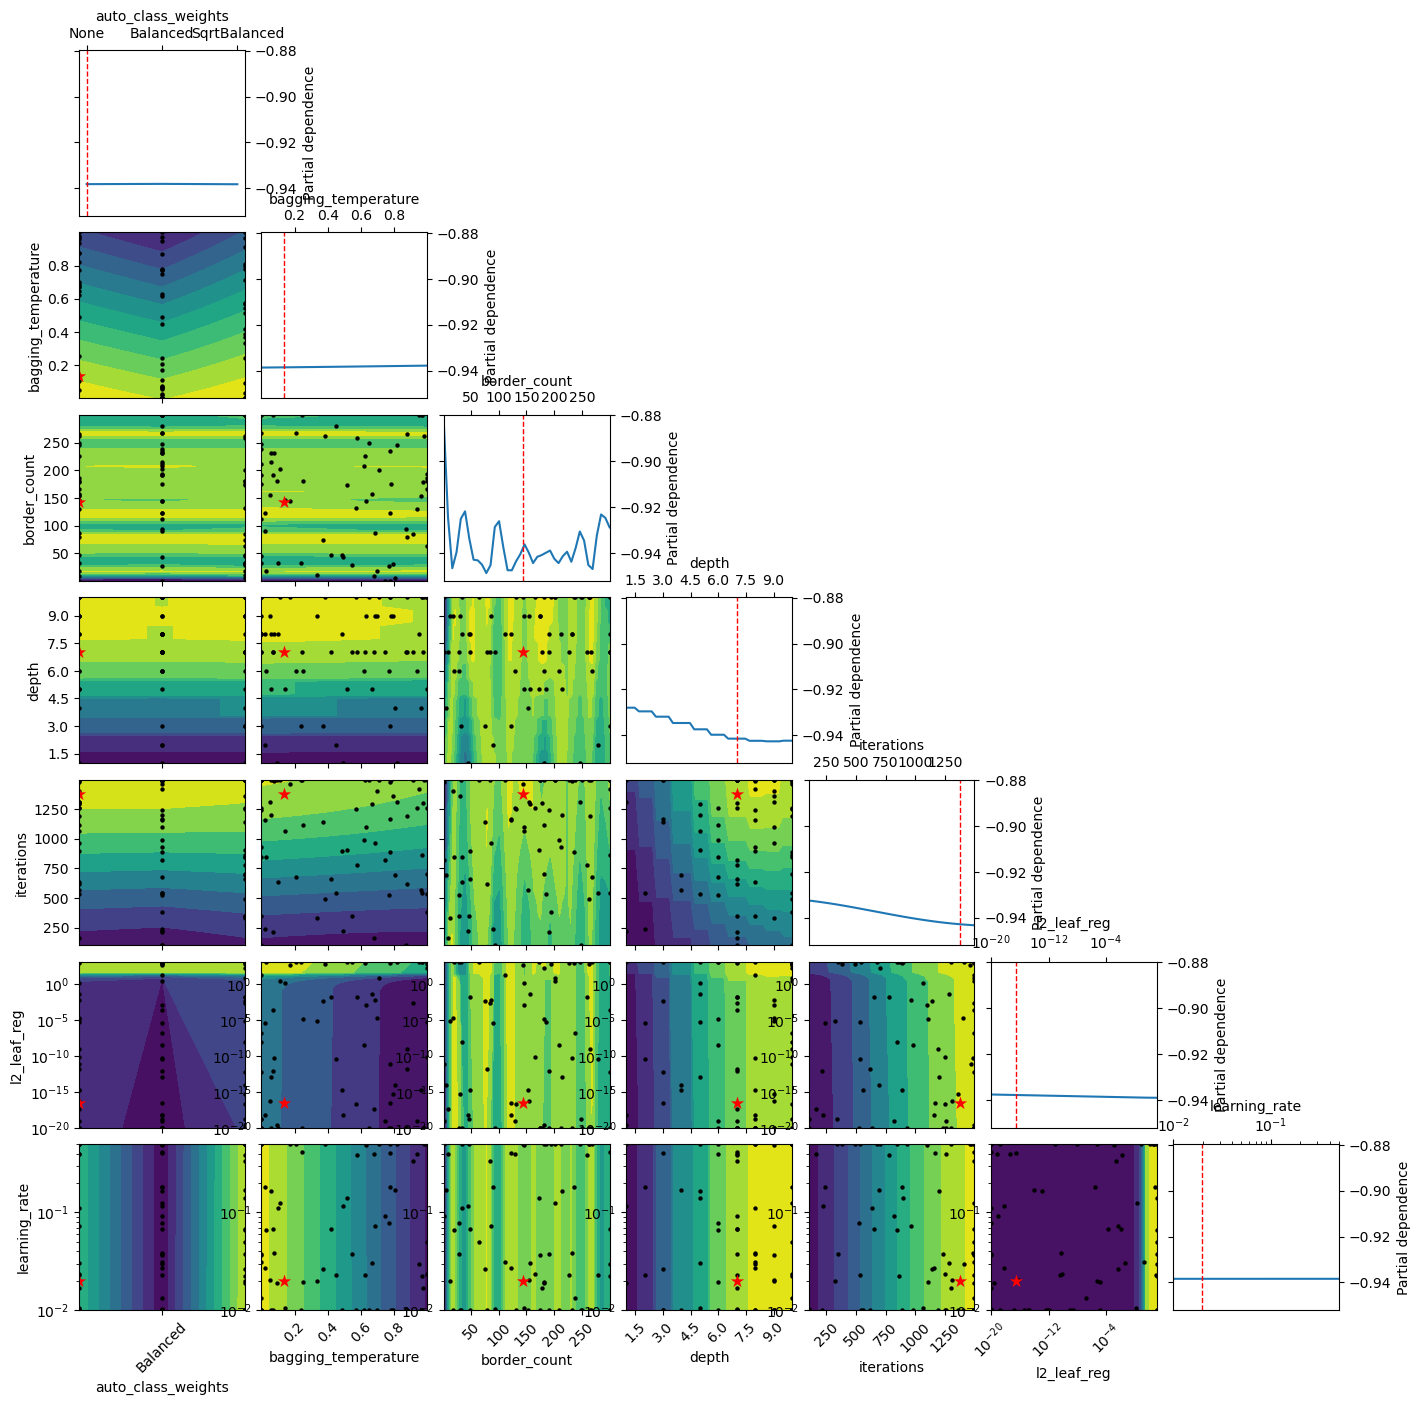

In [117]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    cat_smotenc_clf_bs_cv.optimizer_results_[0],
    dimensions=list(cat_smotenc_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### CatBoost (Catetgorical Boosting) Classifier - Surname Vec 

**WARNING**: this model is very computationally expensive to train, and the search space is very large

In [118]:
# new search space for catboost surname vectorisation
search_spaces_cat_namevec = {
    "iterations": Integer(100, 1500),
    "learning_rate": Real(0.01, 0.5, "log-uniform"),
    "depth": Integer(1, 10),
    "l2_leaf_reg": Real(1e-20, 1e3, "log-uniform"),
    "border_count": Integer(1, 300),
    "bagging_temperature": Real(0, 1, "uniform"),
    "auto_class_weights": Categorical(['None', 'Balanced', 'SqrtBalanced']),
}

In [119]:
cat_surname_features = [
    X_train_cat.columns.get_loc(col)
    for col in X_train_cat.columns
    if X_train_cat[col].dtype == "object"
]

cat_surname_clf = CatBoostClassifier(
    cat_features=cat_surname_features,
    random_state=random_state,
    verbose=0,
)

cat_surname_clf_bs_cv = BayesSearchCV(
    estimator=cat_surname_clf,
    search_spaces=search_spaces_cat_namevec,
    n_iter=n_iter_cat,  
    cv=5,  
    n_jobs=-1,  
    scoring="roc_auc",
    verbose=0,
)

cat_surname_clf_bs_cv.fit(X_train_cat, y_train)
print("Best parameters:", cat_surname_clf_bs_cv.best_params_)

y_pred_cat_surname = cat_surname_clf_bs_cv.predict(X_test_cat)
accuracy_cat_surname = accuracy_score(y_test, y_pred_cat_surname.astype(int))
fpr_cat_surname, tpr_cat_surname, _ = roc_curve(y_test, cat_surname_clf_bs_cv.predict_proba(X_test_cat)[:, 1])
auc_score_cat_surname = roc_auc_score(y_test, cat_surname_clf_bs_cv.predict_proba(X_test_cat)[:, 1])
cm_cat_surname = confusion_matrix(y_test, y_pred_cat_surname.astype(int))

TN_cat_surname, FP_cat_surname, FN_cat_surname, TP_cat_surname = cm_cat_surname.ravel()
fnr_rr_cat_surname = FN_cat_surname / (FN_cat_surname + TP_cat_surname)
tnr_rr_cat_surname = TN_cat_surname / (TN_cat_surname + FP_cat_surname)

print("Prediction Accuracy for CatBoost:", accuracy_cat_surname)
print("AUC Score for CatBoost:", auc_score_cat_surname)


Best parameters: OrderedDict([('auto_class_weights', 'None'), ('bagging_temperature', 0.17706376124845327), ('border_count', 234), ('depth', 6), ('iterations', 1090), ('l2_leaf_reg', 5.406658727769704), ('learning_rate', 0.01)])
Prediction Accuracy for CatBoost: 0.864
AUC Score for CatBoost: 0.8783211925361673


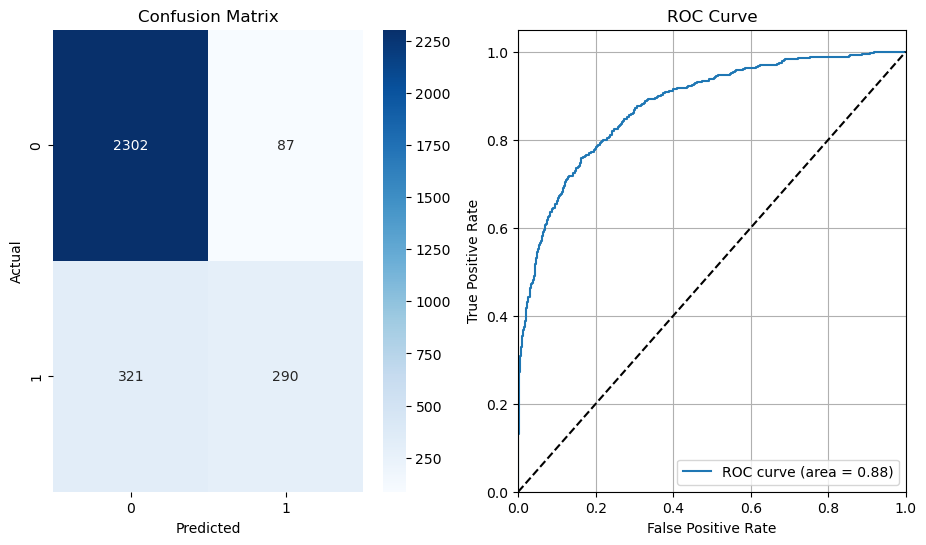

In [217]:

plt.figure(figsize=(11, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_cat_surname, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
plt.plot(fpr_cat_surname, tpr_cat_surname, label=f"ROC curve (area = {auc_score_cat_surname:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

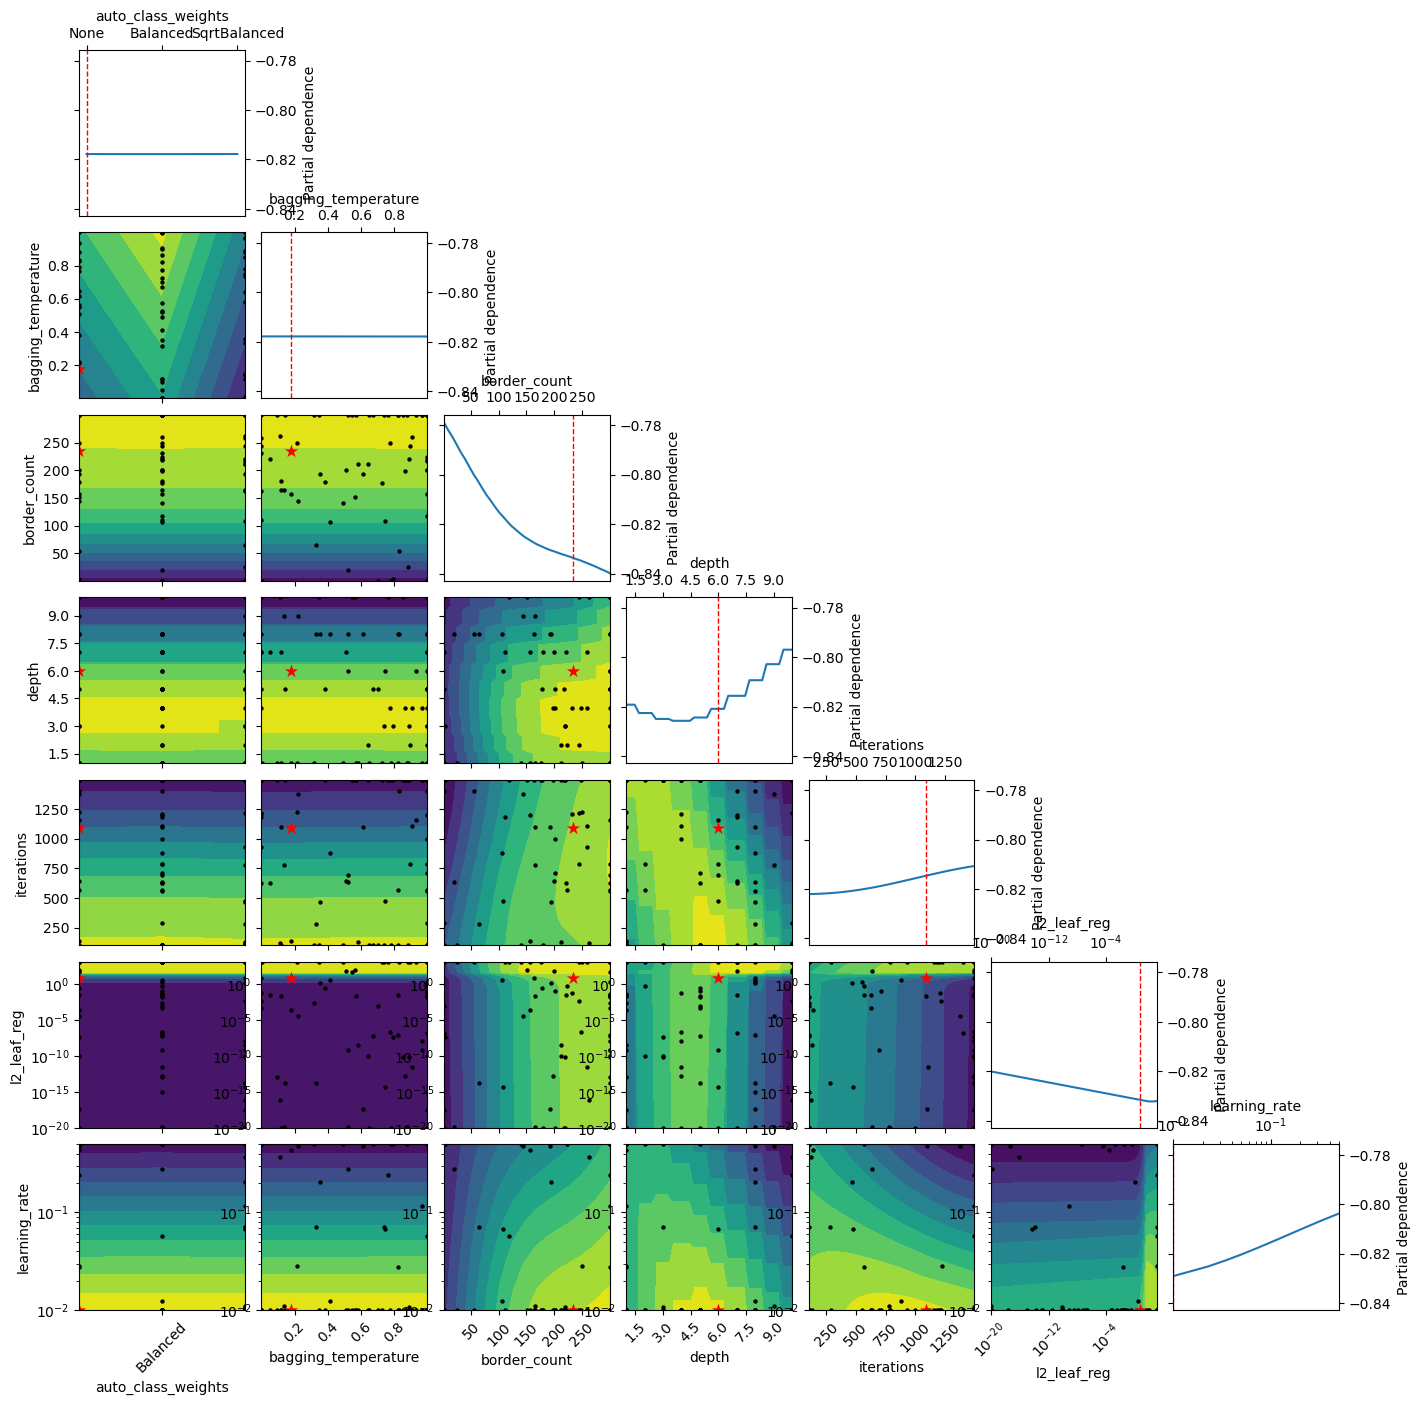

In [121]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    cat_surname_clf_bs_cv.optimizer_results_[0],
    dimensions=list(cat_surname_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

##### CatBoost (Catetgorical Boosting) Classifier - Surname Vec - SmoteNC

In [122]:
cat_surname_smotenc_features = [
    X_train_cat_smotenc.columns.get_loc(col)
    for col in X_train_cat_smotenc.columns
    if X_train_cat_smotenc[col].dtype == "object"
]

cat_surname_smotenc_clf = CatBoostClassifier(
    cat_features=cat_surname_smotenc_features,
    random_state=random_state,
    verbose=0,
)

cat_surname_smotenc_clf_bs_cv = BayesSearchCV(
    estimator=cat_surname_smotenc_clf,
    search_spaces=search_spaces_cat_namevec,
    n_iter=n_iter_cat,  
    cv=5,  
    n_jobs=-1,  
    scoring="roc_auc",
    verbose=0,
)

cat_surname_smotenc_clf_bs_cv.fit(X_train_cat_smotenc, y_train_smotenc)
print("Best parameters:", cat_surname_smotenc_clf_bs_cv.best_params_)

y_pred_cat_surname_smotenc = cat_surname_smotenc_clf_bs_cv.predict(X_test_cat)
accuracy_cat_surname_smotenc = accuracy_score(y_test, y_pred_cat_surname_smotenc.astype(int))
fpr_cat_surname_smotenc, tpr_cat_surname_smotenc, _ = roc_curve(y_test, cat_surname_smotenc_clf_bs_cv.predict_proba(X_test_cat)[:, 1])
auc_score_cat_surname_smotenc = roc_auc_score(y_test, cat_surname_smotenc_clf_bs_cv.predict_proba(X_test_cat)[:, 1])
cm_cat_surname_smotenc = confusion_matrix(y_test, y_pred_cat_surname_smotenc.astype(int))

TN_cat_surname_smotenc, FP_cat_surname_smotenc, FN_cat_surname_smotenc, TP_cat_surname_smotenc = cm_cat_surname_smotenc.ravel()
fnr_rr_cat_surname_smotenc = FN_cat_surname_smotenc / (FN_cat_surname_smotenc + TP_cat_surname_smotenc)
tnr_rr_cat_surname_smotenc = TN_cat_surname_smotenc / (TN_cat_surname_smotenc + FP_cat_surname_smotenc)

print("Prediction Accuracy for CatBoost:", accuracy_cat_surname_smotenc)
print("AUC Score for CatBoost:", auc_score_cat_surname_smotenc)


Best parameters: OrderedDict([('auto_class_weights', 'Balanced'), ('bagging_temperature', 0.5736390899201035), ('border_count', 229), ('depth', 10), ('iterations', 697), ('l2_leaf_reg', 6.386381126492452), ('learning_rate', 0.086766944367633)])
Prediction Accuracy for CatBoost: 0.814
AUC Score for CatBoost: 0.773013792758545


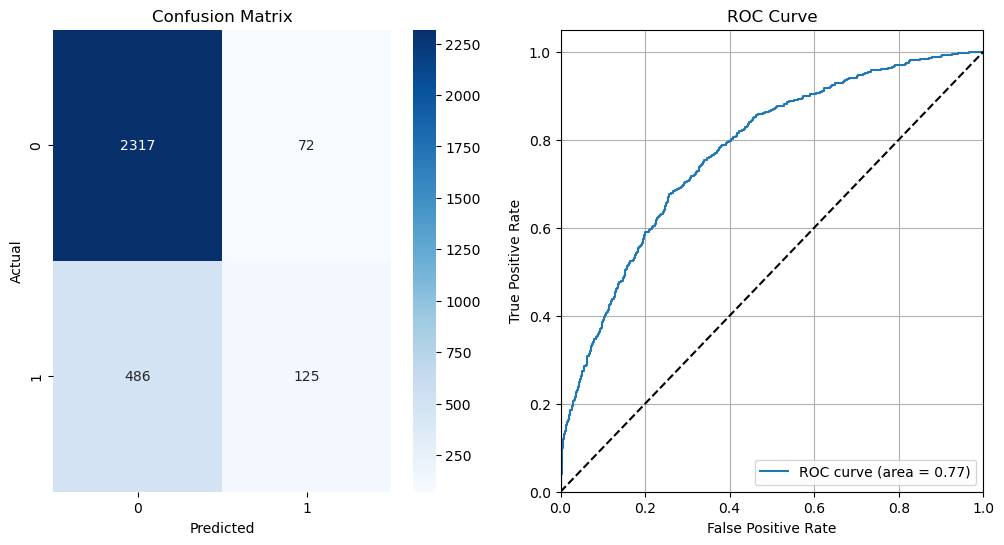

In [123]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_cat_surname_smotenc, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
plt.plot(fpr_cat_surname_smotenc, tpr_cat_surname_smotenc, label=f"ROC curve (area = {auc_score_cat_surname_smotenc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

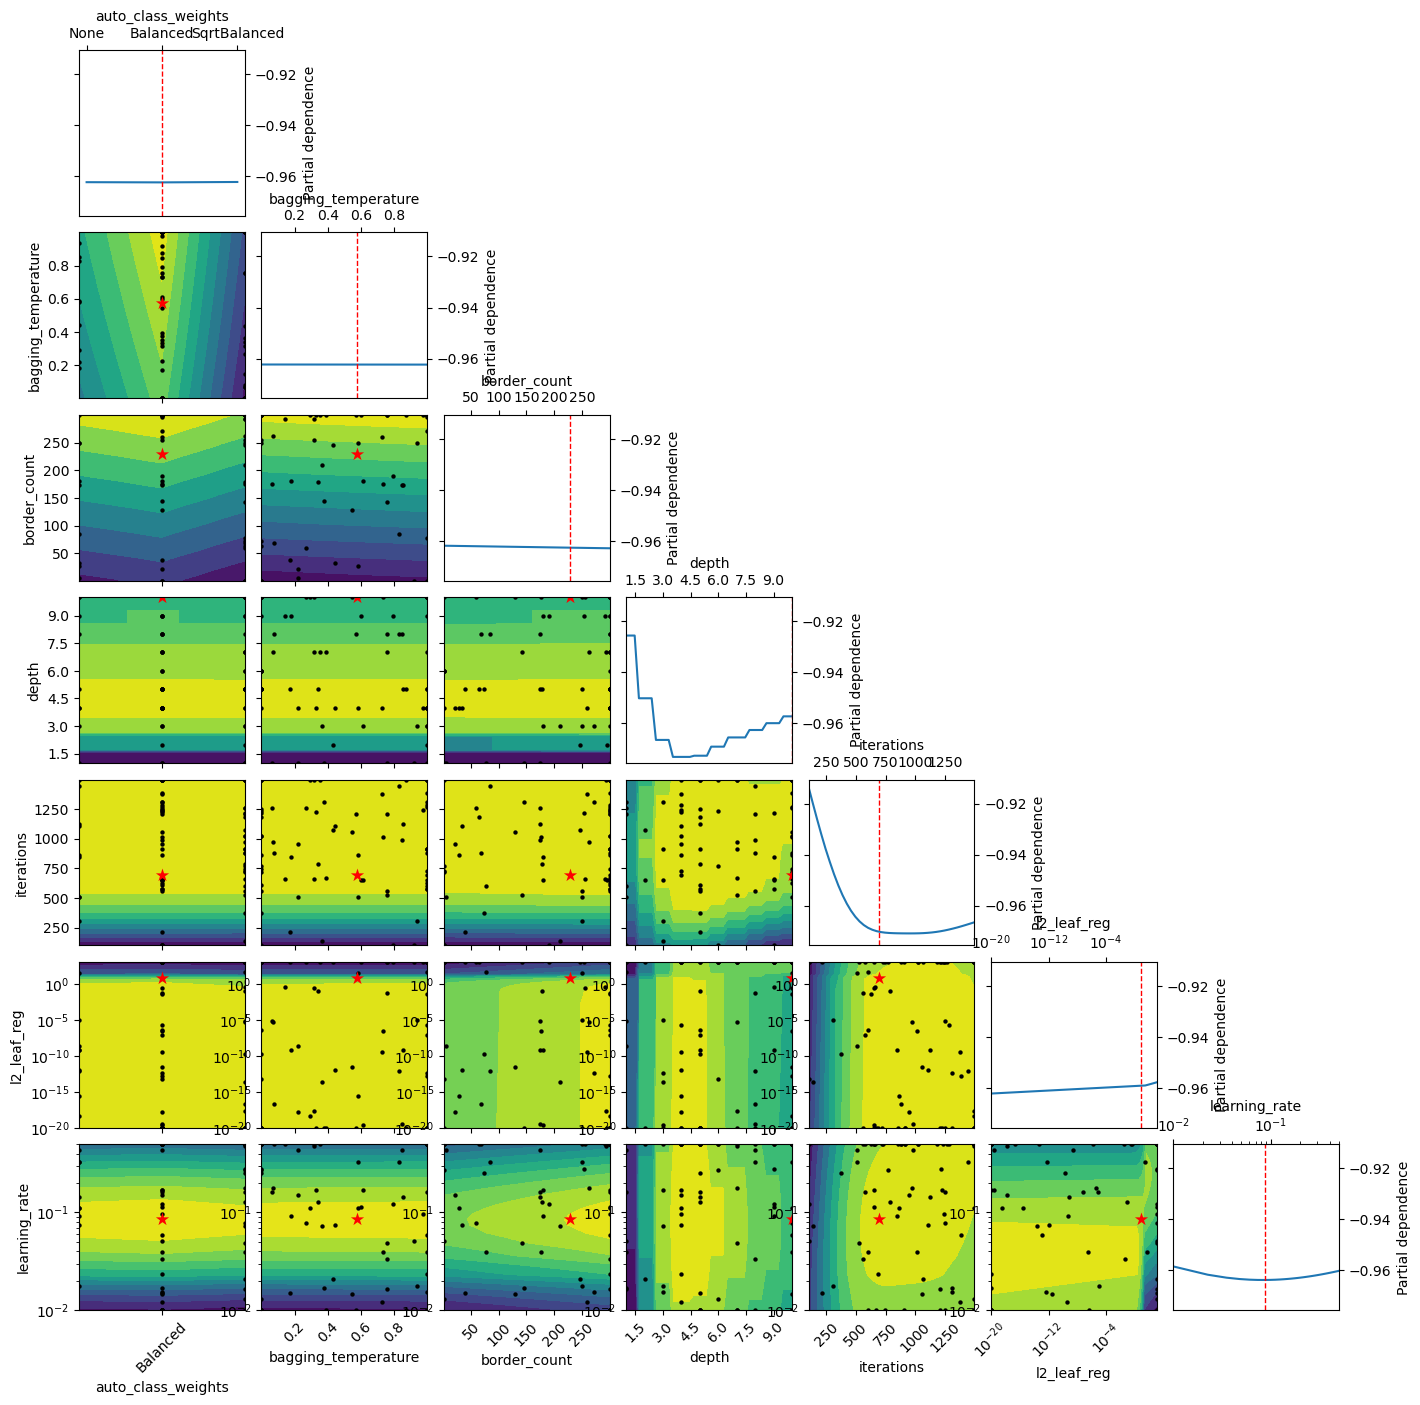

In [124]:
# plot the objective function to see if the search space is wide enough
plot_objective(
    cat_surname_smotenc_clf_bs_cv.optimizer_results_[0],
    dimensions=list(cat_surname_smotenc_clf_bs_cv.best_params_.keys()),
    n_minimum_search=int(1e8)
)
plt.show()

# Feature Importance Analysis 

### Feature Importance based on base XGBoost model

In [261]:
# shap.initjs()  # required for some shap visualizations

In [126]:
best_xgb_model_parm = xgb_clf_bs_cv.best_estimator_
explainer_xgb = shap.Explainer(best_xgb_model_parm, X_train_trees)
shap_values_xgb = explainer_xgb(X_train_trees)

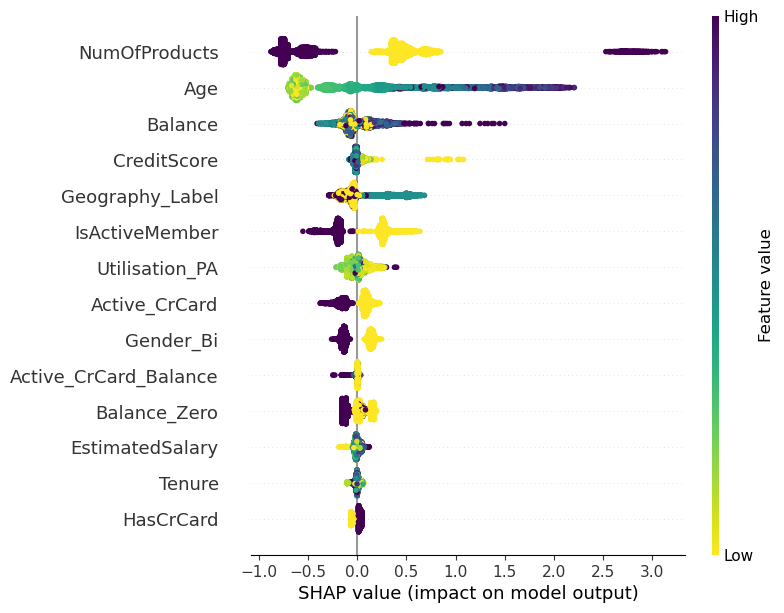

In [216]:
shap.plots.beeswarm(shap_values_xgb,order=shap_values_xgb.abs.max(0), max_display=20, color=plt.get_cmap("viridis_r"), plot_size=(7, 7))

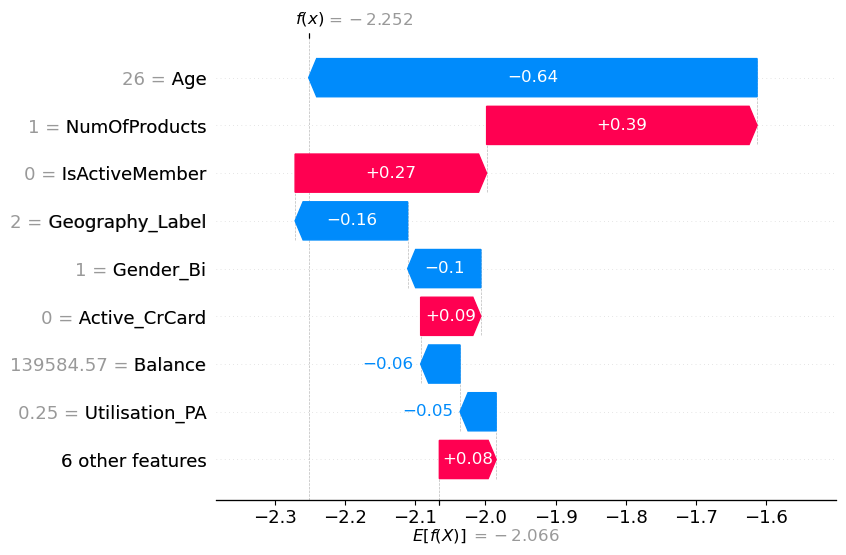

In [210]:
shap.plots.waterfall(shap_values_xgb[12], max_display=9)

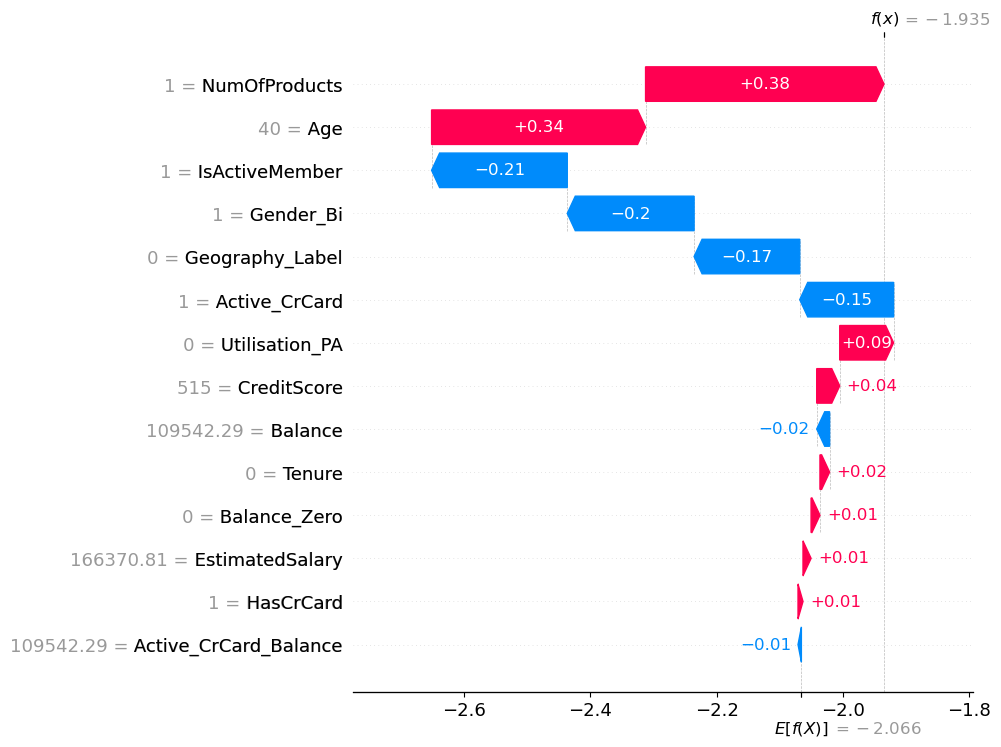

In [129]:
shap.plots.waterfall(shap_values_xgb[6999], max_display=15)

### Feature Importance based on base CatBoost model

In [130]:
best_cat_model_param = cat_clf_bs_cv.best_estimator_
explainer_cat = shap.TreeExplainer(best_cat_model_param)
shap_values_cat = explainer_cat.shap_values(X_train_cat_namedrop)

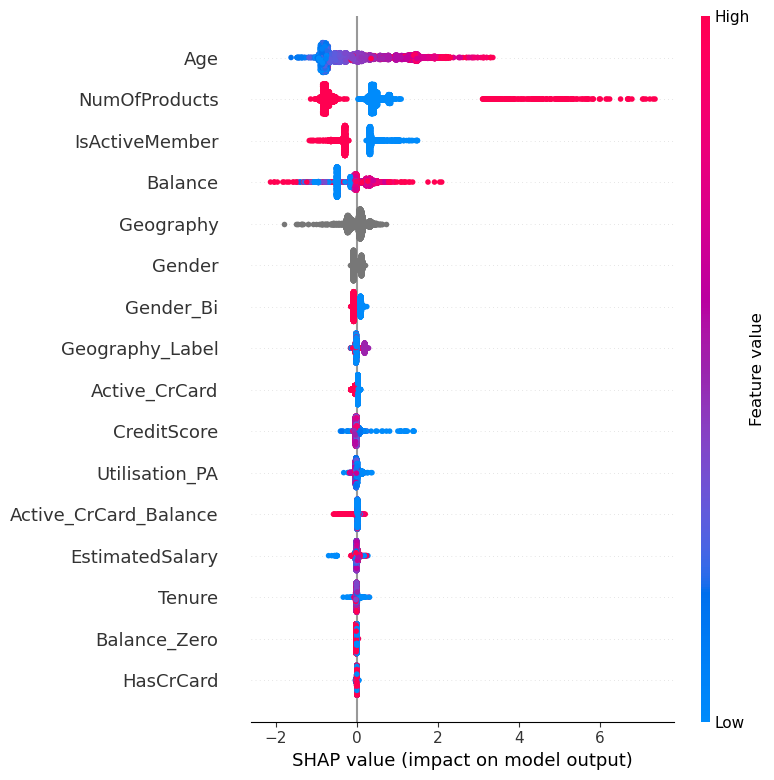

In [131]:
shap.summary_plot(shap_values_cat, features=X_train_cat_namedrop, plot_type="dot",
                  max_display=20, color=plt.get_cmap("viridis_r"))

### Feature Interaction between Age and Balance (logistic regression predicted probability)

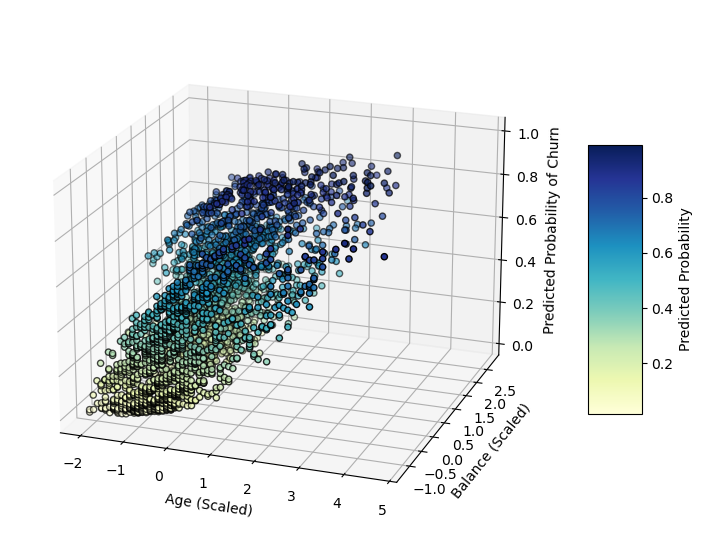

In [132]:
probabilities_logistic_z_smote = logistic_zscaled_smote_bs_cv.predict_proba(X_test_zscaled)[:, 1]
x_feature_age = X_test_zscaled[["Age"]].to_numpy().flatten() 
y_feature_balance = X_test_zscaled[["Balance"]].to_numpy().flatten()  

fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x_feature_age, y_feature_balance, probabilities_logistic_z_smote, 
                     c=probabilities_logistic_z_smote, cmap='YlGnBu', edgecolor='k', s=20, depthshade=True)

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Predicted Probability')

ax.view_init(elev=20, azim=110)
ax.set_xlabel('Age (Scaled)')
ax.set_ylabel('Balance (Scaled)')
ax.set_zlabel('Predicted Probability of Churn')
ax.invert_xaxis() 
ax.invert_yaxis()  

plt.show()


# Performance Evaluation

- True Positive (TP): correctly predicted who leave
- True Negative (TN): correctly predicted who stay
- False Positive (FP): predicted those who stay as leave
- False Negative (FN): predicted those who leave as stay <-- this is the most costly error, so we want this to be at small as possible

As a bank, we need to know if a customer is likely to leave us or not, thereby to deploy targeted promotion or retention strategies to keep the customer. But if we are unable to distingish who will leave us, specifically predicting False Negative (those who will leave but we predict they will stay), we will lose them without any headsup or warning. Therefore, we need to focus on the improving False Negative.

## Performance Data Collection

In [133]:
import pickle
# use pickle save the model to local for future use

In [134]:
model_performance = {
    "Model": [
        "Logistic Regression - minmax",
        "Logistic Regression - zscaled",
        "Logistic Regression - minmax - SmoteNC",
        "Logistic Regression - zscaled - SmoteNC",
        "Logistic Regression - zscaled - Surname Vec",
        "Logistic Regression - zscaled - Surname Vec - SmoteNC",
        "SVM - minmax",
        "SVM - zscaled",
        "SVM - minmax - SmoteNC",
        "SVM - zscaled - SmoteNC",
        "LDA - minmax",
        "LDA - zscaled",
        "LDA - minmax - SmoteNC",
        "LDA - zscaled - SmoteNC",
        "QDA - minmax",
        "QDA - zscaled",
        "QDA - minmax - SmoteNC",
        "QDA - zscaled - SmoteNC",
        "Tree",
        "Tree - SmoteNC",
        "Random Forest",
        "Random Forest - SmoteNC",
        "ADABoost",
        "ADABoost - SmoteNC",
        "XGBoost",
        "XGBoost - SmoteNC",
        "CatBoost",
        "CatBoost - SmoteNC",
        "CatBoost - Surname Vec",
        "CatBoost - Surname Vec - SmoteNC"
    ],
    "Accuracy": [
        accuracy_logistic_minmax,
        accuracy_logistic_zscaled,
        accuracy_logistic_minmax_smotenc,
        accuracy_logistic_zscaled_smotenc,
        accuracy_logistic_zscaled_surname,
        accuracy_logistic_zscaled_surname_smotenc,
        accuracy_svm_minmax,
        accuracy_svm_zscaled,
        accuracy_svm_minmax_smotenc,
        accuracy_svm_zscaled_smotenc,
        accuracy_lda_minmax,
        accuracy_lda_zscaled,
        accuracy_lda_minmax_smotenc,
        accuracy_lda_zscaled_smotenc,
        accuracy_qda_minmax,
        accuracy_qda_zscaled,
        accuracy_qda_minmax_smotenc,
        accuracy_qda_zscaled_smotenc,
        accuracy_tree,
        accuracy_tree_smotenc,
        accuracy_rf,
        accuracy_rf_smotenc,
        accuracy_ada,
        accuracy_ada_smotenc,
        accuracy_xgb,
        accuracy_xgb_smotenc,
        accuracy_cat,
        accuracy_cat_smotenc,
        accuracy_cat_surname,
        accuracy_cat_surname_smotenc
    ],
    "AUC": [
        auc_score_logistic_minmax,
        auc_score_logistic_zscaled,
        auc_score_logistic_minmax_smotenc,
        auc_score_logistic_zscaled_smotenc,
        auc_score_logistic_zscaled_surname,
        auc_score_logistic_zscaled_surname_smotenc,
        auc_score_svm_minmax,
        auc_score_svm_zscaled,
        auc_score_svm_minmax_smotenc,
        auc_score_svm_zscaled_smotenc,
        auc_score_lda_minmax,
        auc_score_lda_zscaled,
        auc_score_lda_minmax_smotenc,
        auc_score_lda_zscaled_smotenc,
        auc_score_qda_minmax,
        auc_score_qda_zscaled,
        auc_score_qda_minmax_smotenc,
        auc_score_qda_zscaled_smotenc,
        auc_score_tree,
        auc_score_tree_smotenc,
        auc_score_rf,
        auc_score_rf_smotenc,
        auc_score_ada,
        auc_score_ada_smotenc,
        auc_score_xgb,
        auc_score_xgb_smotenc,
        auc_score_cat,
        auc_score_cat_smotenc,
        auc_score_cat_surname,
        auc_score_cat_surname_smotenc
    ],
    "FNR": [
        fnr_rr_logistic_minmax,
        fnr_rr_logistic_zscaled,
        fnr_rr_logistic_minmax_smotenc,
        fnr_rr_logistic_zscaled_smotenc,
        fnr_rr_logistic_zscaled_surname,
        fnr_rr_logistic_zscaled_surname_smotenc,
        fnr_rr_svm_minmax,
        fnr_rr_svm_zscaled,
        fnr_rr_svm_minmax_smotenc,
        fnr_rr_svm_zscaled_smotenc,
        fnr_rr_lda_minmax,
        fnr_rr_lda_zscaled,
        fnr_rr_lda_minmax_smotenc,
        fnr_rr_lda_zscaled_smotenc,
        fnr_rr_qda_minmax,
        fnr_rr_qda_zscaled,
        fnr_rr_qda_minmax_smotenc,
        fnr_rr_qda_zscaled_smotenc,
        fnr_rr_tree,
        fnr_rr_tree_smotenc,
        fnr_rr_rf,
        fnr_rr_rf_smotenc,
        fnr_rr_ada,
        fnr_rr_ada_smotenc,
        fnr_rr_xgb,
        fnr_rr_xgb_smotenc,
        fnr_rr_cat,
        fnr_rr_cat_smotenc,
        fnr_rr_cat_surname,
        fnr_rr_cat_surname_smotenc
    ],
    "TNR": [
        tnr_rr_logistic_minmax,
        tnr_rr_logistic_zscaled,
        tnr_rr_logistic_minmax_smotenc,
        tnr_rr_logistic_zscaled_smotenc,
        tnr_rr_logistic_zscaled_surname,
        tnr_rr_logistic_zscaled_surname_smotenc,
        tnr_rr_svm_minmax,
        tnr_rr_svm_zscaled,
        tnr_rr_svm_minmax_smotenc,
        tnr_rr_svm_zscaled_smotenc,
        tnr_rr_lda_minmax,
        tnr_rr_lda_zscaled,
        tnr_rr_lda_minmax_smotenc,
        tnr_rr_lda_zscaled_smotenc,
        tnr_rr_qda_minmax,
        tnr_rr_qda_zscaled,
        tnr_rr_qda_minmax_smotenc,
        tnr_rr_qda_zscaled_smotenc,
        tnr_rr_tree,
        tnr_rr_tree_smotenc,
        tnr_rr_rf,
        tnr_rr_rf_smotenc,
        tnr_rr_ada,
        tnr_rr_ada_smotenc,
        tnr_rr_xgb,
        tnr_rr_xgb_smotenc,
        tnr_rr_cat,
        tnr_rr_cat_smotenc,
        tnr_rr_cat_surname,
        tnr_rr_cat_surname_smotenc
    ]
}

df_model_performance = pd.DataFrame(model_performance)
df_model_performance.to_csv("model_performance_results.csv", index=False)

In [135]:
roc_auc_data_all = {
    "Logistic Regression": {
        "Logistic Regression - minmax": {"tpr": tpr_logistic_minmax, "fpr": fpr_logistic_minmax, "auc": auc_score_logistic_minmax},
        "Logistic Regression - zscaled": {"tpr": tpr_logistic_zscaled, "fpr": fpr_logistic_zscaled, "auc": auc_score_logistic_zscaled},
        "Logistic Regression - minmax - SmoteNC": {"tpr": tpr_logistic_minmax_smotenc, "fpr": fpr_logistic_minmax_smotenc, "auc": auc_score_logistic_minmax_smotenc},
        "Logistic Regression - zscaled - SmoteNC": {"tpr": tpr_logistic_zscaled_smotenc, "fpr": fpr_logistic_zscaled_smotenc, "auc": auc_score_logistic_zscaled_smotenc},
        "Logistic Regression - zscaled - Surname Vec": {"tpr": tpr_logistic_zscaled_surname, "fpr": fpr_logistic_zscaled_surname, "auc": auc_score_logistic_zscaled_surname},
        "Logistic Regression - zscaled - Surname Vec - SmoteNC": {"tpr": tpr_logistic_zscaled_surname_smotenc, "fpr": fpr_logistic_zscaled_surname_smotenc, "auc": auc_score_logistic_zscaled_surname_smotenc},
    },
    "SVM": {
        "SVM - minmax": {"tpr": tpr_svm_minmax, "fpr": fpr_svm_minmax, "auc": auc_score_svm_minmax},
        "SVM - zscaled": {"tpr": tpr_svm_zscaled, "fpr": fpr_svm_zscaled, "auc": auc_score_svm_zscaled},
        "SVM - minmax - SmoteNC": {"tpr": tpr_svm_minmax_smotenc, "fpr": fpr_svm_minmax_smotenc, "auc": auc_score_svm_minmax_smotenc},
        "SVM - zscaled - SmoteNC": {"tpr": tpr_svm_zscaled_smotenc, "fpr": fpr_svm_zscaled_smotenc, "auc": auc_score_svm_zscaled_smotenc},
    },
    "LDA": {
        "LDA - minmax": {"tpr": tpr_lda_minmax, "fpr": fpr_lda_minmax, "auc": auc_score_lda_minmax},
        "LDA - zscaled": {"tpr": tpr_lda_zscaled, "fpr": fpr_lda_zscaled, "auc": auc_score_lda_zscaled },
        "LDA - minmax - SmoteNC": {"tpr": tpr_lda_minmax_smotenc, "fpr": fpr_lda_minmax_smotenc, "auc": auc_score_lda_minmax_smotenc},
        "LDA - zscaled - SmoteNC": {"tpr": tpr_lda_zscaled_smotenc, "fpr": fpr_lda_zscaled_smotenc, "auc": auc_score_lda_zscaled_smotenc},
    },
    "QDA": {
        "QDA - minmax": {"tpr": tpr_qda_minmax, "fpr": fpr_qda_minmax, "auc": auc_score_qda_minmax},
        "QDA - zscaled": {"tpr": tpr_qda_zscaled, "fpr": fpr_qda_zscaled, "auc": auc_score_qda_zscaled},
        "QDA - minmax - SmoteNC": {"tpr": tpr_qda_minmax_smotenc, "fpr": fpr_qda_minmax_smotenc, "auc": auc_score_qda_minmax_smotenc},
        "QDA - zscaled - SmoteNC": {"tpr": tpr_qda_zscaled_smotenc, "fpr": fpr_qda_zscaled_smotenc, "auc": auc_score_qda_zscaled_smotenc},
    },
    "Tree": {
        "Tree": {"tpr": tpr_tree, "fpr": fpr_tree, "auc": auc_score_tree},
        "Tree - SmoteNC": {"tpr": tpr_tree_smotenc, "fpr": fpr_tree_smotenc, "auc": auc_score_tree_smotenc},
    },
    "Random Forest": {
        "Random Forest": {"tpr": tpr_rf, "fpr": fpr_rf, "auc": auc_score_rf},
        "Random Forest - SmoteNC": {"tpr": tpr_rf_smotenc, "fpr": fpr_rf_smotenc, "auc": auc_score_rf_smotenc},
    },
    "ADABoost": {
        "ADABoost": {"tpr": tpr_ada, "fpr": fpr_ada, "auc": auc_score_ada},
        "ADABoost - SmoteNC": {"tpr": tpr_ada_smotenc, "fpr": fpr_ada_smotenc, "auc": auc_score_ada_smotenc},
    },
    "XGBoost": {
        "XGBoost": {"tpr": tpr_xgb, "fpr": fpr_xgb, "auc": auc_score_xgb},
        "XGBoost - SmoteNC": {"tpr": tpr_xgb_smotenc, "fpr": fpr_xgb_smotenc, "auc": auc_score_xgb_smotenc},
    },
    "CatBoost": {
        "CatBoost": {"tpr": tpr_cat, "fpr": fpr_cat, "auc": auc_score_cat},
        "CatBoost - SmoteNC": {"tpr": tpr_cat_smotenc, "fpr": fpr_cat_smotenc, "auc": auc_score_cat_smotenc},
        "CatBoost - Surname Vec": {"tpr": tpr_cat_surname, "fpr": fpr_cat_surname, "auc": auc_score_cat_surname},
        "CatBoost - Surname Vec - SmoteNC": {"tpr": tpr_cat_surname_smotenc, "fpr": fpr_cat_surname_smotenc, "auc": auc_score_cat_surname_smotenc},
    }
}
with open('roc_auc_data_all.pkl', 'wb') as file:
    pickle.dump(roc_auc_data_all, file)

# with open('roc_auc_data_all.pkl', 'rb') as file:
#     loaded_dict = pickle.load(file)

## ROC-AUC Analysis 

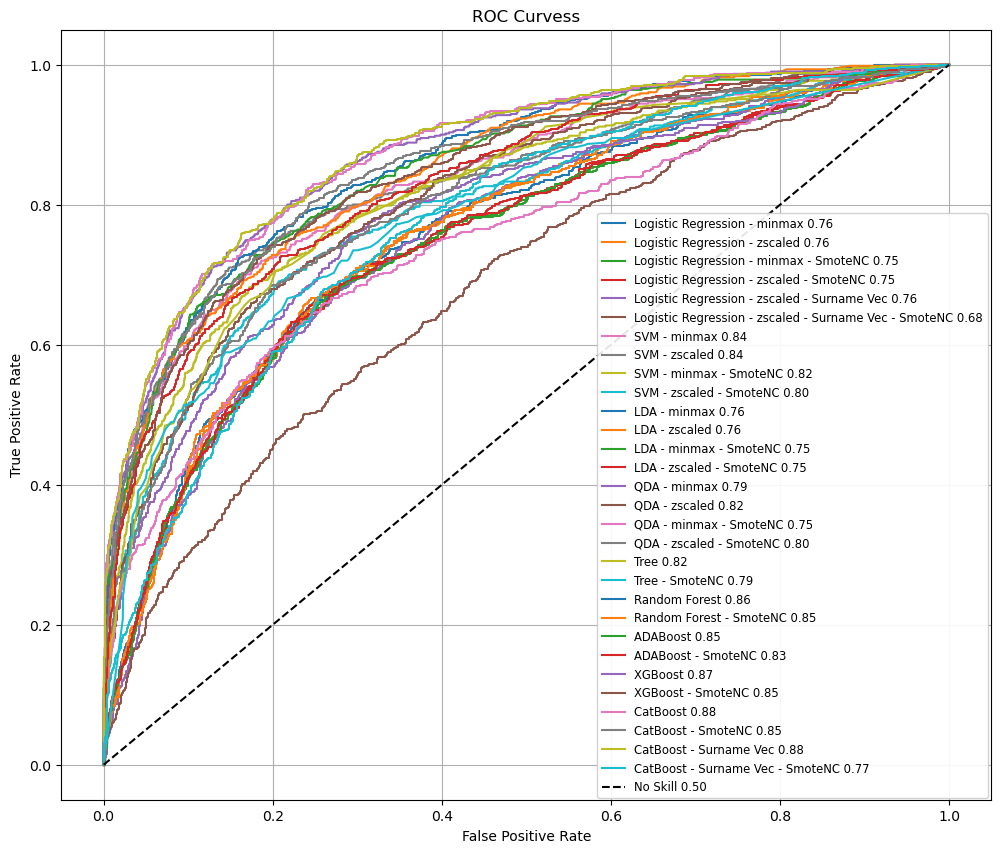

In [136]:
plt.figure(figsize=(12, 10))

for model_name, configs in roc_auc_data_all.items():
    for config_name, metrics in configs.items():
                auc_score = metrics['auc']
                plt.plot(metrics['fpr'], metrics['tpr'], label=f'{config_name } {auc_score:.2f}')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill 0.50') # Add a diagonal dashed line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curvess')
plt.legend( bbox_to_anchor=(0.57, 0.77), loc='upper left', fontsize='small', framealpha=0.9)
plt.grid(True)
plt.show()


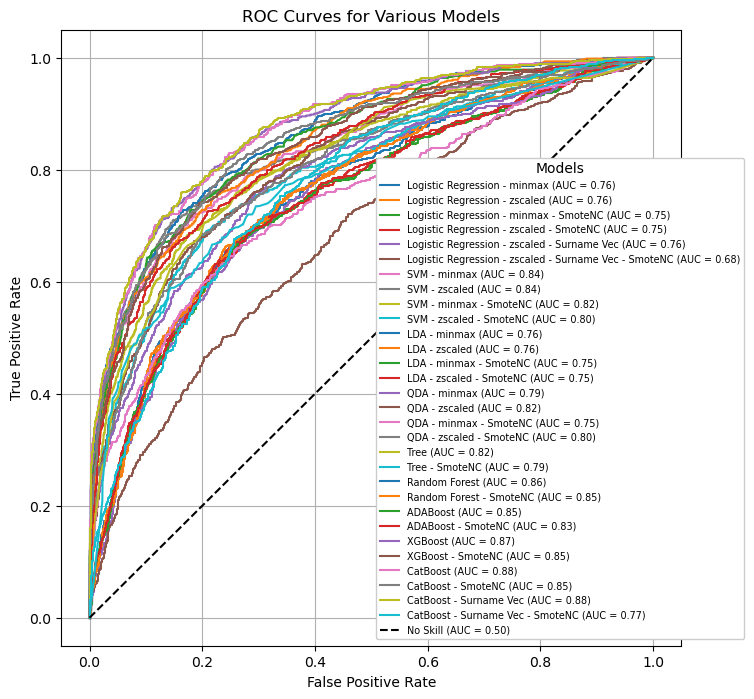

In [137]:
# a more flexiable way of plotting ROC-AUC
plt.figure(figsize=(8, 8))

plt.plot(fpr_logistic_minmax, tpr_logistic_minmax, label=f'Logistic Regression - minmax (AUC = {auc_score_logistic_minmax:.2f})')
plt.plot(fpr_logistic_zscaled, tpr_logistic_zscaled, label=f'Logistic Regression - zscaled (AUC = {auc_score_logistic_zscaled:.2f})')
plt.plot(fpr_logistic_minmax_smotenc, tpr_logistic_minmax_smotenc, label=f'Logistic Regression - minmax - SmoteNC (AUC = {auc_score_logistic_minmax_smotenc:.2f})')
plt.plot(fpr_logistic_zscaled_smotenc, tpr_logistic_zscaled_smotenc, label=f'Logistic Regression - zscaled - SmoteNC (AUC = {auc_score_logistic_zscaled_smotenc:.2f})')
plt.plot(fpr_logistic_zscaled_surname, tpr_logistic_zscaled_surname, label=f'Logistic Regression - zscaled - Surname Vec (AUC = {auc_score_logistic_zscaled_surname:.2f})')
plt.plot(fpr_logistic_zscaled_surname_smotenc, tpr_logistic_zscaled_surname_smotenc, label=f'Logistic Regression - zscaled - Surname Vec - SmoteNC (AUC = {auc_score_logistic_zscaled_surname_smotenc:.2f})')
plt.plot(fpr_svm_minmax, tpr_svm_minmax, label=f'SVM - minmax (AUC = {auc_score_svm_minmax:.2f})')
plt.plot(fpr_svm_zscaled, tpr_svm_zscaled, label=f'SVM - zscaled (AUC = {auc_score_svm_zscaled:.2f})')
plt.plot(fpr_svm_minmax_smotenc, tpr_svm_minmax_smotenc, label=f'SVM - minmax - SmoteNC (AUC = {auc_score_svm_minmax_smotenc:.2f})')
plt.plot(fpr_svm_zscaled_smotenc, tpr_svm_zscaled_smotenc, label=f'SVM - zscaled - SmoteNC (AUC = {auc_score_svm_zscaled_smotenc:.2f})')
plt.plot(fpr_lda_minmax, tpr_lda_minmax, label=f'LDA - minmax (AUC = {auc_score_lda_minmax:.2f})')
plt.plot(fpr_lda_zscaled, tpr_lda_zscaled, label=f'LDA - zscaled (AUC = {auc_score_lda_zscaled:.2f})')
plt.plot(fpr_lda_minmax_smotenc, tpr_lda_minmax_smotenc, label=f'LDA - minmax - SmoteNC (AUC = {auc_score_lda_minmax_smotenc:.2f})')
plt.plot(fpr_lda_zscaled_smotenc, tpr_lda_zscaled_smotenc, label=f'LDA - zscaled - SmoteNC (AUC = {auc_score_lda_zscaled_smotenc:.2f})')
plt.plot(fpr_qda_minmax, tpr_qda_minmax, label=f'QDA - minmax (AUC = {auc_score_qda_minmax:.2f})')
plt.plot(fpr_qda_zscaled, tpr_qda_zscaled, label=f'QDA - zscaled (AUC = {auc_score_qda_zscaled:.2f})')
plt.plot(fpr_qda_minmax_smotenc, tpr_qda_minmax_smotenc, label=f'QDA - minmax - SmoteNC (AUC = {auc_score_qda_minmax_smotenc:.2f})')
plt.plot(fpr_qda_zscaled_smotenc, tpr_qda_zscaled_smotenc, label=f'QDA - zscaled - SmoteNC (AUC = {auc_score_qda_zscaled_smotenc:.2f})')
plt.plot(fpr_tree, tpr_tree, label=f'Tree (AUC = {auc_score_tree:.2f})')
plt.plot(fpr_tree_smotenc, tpr_tree_smotenc, label=f'Tree - SmoteNC (AUC = {auc_score_tree_smotenc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:.2f})')
plt.plot(fpr_rf_smotenc, tpr_rf_smotenc, label=f'Random Forest - SmoteNC (AUC = {auc_score_rf_smotenc:.2f})')
plt.plot(fpr_ada, tpr_ada, label=f'ADABoost (AUC = {auc_score_ada:.2f})')
plt.plot(fpr_ada_smotenc, tpr_ada_smotenc, label=f'ADABoost - SmoteNC (AUC = {auc_score_ada_smotenc:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_score_xgb:.2f})')
plt.plot(fpr_xgb_smotenc, tpr_xgb_smotenc, label=f'XGBoost - SmoteNC (AUC = {auc_score_xgb_smotenc:.2f})')
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_score_cat:.2f})')
plt.plot(fpr_cat_smotenc, tpr_cat_smotenc, label=f'CatBoost - SmoteNC (AUC = {auc_score_cat_smotenc:.2f})')
plt.plot(fpr_cat_surname, tpr_cat_surname, label=f'CatBoost - Surname Vec (AUC = {auc_score_cat_surname:.2f})')
plt.plot(fpr_cat_surname_smotenc, tpr_cat_surname_smotenc, label=f'CatBoost - Surname Vec - SmoteNC (AUC = {auc_score_cat_surname_smotenc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(title='Models', bbox_to_anchor=(0.5, 0.8), loc='upper left', fontsize='x-small', framealpha=1)

plt.grid(True)
plt.show()


## Accuracy Analysis 

In [138]:
df_model_performance

Model  Accuracy       AUC  \
0                        Logistic Regression - minmax  0.807000  0.761113   
1                       Logistic Regression - zscaled  0.808333  0.762888   
2              Logistic Regression - minmax - SmoteNC  0.729333  0.748017   
3             Logistic Regression - zscaled - SmoteNC  0.732667  0.751491   
4         Logistic Regression - zscaled - Surname Vec  0.803333  0.757408   
5   Logistic Regression - zscaled - Surname Vec - ...  0.682000  0.681446   
6                                        SVM - minmax  0.852333  0.837058   
7                                       SVM - zscaled  0.857000  0.837289   
8                              SVM - minmax - SmoteNC  0.801667  0.820735   
9                             SVM - zscaled - SmoteNC  0.801667  0.795642   
10                                       LDA - minmax  0.804667  0.761473   
11                                      LDA - zscaled  0.804667  0.761473   
12                             LDA - minmax - SmoteNC  0.727000  0.746909   
13                            LDA - zscaled - SmoteNC  0.728333  0.748576   
14                                       QDA - minmax  0.812667  0.788185   
15                                      QDA - zscaled  0.836667  0.815084   
16                             QDA - minmax - SmoteNC  0.706667  0.747161   
17                            QDA - zscaled - SmoteNC  0.742000  0.804351   
18                                               Tree  0.840333  0.815873   
19                                     Tree - SmoteNC  0.759000  0.787311   
20                                      Random Forest  0.860333  0.862572   
21                            Random Forest - SmoteNC  0.843667  0.849211   
22                                           ADABoost  0.856000  0.852557   
23                                 ADABoost - SmoteNC  0.824000  0.833513   
24                                            XGBoost  0.863333  0.874017   
25                                  XGBoost - SmoteNC  0.749000  0.846226   
26                                           CatBoost  0.862333  0.876221   
27                                 CatBoost - SmoteNC  0.852333  0.851896   
28                             CatBoost - Surname Vec  0.864000  0.878321   
29                   CatBoost - Surname Vec - SmoteNC  0.814000  0.773014   

         FNR       TNR  
0   0.806874  0.964002  
1   0.839607  0.974048  
2   0.346972  0.748849  
3   0.337152  0.750523  
4   0.888707  0.980326  
5   0.461538  0.718711  
6   0.617021  0.972373  
7   0.631751  0.982001  
8   0.330606  0.835496  
9   0.391162  0.850984  
10  0.780687  0.954374  
11  0.780687  0.954374  
12  0.348609  0.746337  
13  0.353519  0.749267  
14  0.520458  0.897865  
15  0.707038  0.975722  
16  0.327332  0.715362  
17  0.281506  0.748012  
18  0.615385  0.956886  
19  0.333879  0.782754  
20  0.585925  0.974466  
21  0.397709  0.905400  
22  0.585925  0.969025  
23  0.378069  0.875680  
24  0.543372  0.967350  
25  0.214403  0.739640  
26  0.540098  0.965257  
27  0.432079  0.925073  
28  0.525368  0.963583  
29  0.795417  0.969862

In [139]:
df_model_performance_index = df_model_performance.set_index('Model')

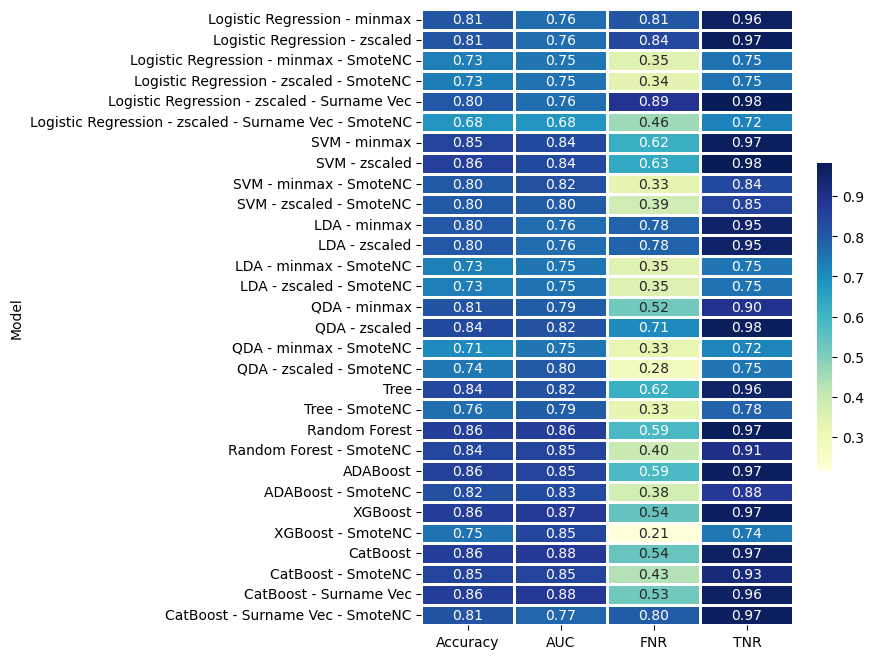

In [140]:
plt.figure(figsize=(6, 8))

sns.heatmap(
    df_model_performance_index.astype(float), 
    annot=True,     
    cmap='YlGnBu', 
    fmt='.2f',      
    linewidths=.9,  
    cbar_kws={"shrink": .5} # Additional kwargs for the colorbar
)
plt.xticks(rotation=0, ha='center') 
plt.yticks(rotation=0) 

plt.show()


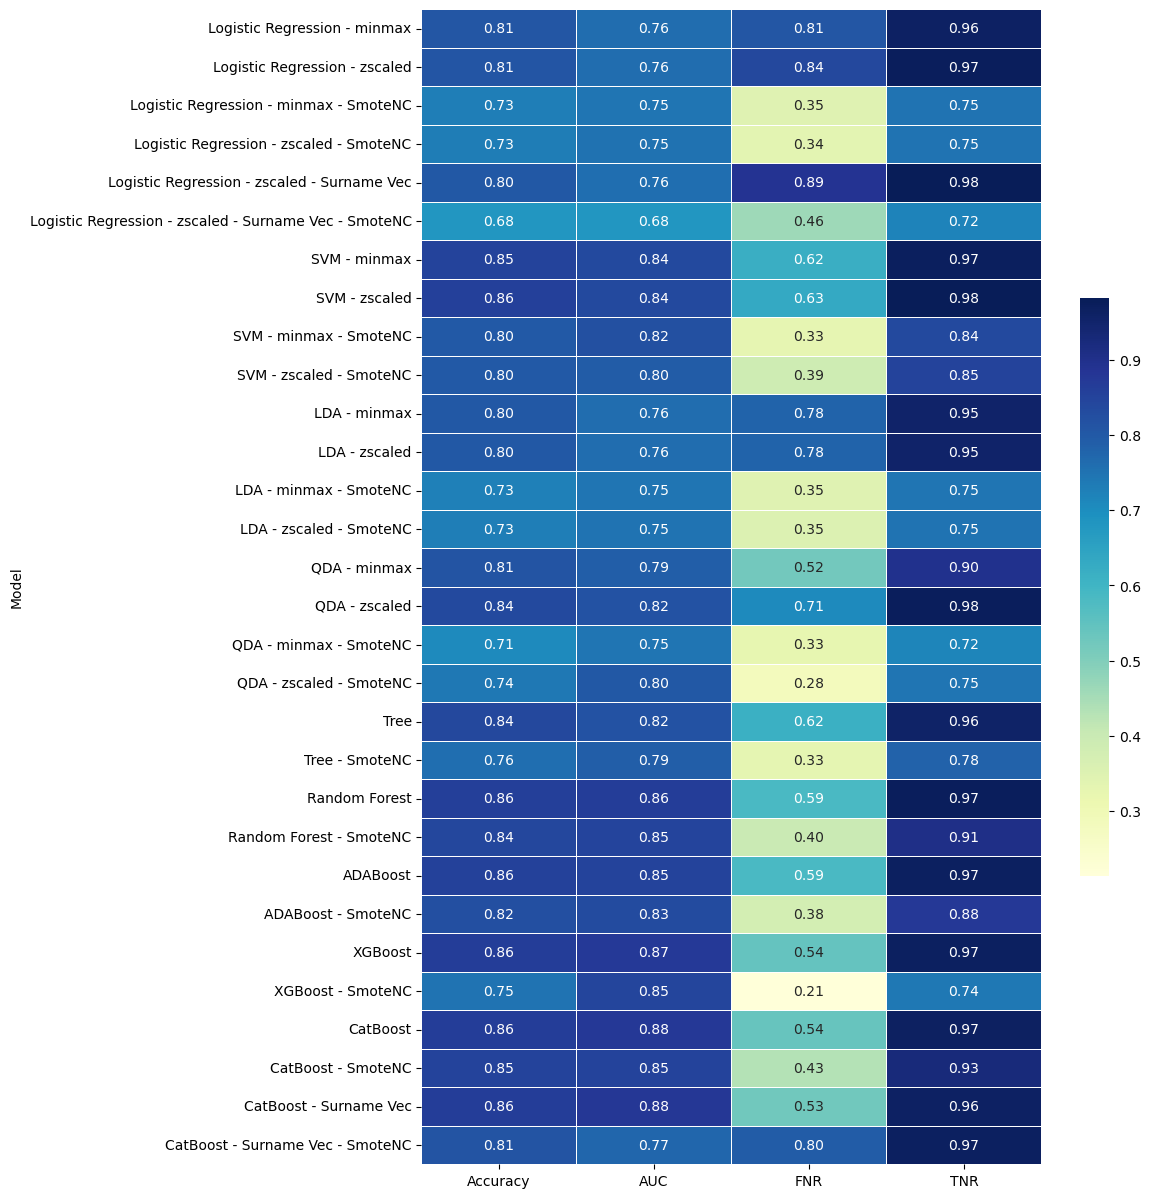

In [141]:
plt.figure(figsize=(10, len(df_model_performance_index) * 0.5))  # Adjust the size as needed

sns.heatmap(
    df_model_performance_index.astype(float),  # Convert to float for heatmap
    annot=True,                  # Annotate each cell with the numeric value
    fmt=".2f",                   # Formatting the annotation
    linewidths=.5,               # Lines between cells
    cbar_kws={"shrink": .5},     # Color bar kwargs
    cmap='YlGnBu'              # Color map
)

plt.yticks(rotation=0, ha='right')  

plt.show()


## False Negative Analysis

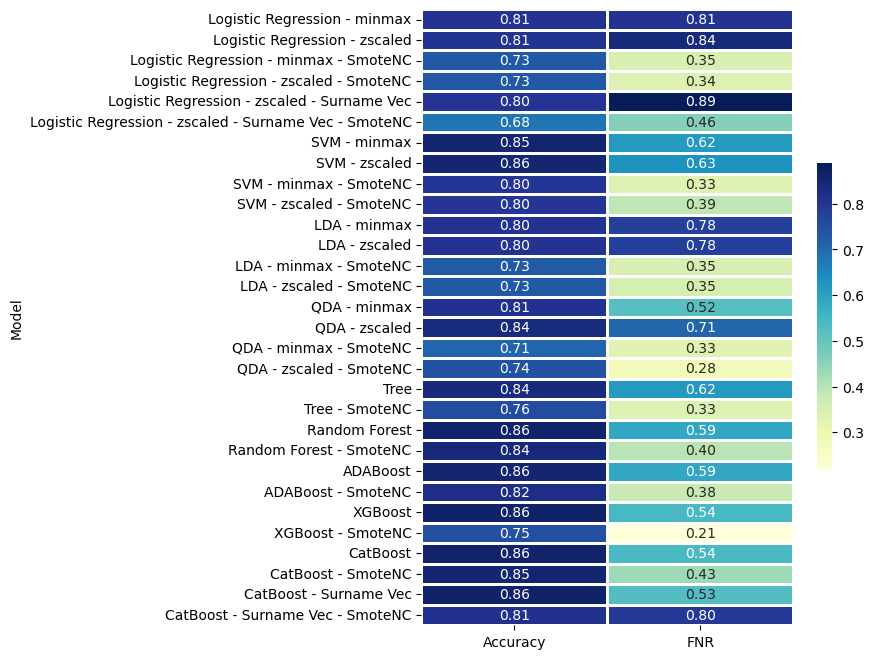

In [142]:
plt.figure(figsize=(6, 8))

sns.heatmap(
    df_model_performance_index[['Accuracy','FNR']].astype(float), 
    annot=True,     
    cmap='YlGnBu', 
    fmt='.2f',      
    linewidths=.9,  
    cbar_kws={"shrink": .5} # Additional kwargs for the colorbar
)
plt.xticks(rotation=0, ha='center') 
plt.yticks(rotation=0) 

plt.show()


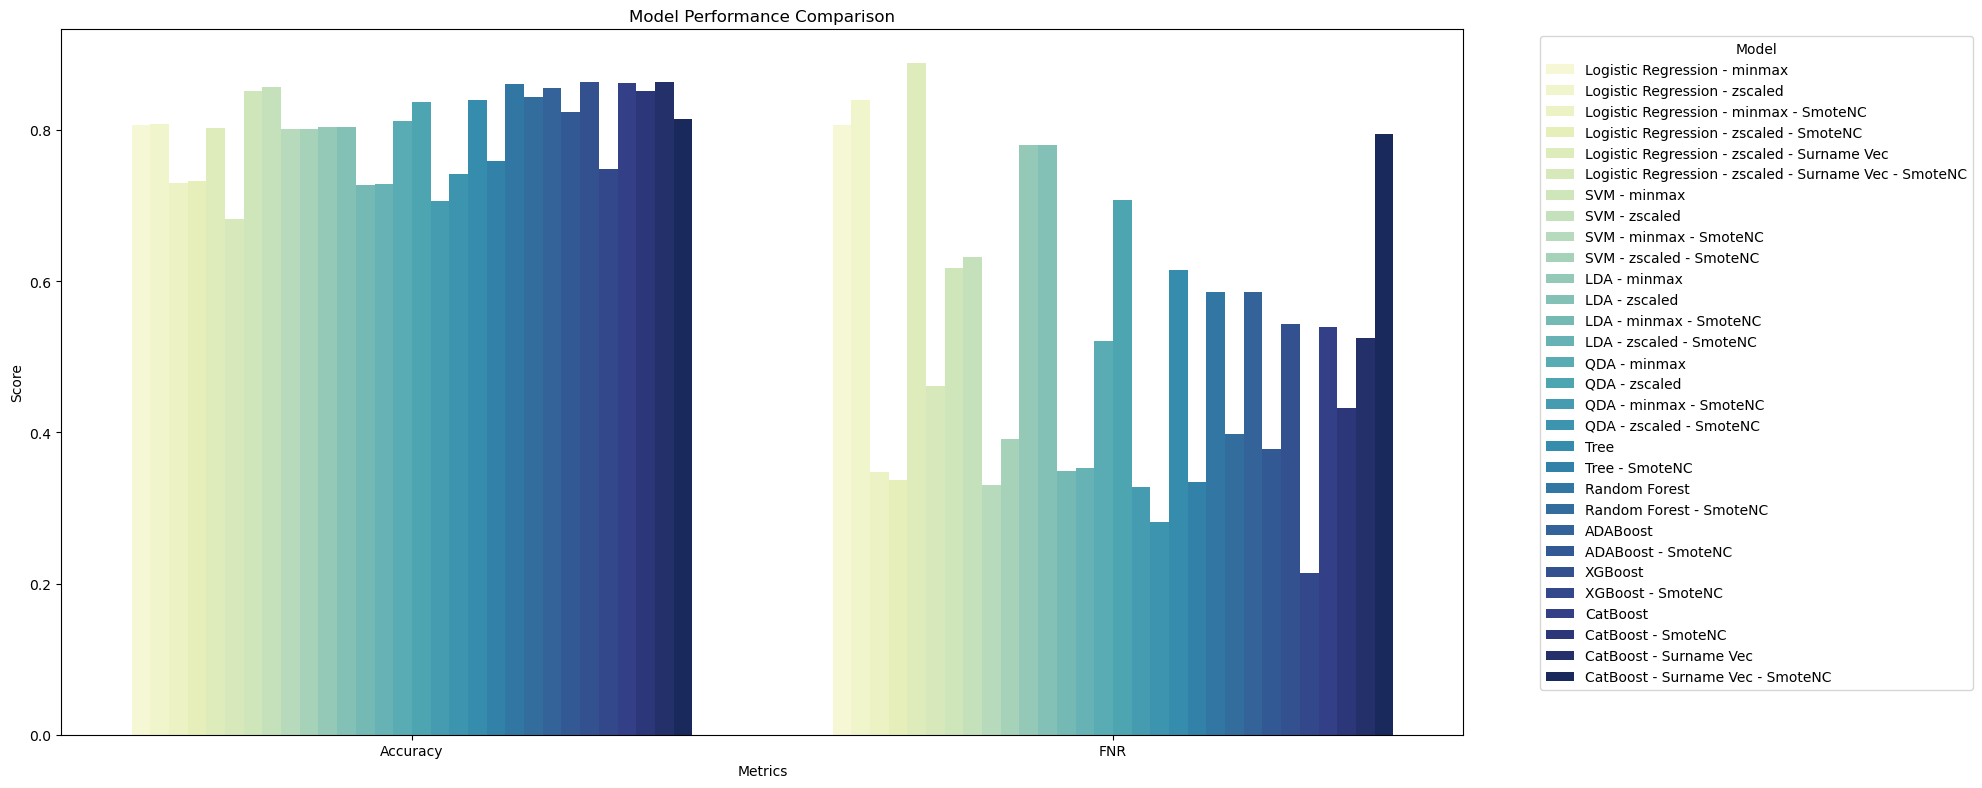

In [143]:
scores_melted = df_model_performance[["Model","Accuracy","FNR"]].melt(id_vars=["Model"], var_name="Metrics", value_name="Score")

plt.figure(figsize=(20, 8))

sns.barplot(x='Metrics', y='Score', hue='Model', data=scores_melted, palette='YlGnBu')

plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Cost Saving Estimation

We are going to estimate how much value can be generated or how much cost will be saved by using this model. The estimation will be made based on several assumptions.

In [218]:
# Total amount of loss of balance for the exited users
df_churn_exited = df_churn.loc[df_churn['Exited'] == 1]
num_exit = df_churn["Exited"].value_counts()[1]
sum_lost_balance = df_churn_exited['Balance'].sum()
ave_lost_balance = sum_lost_balance / num_exit
print("Loss of balance for the exited users:", round(sum_lost_balance,2))
print("Average loss of balance per exited users:", round(ave_lost_balance,2))

Loss of balance for the exited users: 185588094.63
Average loss of balance per exited users: 91108.54


- We sent targeted promotions to all predicted churn customers and assume (1-FNR from XGboost) of them are truly considering leaving the bank.  
- We assume real word churn distribution is the same as the distribution of churn in the dataset we used
- We assume the targeted promotion is 20% effective. 
- The interest rate spread between borrowing from market sources and retail deposits will be the spread savings. The spread is estimated to be 2%
- Targeted promotion cost is assumed to be 30 per predicted churn customer
- Then we can calculate the amount saved by using our model.

In [219]:
# Assupmtions:
FNR_xgboost_smotenc =  0.21
retail_market_interest_spread = 0.02
marketing_effectiveness = 0.2
adv_cost_per_customer = 30

In [220]:
amount_saved = (ave_lost_balance * (1-FNR_xgboost_smotenc) * retail_market_interest_spread * marketing_effectiveness) * 10000
net_amount_saved = round(amount_saved - (adv_cost_per_customer * 10000), 2)
print("Net amount saved per 10000 customer: $",net_amount_saved)

Net amount saved per 10000 customer: $ 2579029.84


THE END